# Introduction

The aim of this project is to develop a predictive model for real-time assessment of student performance during game-based learning. The model will be built on one of the most extensive open datasets of game logs available.

This undertaking will contribute to the evolution of knowledge-tracing methodologies for game-based learning. The outcome will aid educational game developers in crafting more effective and immersive learning experiences for students.


## Context

Game-based learning is designed to make education an engaging and interactive process. It places educational content within a game framework, turning learning into a dynamic and enjoyable experience. Despite its increasing usage in various educational contexts, open datasets that can be applied to refine game-based learning using data science and learning analytic principles are still limited.

Currently, many game-based learning platforms don't fully harness the power of knowledge tracing to assist individual learners. While knowledge tracing methodologies have been researched and implemented in online learning environments and intelligent tutoring systems, they are not as widely used in educational games.

Our project collaborator, Field Day Lab, is a public research lab at the Wisconsin Center for Educational Research. They develop games for a wide range of subjects and age groups, bringing contemporary research to the public. They utilize game data to gain insights into learning processes. With their commitment to accessibility, all games developed by Field Day Lab are freely available to everyone. They also work in partnership with nonprofit organizations such as The Learning Agency Lab, which focuses on creating science of learning-based tools and programs for social welfare.

Successful completion of this project will empower gandame developers to enhance educational games. It will also provide educators using these games with dashboards and analytical tools, potentially leading to broader support for game-based learning platforms.

I find this endeavor quite stimulating. As a coder, manual feature engineering can be a tedious process, so allowing the model to handle this aspect is a welcome relief. Despite the model only utilizing four columns, it yields a score of 0.691 - it may not be a massive success, but it's notable. Interestingly, adding more features only seems to degrade the performance.

Training the network on a GPU, including hyperparameter tuning, requires approximately five hours.


The proof of concept of the models and hyperparameter tuning was initially started by ChrisQ 

In [1]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    #start_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    #end_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    #print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

# Import the Required Libraries

In [2]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_decision_forests as tfdf


2023-06-22 14:06:06.756887: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-22 14:06:06.883424: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-22 14:06:06.884287: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-22 14:06:07.729232: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/jeffwa/anaconda3/envs/DL_new/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 

In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load and Analyze Dataset

- Due to the considerable size of the dataset, memory utilization is a critical factor to consider, as memory-related issues can cause the kernel to crash.
- When loading a dataset, Pandas, by default, identifies the data types of the various columns.
- Regardless of the maximum value present in these columns, Pandas attributes `int64` to numerical columns, `float64` to float columns, and `object` dtype to string columns, among others.

- There may be an opportunity to decrease these columns' memory footprint by downcasting numerical columns to smaller types (such as `int8`, `int32`, `float32`, etc.), if the maximum values in these columns do not necessitate the use of larger storage types (like `int64`, `float64`, etc.).

- Similarly, Pandas defaults string columns to the `object` datatype. For string columns storing categorical data, we can decrease memory usage by designating their datatype as `category`.

- A dictionary of `dtypes` for columns will be supplied to Pandas during the dataset loading phase.

In [5]:
import pandas as pd

train = pd.read_csv("train.csv", 
                    dtype=str, header=0, nrows=20000)
train = train.apply(pd.to_numeric, errors='ignore')

In [6]:
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values * 100
    summ['%missing'] = df.isnull().sum().values / len(df)
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['first value'] = df.loc[0].values
    summ['second value'] = df.loc[1].values
    summ['third value'] = df.loc[2].values
    
    return summ

In [7]:
summary_table = summary(train)
summary_table

data shape: (20000, 20)


,data type,#missing,%missing,#unique,min,max,first value,second value,third value
session_id,int64,0,0.00000,18,20090312431273200.0,20090317080721164.0,20090312431273200,20090312431273200,20090312431273200
index,int64,0,0.00000,1876,0.0,1875.0,0,1,2
elapsed_time,int64,0,0.00000,19912,0.0,4208427.0,0,1323,831
event_name,object,0,0.00000,11,NaN,NaN,cutscene_click,person_click,person_click
name,object,0,0.00000,6,NaN,NaN,basic,basic,basic
level,int64,0,0.00000,23,0.0,22.0,0,0,0
page,float64,1952300,0.97615,7,0.0,6.0,NaN,NaN,NaN
room_coor_x,float64,200200,0.10010,17138,-1949.787605,1234.469838,-413.991405,-413.991405,-413.991405
room_coor_y,float64,200200,0.10010,13940,-902.715653,486.258229,-159.314686,-159.314686,-159.314686
screen_coor_x,float64,200200,0.10010,1203,0.0,1419.0,380.0,380.0,380.0


In [8]:
train.head(5).style.background_gradient()

/home/jeffwa/anaconda3/envs/DL_new/lib/python3.10/site-packages/pandas/io/formats/style.py:3931: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/home/jeffwa/anaconda3/envs/DL_new/lib/python3.10/site-packages/pandas/io/formats/style.py:3932: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,nan,-413.991405,-159.314686,380.000000,494.000000,nan,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,nan,-413.991405,-159.314686,380.000000,494.000000,nan,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,nan,-413.991405,-159.314686,380.000000,494.000000,nan,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,nan,-413.991405,-159.314686,380.000000,494.000000,nan,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,nan,-412.991405,-159.314686,381.000000,494.000000,nan,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,0,0,1,0-4


In [9]:
train.head(5).style.bar()


/home/jeffwa/anaconda3/envs/DL_new/lib/python3.10/site-packages/pandas/io/formats/style.py:4165: RuntimeWarning: invalid value encountered in long_scalars
  end = (x - left) / (right - left)
/home/jeffwa/anaconda3/envs/DL_new/lib/python3.10/site-packages/pandas/io/formats/style.py:4198: RuntimeWarning: All-NaN slice encountered
  left = np.nanmin(values) if vmin is None else vmin
/home/jeffwa/anaconda3/envs/DL_new/lib/python3.10/site-packages/pandas/io/formats/style.py:4199: RuntimeWarning: All-NaN slice encountered
  right = np.nanmax(values) if vmax is None else vmax


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,nan,-413.991405,-159.314686,380.000000,494.000000,nan,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,nan,-413.991405,-159.314686,380.000000,494.000000,nan,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,nan,-413.991405,-159.314686,380.000000,494.000000,nan,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,nan,-413.991405,-159.314686,380.000000,494.000000,nan,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,nan,-412.991405,-159.314686,381.000000,494.000000,nan,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,0,0,1,0-4


In [10]:
train.head(5).style.set_properties(**{'border': '1.3px solid blue',
                          'color': 'green'})

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,nan,-413.991405,-159.314686,380.000000,494.000000,nan,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,nan,-413.991405,-159.314686,380.000000,494.000000,nan,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,nan,-413.991405,-159.314686,380.000000,494.000000,nan,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,nan,-413.991405,-159.314686,380.000000,494.000000,nan,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,nan,-412.991405,-159.314686,381.000000,494.000000,nan,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,0,0,1,0-4


In [11]:
# Highlight text with nan values 
train.head(6).style.applymap(lambda cell: 'color:red' if pd.isnull(cell) else '')

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,nan,-413.991405,-159.314686,380.000000,494.000000,nan,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,nan,-413.991405,-159.314686,380.000000,494.000000,nan,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,nan,-413.991405,-159.314686,380.000000,494.000000,nan,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,nan,-413.991405,-159.314686,380.000000,494.000000,nan,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,nan,-412.991405,-159.314686,381.000000,494.000000,nan,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,0,0,1,0-4
5,20090312431273200,5,3423,person_click,basic,0,nan,-412.991405,-157.314686,381.000000,492.000000,nan,"Sure thing, Jo. Grab your notebook and come upstairs!",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,0,0,1,0-4


In [16]:
import pandas as pd
from pandas_data_cleaner.base import clean_data
from pandas_data_cleaner.strategies import RemoveDuplicates


In [17]:
dataframe = clean_data(
    train,
    [RemoveDuplicates],
    remove_duplicates_subset_fields=["session_id"],
    remove_duplicates_keep="last"
)

In [18]:
dataframe.head(2)

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
880,20090312431273200,931,1272679,checkpoint,basic,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chap4_finale_c,tunic.capitol_2.hall,NaN,0,0,1,13-22
2711,20090312433251036,1875,3815334,checkpoint,basic,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chap4_finale_c,tunic.capitol_2.hall,NaN,0,0,0,13-22


In [19]:

from datacleaner import autoclean
clean_data = autoclean(train)
clean_data.head(3)

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,1,0,0,4.0,-413.991405,-159.314686,380.0,494.0,418.0,541,35,7,30,0,0,1,0
1,20090312431273200,1,1323,10,0,0,4.0,-413.991405,-159.314686,380.0,494.0,418.0,465,32,7,29,0,0,1,0
2,20090312431273200,2,831,10,0,0,4.0,-413.991405,-159.314686,380.0,494.0,418.0,270,32,7,29,0,0,1,0


In [20]:
# Reference: https://www.kaggle.com/competitions/predict-student-performance-from-game-play/discussion/384359
dtypes={
    'elapsed_time':np.int32,
    'event_name':'category',
    'name':'category',
    'level':np.uint8,
    'room_coor_x':np.float32,
    'room_coor_y':np.float32,
    'screen_coor_x':np.float32,
    'screen_coor_y':np.float32,
    'hover_duration':np.float32,
    'text':'category',
    'fqid':'category',
    'room_fqid':'category',
    'text_fqid':'category',
    'fullscreen':'category',
    'hq':'category',
    'music':'category',
    'level_group':'category'}
dataset_df2 = pd.read_csv('train.csv', dtype=dtypes)
dataset_df = pd.read_csv('train.csv', dtype=dtypes,nrows=40000)
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (40000, 20)


- The data is composed of 20 columns and 40000 entries. We can see all 20 dimensions of our dataset by printing out the first 5 entries using the following code:

# Feature Explanation

**Most of these features seem unlikely to improve a model's prediction score, so some feature engineering is necessary:**


session_id - the ID of the session the event took place in

index - the index of the event for the session

elapsed_time - how much time has passed (in milliseconds) between the start of the session and when the event was recorded

event_name - the name of the event type

name - the event name (e.g. identifies whether a notebook_click is is opening or closing the notebook)

level - what level of the game the event occurred in (0 to 22)


page - the page number of the event (only for notebook-related events)

room_coor_x - the coordinates of the click in reference to the in-game room (only for click events)

room_coor_y - the coordinates of the click in reference to the in-game room (only for click events)

screen_coor_x - the coordinates of the click in reference to the player’s screen (only for click events)

screen_coor_y - the coordinates of the click in reference to the player’s screen (only for click events)

hover_duration - how long (in milliseconds) the hover happened for (only for hover events)

text - the text the player sees during this event

fqid - the fully qualified ID of the event

room_fqid - the fully qualified ID of the room the event took place in

text_fqid - the fully qualified ID of the text the event took place in
fullscreen - whether the player is in fullscreen mode

hq - whether the game is in high-quality

music - whether the game music is on or off

level_group - which group of levels - and group of questions - this row belongs to (0-4, 5-12, 13-22)

In [21]:
dataset_df.head(5)

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991394,-159.314682,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4


In [22]:
# Display the first 5 examples
dataset_df.head(3)

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4


In [1]:
# See Nulls

In [23]:
display(dataset_df.isnull().sum())

session_id            0
index                 0
elapsed_time          0
event_name            0
name                  0
level                 0
page              39133
room_coor_x        3710
room_coor_y        3710
screen_coor_x      3710
screen_coor_y      3710
hover_duration    36394
text              25897
fqid              12492
room_fqid             0
text_fqid         25897
fullscreen            0
hq                    0
music                 0
level_group           0
dtype: int64

Please note that `session_id` uniquely identifies a user session.

# Load the labels

The labels for the training dataset are stored in the `train_labels.csv`. It consists of the information on whether the user in a particular session answered each question correctly. Load the labels data by running the following code. `

In [24]:
labels = pd.read_csv('train_labels.csv')

Each value in the column, `session_id` is a combination of both the session and the question number. 
We will split these into individual columns for ease of use.

In [25]:
labels['session'] = labels.session_id.apply(lambda x: int(x.split('_')[0]) )
labels['q'] = labels.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )

 - Let us take a look at the first 5 entries of `labels` using the following code:

In [26]:
# Display the first 5 examples
labels.head(5)

,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1
3,20090313091715820_q1,0,20090313091715820,1
4,20090313571836404_q1,1,20090313571836404,1


Our goal is to train models for each question to predict the label `correct` for any input user session. 

# Bar chart for label column: correct

- First we will plot a bar chart for the values of the label `correct`.

<AxesSubplot: >

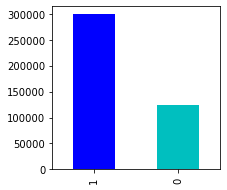

In [27]:
plt.figure(figsize=(3, 3))
plot_df = labels.correct.value_counts()
plot_df.plot(kind="bar", color=['b', 'c'])

- Now, let us plot the values of the label column `correct` for each question.

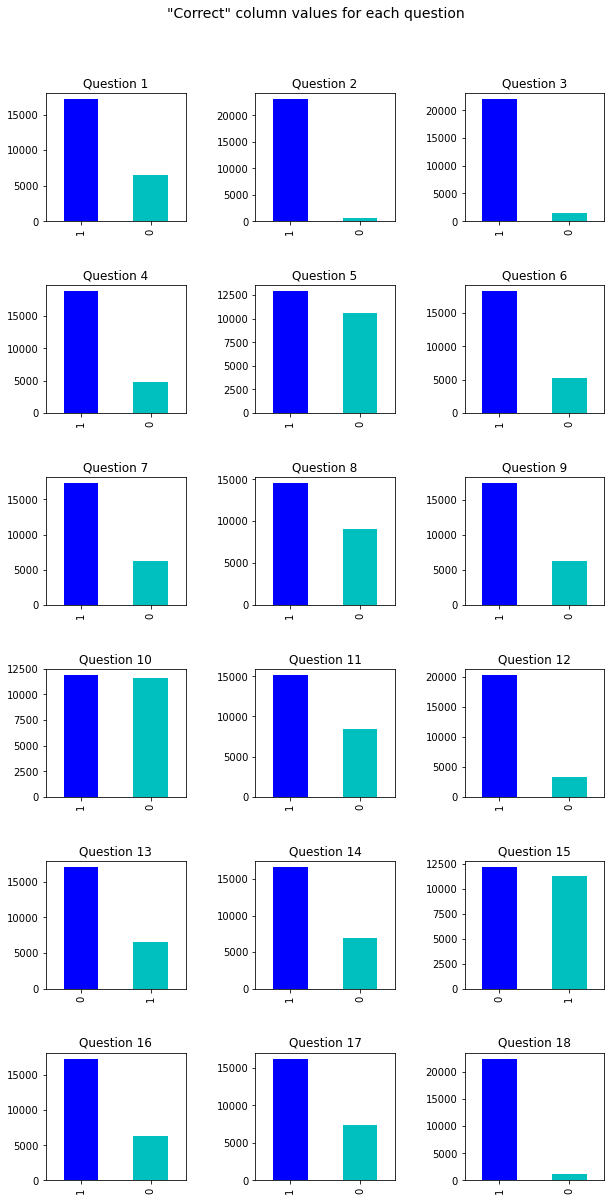

In [28]:
plt.figure(figsize=(10, 20))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.suptitle("\"Correct\" column values for each question", fontsize=14, y=0.94)
for n in range(1,19):
    #print(n, str(n))
    ax = plt.subplot(6, 3, n)

    # filter df and plot ticker on the new subplot axis
    plot_df = labels.loc[labels.q == n]
    plot_df = plot_df.correct.value_counts()
    plot_df.plot(ax=ax, kind="bar", color=['b', 'c'])
    
    # chart formatting
    ax.set_title("Question " + str(n))
    ax.set_xlabel("")


# Prepare the dataset

- As summarized in the competition overview, the dataset presents the questions and data to us in order of `levels - level segments`(represented by column `level_group`) 0-4, 5-12, and 13-22. We have to predict the correctness of each segment's questions as they are presented. To do this we will create basic aggregate features from the relevant columns. You can create more features to boost your scores. 

- First, we will create two separate lists with names of the Categorical columns and Numerical columns. We will avoid columns `fullscreen`, `hq` and `music` since they don't add any useful value for this problem statement.

In [29]:
CATEGORICAL = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid']
NUMERICAL = ['elapsed_time','level','page','room_coor_x', 'room_coor_y', 
        'screen_coor_x', 'screen_coor_y', 'hover_duration']

- For each categorical column, we will first group the dataset by `session_id`  and `level_group`. We will then count the number of **distinct elements** in the column for each group and store it temporarily.

- For all numerical columns, we will group the dataset by `session id` and `level_group`. Instead of counting the number of distinct elements, we will calculate the `mean` and `standard deviation` of the numerical column for each group and store it temporarily.

- After this, we will concatenate the temporary data frames we generated in the earlier step for each column to create our new feature engineered dataset.

In [30]:
def feature_engineer(dataset_df):
    dfs = []
    for c in CATEGORICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    for c in NUMERICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('mean')
        dfs.append(tmp)
    for c in NUMERICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
    dataset_df = pd.concat(dfs,axis=1)
    dataset_df = dataset_df.fillna(-1)
    dataset_df = dataset_df.reset_index()
    dataset_df = dataset_df.set_index('session_id')
    return dataset_df

In [31]:
dataset_df = feature_engineer(dataset_df)
print("Full prepared dataset shape is {}".format(dataset_df.shape))

Full prepared dataset shape is (105, 22)


# Basic exploration of the prepared dataset

In [32]:
# Display the first 5 examples
dataset_df.head(5)

,level_group,event_name_nunique,name_nunique,fqid_nunique,room_fqid_nunique,text_fqid_nunique,elapsed_time,level,page,room_coor_x,...,screen_coor_y,hover_duration,elapsed_time_std,level_std,page_std,room_coor_x_std,room_coor_y_std,screen_coor_x_std,screen_coor_y_std,hover_duration_std
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,0-4,10,3,30,7,17,8.579356e+04,1.945455,-1.0,7.701275,...,383.044861,2389.500000,49246.539458,1.230975,-1.000000,399.296038,129.292411,214.871000,104.082743,3227.370757
20090312431273200,13-22,10,3,49,12,35,1.040601e+06,17.402381,-1.0,-130.347168,...,379.301025,899.925903,126666.129584,2.358652,-1.000000,622.061374,230.370874,240.280218,99.067861,1305.088265
20090312431273200,5-12,10,3,39,11,24,3.572052e+05,8.054054,-1.0,14.306062,...,378.784912,969.333313,80175.676658,2.096919,-1.000000,357.227701,137.409476,203.268560,120.255453,1316.408315
20090312433251036,0-4,11,4,22,6,11,9.763342e+04,1.870504,0.0,-84.045959,...,370.723083,1378.750000,67372.714092,1.232616,0.000000,445.980041,156.186242,252.554707,121.062929,2114.876406
20090312433251036,13-22,11,6,73,16,43,2.498852e+06,17.762529,5.1,-30.762283,...,387.930084,720.384949,777382.529186,1.825923,0.863075,529.575656,234.279590,259.288856,133.345693,1990.705518


In [33]:
dataset_df.describe()

,event_name_nunique,name_nunique,fqid_nunique,room_fqid_nunique,text_fqid_nunique,elapsed_time,level,page,room_coor_x,room_coor_y,...,screen_coor_y,hover_duration,elapsed_time_std,level_std,page_std,room_coor_x_std,room_coor_y_std,screen_coor_x_std,screen_coor_y_std,hover_duration_std
count,105.000000,105.000000,105.000000,105.000000,105.000000,1.050000e+02,105.000000,105.000000,105.000000,105.000000,...,105.000000,105.000000,1.050000e+02,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000
mean,10.485714,3.866667,40.714286,10.400000,23.980952,9.510387e+05,9.295969,1.457178,-27.764317,-86.528664,...,386.846619,1851.861328,2.555528e+05,1.901101,0.094392,468.675967,184.724688,247.608762,131.064889,2773.712168
std,0.798006,0.734672,13.706199,3.096524,9.303619,1.063335e+06,6.521181,2.336432,82.654564,65.689438,...,54.856438,1307.037109,6.570947e+05,0.492676,0.786742,101.932304,47.028773,46.000924,26.192740,2069.740706
min,7.000000,3.000000,20.000000,6.000000,10.000000,5.264223e+04,1.369748,-1.000000,-225.531433,-259.805450,...,247.914536,-1.000000,2.887202e+04,1.126587,-1.000000,329.179475,110.365799,188.474532,90.706089,-1.000000
25%,10.000000,3.000000,26.000000,7.000000,15.000000,1.716958e+05,2.011765,-1.000000,-89.256973,-141.212357,...,358.476196,1038.421021,8.270789e+04,1.279318,-1.000000,387.883249,146.772817,222.400730,115.660498,1577.664318
50%,11.000000,4.000000,44.000000,11.000000,23.000000,5.549040e+05,8.247706,0.600000,-12.946318,-67.446449,...,379.301025,1474.900024,1.336515e+05,2.119689,0.438529,435.140572,169.175028,239.463268,126.806657,2087.449232
75%,11.000000,4.000000,52.000000,12.000000,33.000000,1.284812e+06,17.548414,4.000000,25.279221,-42.087360,...,397.383331,2271.571533,2.174885e+05,2.279854,0.770281,586.269812,230.370874,257.176984,136.668968,3276.108457
max,11.000000,6.000000,73.000000,16.000000,43.000000,5.344935e+06,19.090367,6.000000,177.756287,78.320251,...,635.934143,7035.000000,6.546964e+06,2.642213,1.676305,647.702226,288.708337,459.750352,239.024554,10795.046132


# Numerical data distribution



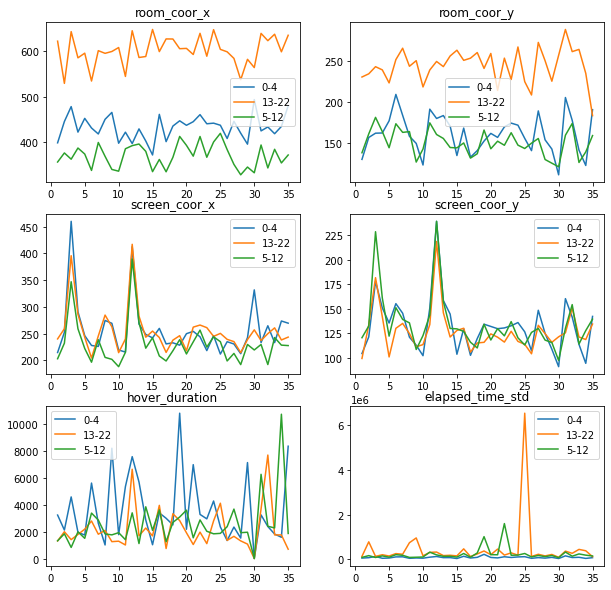

In [34]:
figure, axis = plt.subplots(3, 2, figsize=(10, 10))

for name, data in dataset_df.groupby('level_group'):
    axis[0, 0].plot(range(1, len(data['room_coor_x_std'])+1), data['room_coor_x_std'], label=name)
    axis[0, 1].plot(range(1, len(data['room_coor_y_std'])+1), data['room_coor_y_std'], label=name)
    axis[1, 0].plot(range(1, len(data['screen_coor_x_std'])+1), data['screen_coor_x_std'], label=name)
    axis[1, 1].plot(range(1, len(data['screen_coor_y_std'])+1), data['screen_coor_y_std'], label=name)
    axis[2, 0].plot(range(1, len(data['hover_duration'])+1), data['hover_duration_std'], label=name)
    axis[2, 1].plot(range(1, len(data['elapsed_time_std'])+1), data['elapsed_time_std'], label=name)
    

axis[0, 0].set_title('room_coor_x')
axis[0, 1].set_title('room_coor_y')
axis[1, 0].set_title('screen_coor_x')
axis[1, 1].set_title('screen_coor_y')
axis[2, 0].set_title('hover_duration')
axis[2, 1].set_title('elapsed_time_std')

for i in range(3):
    axis[i, 0].legend()
    axis[i, 1].legend()

plt.show()

- Now let us split the dataset into training and testing datasets:

In [35]:
def split_dataset(dataset, test_ratio=0.20):
    USER_LIST = dataset.index.unique()
    split = int(len(USER_LIST) * (1 - 0.20))
    return dataset.loc[USER_LIST[:split]], dataset.loc[USER_LIST[split:]]

train_x, valid_x = split_dataset(dataset_df)
print("{} examples in training, {} examples in testing.".format(
    len(train_x), len(valid_x)))

84 examples in training, 21 examples in testing.


# Build Feature "event_duration"

The variable 'event_duration' represents the difference between 'elapsed_time' of two consecutive events. This can often indicate a user's reluctance or uncertainty in answering an unfamiliar question.

'Elapsed_time', on the other hand, often contains high values and is susceptible to considerable outliers. It lacks specific context to a single question, as it encompasses cumulative time from previous questions and other activities. These characteristics pose challenges for effective model training. In contrast, 'event_duration' typically contains smaller values than 'elapsed_time', and outlier influence can be mitigated by clipping excessively large values.

Given the vast size of the dataset, it's crucial to downsize the dataframe for computations before incorporating it back into the main data. This strategy is necessary to prevent overloading the processing kernel, which could otherwise lead to system crashes or other issues.

In [2]:
import pandas as pd

In [3]:
dataset_df2 = pd.read_pickle("elapsed_time.pkl")

In [38]:
"""dataset_df2 = pd.read_csv(
    'train.csv',
    usecols = ['elapsed_time', 'session_id', 'level_group'])

dataset_df2=dataset_df2.groupby('session_id', as_index=False).apply(lambda x: x.sort_values('elapsed_time', ascending=True))
dataset_df2.reset_index(drop=True)




upper = 3.6e6 # 1 hour. events longer than 1 hour are outliers.

gps = []

# after reordering every row by its level_group and in ascending order of elapsed time we can calculate
# event_duration for every session of every group
# this code is slow but I think it is necessary because it simulates the test condition
for _, session in dataset_df2.groupby('session_id'):
    for _, gp in session.groupby('level_group'):
        event_duration = gp.elapsed_time.diff().fillna(0).clip(0, upper)
        gp['event_duration'] = event_duration
        gps.append(gp)
        
dataset_df2 = pd.concat(gps)
dataset_df2.to_pickle('elapsed_time.pkl')"""

"dataset_df2 = pd.read_csv(\n    'train.csv',\n    usecols = ['elapsed_time', 'session_id', 'level_group'])\n\ndataset_df2=dataset_df2.groupby('session_id', as_index=False).apply(lambda x: x.sort_values('elapsed_time', ascending=True))\ndataset_df2.reset_index(drop=True)\n\n\n\n\nupper = 3.6e6 # 1 hour. events longer than 1 hour are outliers.\n\ngps = []\n\n# event_duration for every session of every group\n# this code is slow but I think it is necessary because it simulates the test condition\nfor _, session in dataset_df2.groupby('session_id'):\n    for _, gp in session.groupby('level_group'):\n        event_duration = gp.elapsed_time.diff().fillna(0).clip(0, upper)\n        gp['event_duration'] = event_duration\n        gps.append(gp)\n        \ndataset_df2 = pd.concat(gps)\ndataset_df2.to_pickle('elapsed_time.pkl')"

In [5]:
dataset_df2.loc[1]

,session_id,elapsed_time,level_group,event_duration
881,20090312433251036,0,0-4,0.0
882,20090312433251036,218,0-4,218.0
883,20090312433251036,448,0-4,230.0
884,20090312433251036,702,0-4,254.0
885,20090312433251036,948,0-4,246.0
...,...,...,...,...
1410,20090312433251036,813127,5-12,1919.0
1411,20090312433251036,813728,5-12,601.0
1412,20090312433251036,814377,5-12,649.0
1413,20090312433251036,815625,5-12,1248.0


# Event-Aware Convolutional Networks

To model this problem, an Event-Aware Convolutional Neural Network (EACN) designed to recognize and react to specific 'events' in the input data seemed most fitting. Convolutional Neural Networks, also known as CNN or ConvNet, is a class of neural networks that specializes in processing data that has a grid-like topology. Usually the data is visual and audio. The convolution layer that makes the core building block of a CNN performs a dot product between two matrices, where one matrix is the set of learnable parameters otherwise known as a kernel, and the other matrix is the restricted portion of the receptive field. The result is that each output node in that layer works to extract key features of the data that are signigifcant for the fully-connected to output a correct prediction. 



The architecture of an EACN combines the principles of traditional CNNs with mechanisms that exploit the temporal nature of event-based data. Here are the key components and concepts of an EACN:

Event Processing: EACNs take into account the sparsity and asynchrony of event-based data. Instead of processing complete frames or images, they operate on individual events. Each event typically consists of a timestamp, spatial coordinates, and an event polarity.

Event Encoding: To process events, EACNs typically convert event streams into event tensors or event volumes, which are analogous to input images in traditional CNNs. Event encoding techniques can transform the sparse event data into dense, structured representations that can be effectively processed by convolutional layers.

Temporal Processing: EACNs employ mechanisms to capture and exploit temporal dependencies in event data. This can be achieved through recurrent connections or temporal convolutional layers, which allow the network to learn and model temporal patterns across events.




## Data used in this Model
The current performance metrics indicate a Cross Validation (CV) score of 0.6914 and Leaderboard (LB) score of 0.694, achieved with only four features:

1. Difference of `elapsed_time`
2. `event_name`
3. `name`
4. `room_fqid`

Initially, the 'event_name' is combined with 'name' to generate a novel feature: 'event_comb' (or event combination). This represents the status of the associated event (for instance, 'notebook_click_open' would denote the action of opening a notebook). In addition to this, the 'difference of elapsed_time' - a feature many have indicated as key - is considered as the sole numeric feature. It interacts with the other categorical variables. The primary motivation for this approach is to allow the model to capture event-specific temporal patterns. Essentially, each difference in time value is supplemented with event information and the location where the event occurs. The final model achieves the following performance:

| CV (GroupKFold with k=5) | Holdout (Released Old Test Set) | LB    |
| ------------------------ | ------------------------------- | ----- |
| 0.6914                   | 0.6911                          | 0.694 |

## 
This model training implements a predefined Cross Validation (CV) scheme for hyperparameter tuning, specifically GroupKFold with k=5. The GroupKFold cross-validation technique is designed to respect the structure of the data. As some datasets have a group structure where samples are naturally clustered, using a simple k-fold cross-validation could result in over-optimistic scores. GroupKFold ensures that the same group is not represented in both the training and validation sets, leading to a more robust estimation of the model's performance. The hyperparameter's in question are learning rate, weight decay, and F1 threshold (explained below).

The threshold parameter, as seen in the _F1 method, is a predetermined cut-off point used to convert predicted probabilities into class predictions. In the context of binary classification, if the predicted probability is higher than the threshold, the data point is classified as one class; otherwise, it is classified as the other class. In this case, any prediction with a value greater than 0.63 (the chosen threshold) is classified as '1', otherwise, it's classified as '0'. The choice of threshold can impact the performance of the model, hence, choosing an optimal threshold is important.

Upon completion of training, optimal model checkpoints can be downloaded for use in the inference part of the project.



## Import Packages

In [1]:
import os
import gc
import pickle
import random
import warnings
warnings.simplefilter("ignore")
from abc import abstractmethod
from copy import deepcopy
from typing import Any, Callable, Dict, List, Optional, Tuple, Type, Union
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score
from sklearn.model_selection import GroupKFold
from torch import optim, Tensor
from torch.nn import Module
from torch.optim import Optimizer, lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.data import Dataset, DataLoader
from torch.nn.modules.loss import _Loss
from torchmetrics import AUROC

N_QNS = 18
LEVEL = list(range(23))
LEVEL_GROUP = ["0-4", "5-12", "13-22"]
LVGP_ORDER = {"0-4": 0, "5-12": 1, "13-22": 2}
QNS_PER_LV_GP = {"0-4": list(range(1, 4)), "5-12": list(range(4, 14)), "13-22": list(range(14, 19))}
LV_PER_LV_GP = {"0-4": list(range(0, 5)), "5-12": list(range(5, 13)), "13-22": list(range(13, 23))}
CAT_FEAT_SIZE = {
    "event_comb_code": 19,
    "room_fqid_code": 19,
}

## Define Experiment Configuration 

In [2]:
def seed_all(seed: int) -> None:
    """Seed current experiment to guarantee reproducibility.

    Parameters:
        seed: manually specified seed number

    Return:
        None
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # When running with cudnn backend
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)

In [3]:
class CFG:
    # ==Mode==
    # Specify True to enable model training
    train = True
    
    # ==Data===
    FEATS = ["et_diff", "event_comb_code", "room_fqid_code"]
    CAT_FEATS = ["event_comb_code", "room_fqid_code"]
    COLS_TO_USE = ["session_id", "level", "level_group", "elapsed_time",
                   "event_name", "name", "room_fqid"]
    T_WINDOW = 1000
    
    # ==Training==
    SEED = 42
    DEVICE = "cuda:0"
    EPOCH = 100
    CKPT_METRIC = "f1@0.63"

    # ==DataLoader==
    BATCH_SIZE = 128
    NUM_WORKERS: 4

    # ==Solver==
    LR = 1e-3
    WEIGHT_DECAY = 1e-4

    # ==Early Stopping==
    ES_PATIENCE = 0

    # ==Evaluator==
    EVAL_METRICS = ["auroc", "f1"]

INPUT_PATH = "train.parquet"
TARGET_PATH = "train_labels2.csv"
cfg = CFG()
seed_all(cfg.SEED)

<a id="prep_data"></a>
## 1. Prepare Data


### Load and Clean Data

In [4]:
def summarize(
    df: pd.DataFrame,
    file_name: Optional[str] = None,
    n_rows_to_display: Optional[int] = 5,
) -> None:
    """Summarize DataFrame.

    Parameters:
        df: input data
        file_name: name of the input file
        n_rows_to_display: number of rows to display

    Return:
        None
    """
    file_name = "Data" if file_name is None else file_name

    # Derive NaN ratio for each column
    nan_ratio = pd.isna(df).sum() / len(df) * 100
    nan_ratio.sort_values(ascending=False, inplace=True)
    nan_ratio = nan_ratio.to_frame(name="NaN Ratio").T

    # Derive zero ratio for each column
    zero_ratio = (df == 0).sum() / len(df) * 100
    zero_ratio.sort_values(ascending=False, inplace=True)
    zero_ratio = zero_ratio.to_frame(name="Zero Ratio").T

    # Print out summarized information
    print(f"=====Summary of {file_name}=====")
    display(df.head(n_rows_to_display))
    print(f"Shape: {df.shape}")
    print("NaN ratio:")
    display(nan_ratio)
    print("Zero ratio:")
    display(zero_ratio)
    
def drop_multi_game_naive(
    df: pd.DataFrame,
    local: bool = True
) -> pd.DataFrame:
    """Drop events not occurring at the first game play.
    
    Note: `groupby` should be done with `sort=False` for the new
    training set, because `session_id` isn't sorted by default.
    
    Parameters:
        df: input DataFrame
        local: if False, the processing step is simplified based on the
            properties of returned test DataFrame by time series API
    
    Return:
        df: DataFrame with events occurring at the first game play only
    """
    df = df.copy()
    if local:
        df["lv_diff"] = df.groupby("session_id", sort=False).apply(lambda x: x["level"].diff().fillna(0)).values
    else:
        df["lv_diff"] = df["level"].diff().fillna(0)
    reversed_lv_pts = df["lv_diff"] < 0
    df.loc[~reversed_lv_pts, "lv_diff"] = 0
    if local:
        df["multi_game_flag"] = df.groupby("session_id", sort=False)["lv_diff"].cumsum().values
    else:
        df["multi_game_flag"] = df["lv_diff"].cumsum()
    multi_game_mask = df["multi_game_flag"] < 0
    multi_game_rows = df[multi_game_mask].index
    df = df.drop(multi_game_rows).reset_index(drop=True)
    
    # Drop redundant columns
    df.drop(["lv_diff", "multi_game_flag"], axis=1, inplace=True)
    
    return df

def map_lvgp_order(lvgp_seq: pd.Series) -> pd.Series:
    """Map level_group sequence to level_group order sequence.
    
    Parameters:
        lvgp_seq: level_group sequence
    
    Return:
        lvgp_order_seq: level_group order sequence
    """
    lvgp_order_seq = lvgp_seq.map(LVGP_ORDER)
    
    return lvgp_order_seq

def check_multi_game(df: pd.DataFrame) -> bool:
    """Check if multiple game plays exist in any session.
    
    Parameters:
        df: input DataFrame
    
    Return:
        multi_game_exist: if True, multiple game plays exist in at
            least one of the session
    """
    multi_game_exist = False
    for i, (sess_id, gp) in enumerate(df.groupby("session_id", sort=False)):
        if ((not gp["level"].is_monotonic_increasing)
            or (not gp["lvgp_order"].is_monotonic_increasing)):
            multi_game_exist = True
            break
            
    return multi_game_exist

In [5]:
df = pd.read_parquet(INPUT_PATH, columns=cfg.COLS_TO_USE)
y = pd.read_csv(TARGET_PATH)
summarize(df, "X", 2); summarize(y, "y", 2)

=====Summary of X=====


,session_id,level,level_group,elapsed_time,event_name,name,room_fqid
0,20090312431273200,0,0-4,0,cutscene_click,basic,tunic.historicalsociety.closet
1,20090312431273200,0,0-4,1323,person_click,basic,tunic.historicalsociety.closet


Shape: (13174211, 7)
NaN ratio:


,session_id,level,level_group,elapsed_time,event_name,name,room_fqid
NaN Ratio,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Zero ratio:


,level,elapsed_time,session_id,level_group,event_name,name,room_fqid
Zero Ratio,2.62084,0.089425,0.0,0.0,0.0,0.0,0.0


=====Summary of y=====


,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0


Shape: (212022, 2)
NaN ratio:


,session_id,correct
NaN Ratio,0.0,0.0


Zero ratio:


,correct,session_id
Zero Ratio,29.605418,0.0


In [6]:
df = drop_multi_game_naive(df)
df["lvgp_order"] = map_lvgp_order(df["level_group"])
if check_multi_game(df):
    print("There exist multiple game plays in at least one session.")

### Feature Engineering

The variable 'event_duration' is computed as the difference between the 'elapsed_time' values of two consecutive events, a transformation that has been commonly applied by several others in the field.

This step is crucial due to the characteristics of 'elapsed_time', which tends to house large values and is frequently skewed by substantial outliers. Such features pose challenges to effective model training. On the other hand, the values encompassed by 'event_duration' are typically less than those in 'elapsed_time', allowing for a reduction of outlier impact through the process of value clipping. This method mitigates the potential distortion that large values could introduce to the training process.

In [7]:
def get_factorize_map(
    values: Union[np.ndarray, pd.Series, pd.Index],
    sort: bool = True
) -> Dict[str, int]:
    """Factorize array and return numeric representation map.

    Parameters:
        values: 1-D sequence to factorize
        sort: whether to sort unique values

    Return:
        val2code: mapping from value to numeric code
    """
    if isinstance(values, np.ndarray):
        values = pd.Series(values)

    vals_uniq = values.unique()
    if sort:
        vals_uniq = sorted(vals_uniq)
    val2code = {val: code for code, val in enumerate(vals_uniq)}

    return val2code

In [8]:
# Generate the only numeric feature
df["et_diff"] = df.groupby("session_id", sort=False).apply(lambda x: x["elapsed_time"].diff().fillna(0)).values
df["et_diff"] = df["et_diff"].clip(0, 3.6e6)

# Factorize categorical features
df["event_comb"] = df["event_name"] + "_" + df["name"]
for cat_feat in cfg.CAT_FEATS:
    orig_col = cat_feat[:-5]
    cat2code = get_factorize_map(df[orig_col])
    df[cat_feat] = df[orig_col].map(cat2code)
    
    with open(f"./{orig_col}2code.pkl", "wb") as f:
        pickle.dump(cat2code, f)
        
X = df[["session_id", "level_group", "level"] + cfg.FEATS]
del df; _ = gc.collect()

### *Process Labels*

In [9]:
y["q"] = y["session_id"].apply(lambda x: x.split("_q")[1]).astype(int)
y["session_id"] = y["session_id"].apply(lambda x: x.split("_q")[0]).astype(int)
y = y.sort_values(["session_id", "q"]).reset_index(drop=True)
qn2lvgp = {qn: lv_gp for lv_gp, qns in QNS_PER_LV_GP.items() for qn in qns}
y["level_group"] = y["q"].map(qn2lvgp)
y_lvgp = y.groupby(["session_id", "level_group"]).apply(lambda x: list(x["correct"])).reset_index()
y_lvgp["lvgp_order"] = y_lvgp["level_group"].map(LVGP_ORDER)
y_lvgp = y_lvgp.sort_values(["session_id", "lvgp_order"]).reset_index(drop=True)
y_lvgp.rename({0: "correct"}, axis=1, inplace=True)
y_lvgp.drop(["lvgp_order"], axis=1, inplace=True)

print("=====Labels Aggregated by `level_group`=====")
y_lvgp.head(3)

=====Labels Aggregated by `level_group`=====


,session_id,level_group,correct
0,20090312431273200,0-4,"[1, 1, 1]"
1,20090312431273200,5-12,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 0]"
2,20090312431273200,13-22,"[1, 1, 0, 1, 1]"


In [10]:
y_all = y_lvgp.groupby("session_id").apply(lambda x: list(x["correct"])).reset_index()
ans_tmp = np.array(list(y_all.apply(lambda x: np.concatenate(x[0]), axis=1).values))
y_all.drop(0, axis=1, inplace=True)
y_all[list(range(18))] = ans_tmp
y_all = y_all.set_index("session_id").sort_index()

print("=====Flattened Labels=====")
y_all.head(3)

=====Flattened Labels=====


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
session_id,,,,,,,,,,,,,,,,,,
20090312431273200,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,1
20090312433251036,0,1,1,1,0,1,1,0,1,0,0,1,0,1,0,1,0,1
20090314121766812,1,1,1,0,0,1,1,0,0,1,1,1,0,1,1,1,0,1


In [11]:
del y; _ = gc.collect()

<a id="dataset"></a>
## 2. Define Dataset


In [12]:
class LvGpDataset(Dataset):
    """Dataset for `level_group`-wise modeling.

    Input data are all from the same `level_group`. Also, if `t_window`
    isn't long enough, only raw features from the last level of a
    `level_group` is retrieved.

    Commonly used notations are summarized as follows:
    * `N` denotes the number of samples
    * `P` denotes the length of lookback time window
    * `Q` denotes the number of questions in the current level group
    * `C` denotes the number of channels (numeric features)
        *Note: Currently, only `et_diff` is used as the numeric feature
    * `M` denotes the number of categorical features

    Each sample is session-specific, which is illustrated as follows:

    Let C=1 (i.e., only `et_diff` is used as the feature) and P=60, we
    have data appearance like:

    idx  t-59  t-58  ...  t-1  t
    0     1     2          0   2   -> session_id == 20090312431273200
    1     2     3          4   1   -> session_id == 20090312433251036
    .
    .
    .
    N-2
    N-1

    Parameters:
        data: input data
        t_window: length of lookback time window
    """

    n_samples: int

    def __init__(
        self,
        data: Tuple[pd.DataFrame, pd.DataFrame],
        t_window: int,
        **kwargs: Any,
    ) -> None:
        self.X_base, self.y_base = data
        #         self.y_base["correct"] = self.y_base["correct"].apply(lambda x: ast.literal_eval(x))
        self.t_window = t_window
        
        # Specify features to use
        self.feats = [feat for feat in cfg.FEATS if feat not in cfg.CAT_FEATS]
        self.cat_feats = cfg.CAT_FEATS

        # Setup level-related metadata
        self.lv_gp = self.X_base["level_group"].unique()[0]
        self.levels = LV_PER_LV_GP[self.lv_gp]
        self.n_lvs = len(self.levels)

        # Generate data samples
        self._chunk_X_y()
        self._set_n_samples()

    def __len__(self) -> int:
        return self.n_samples

    def __getitem__(self, idx: int) -> Dict[str, Tensor]:
        X = self.X[idx, ...]
        y = self.y[idx, ...]
        X_cat = self.X_cat[idx, ...]
        
        data_sample = {
            "X": torch.tensor(X, dtype=torch.float32),
            "X_cat": torch.tensor(X_cat, dtype=torch.int32),
            "y": torch.tensor(y, dtype=torch.float32),
        }

        return data_sample

    def _set_n_samples(self) -> None:
        """Derive the number of samples."""
        self.n_samples = len(self.X)

    def _chunk_X_y(self) -> None:
        """Chunk data samples."""
        X, y = [], []
        X_cat = []

        for sess_id in self.y_base["session_id"].values:
            # Target columns hard-coded temporarily
            X_sess = self.X_base[self.X_base["session_id"] == sess_id]
            
            pad_len = 0
            x_num = []
            for i, feat in enumerate(self.feats):
                x_num_i = X_sess[feat].values[-self.t_window :]
                if i == 0 and len(x_num_i) < self.t_window:
                    pad_len = self.t_window - len(x_num_i)
                
                if pad_len != 0:
                    x_num_i = np.pad(x_num_i, (pad_len, 0), "constant")
                    
                x_num.append(x_num_i)
            
            x_cat = X_sess[self.cat_feats].values[-self.t_window :]
            if pad_len != 0:
                x_cat = np.pad(x_cat, ((pad_len, 0), (0, 0)), "constant", constant_values=-1)  # (P, M)

            x_num = np.stack(x_num, axis=1)   # (P, C)
            X.append(x_num)
            X_cat.append(x_cat)
            y.append(self.y_base[self.y_base["session_id"] == sess_id]["correct"].values[0])

        self.X = np.stack(X)  # (N, P, C)
        self.X_cat = np.stack(X_cat)  # (N, P, M)
        self.y = np.vstack(y)  # (N, Q)

In [13]:
def build_dataloaders(
    data_tr: Tuple[pd.DataFrame, pd.DataFrame],
    data_val: Tuple[pd.DataFrame, pd.DataFrame],
    batch_size: int,
    **dataset_cfg: Any,
) -> Tuple[DataLoader, Optional[DataLoader]]:
    """Create and return train and validation dataloaders.

    Parameters:
        data_tr: training data
        data_val: validation data
        dataloader_cfg: hyperparameters of dataloader
        dataset_cfg: hyperparameters of customized dataset

    Return:
        train_loader: training dataloader
        val_loader: validation dataloader
    """
    if data_tr is not None:
        train_loader = DataLoader(
            LvGpDataset(data_tr, **dataset_cfg),
            batch_size=batch_size,
            shuffle=True,
            num_workers=2,
            collate_fn=None,
        )
    else:
        train_loader = None
    if data_val is not None:
        val_loader = DataLoader(
            LvGpDataset(data_val, **dataset_cfg),
            batch_size=batch_size,
            shuffle=False,  # Hard-coded
            num_workers=2,
            collate_fn=None,
        )
    else:
        val_loader = None

    return train_loader, val_loader

<a id="model"></a>
## 3. Model Architecture

The model is essentially comprised of two main components: an encoder and a classifier.

The encoder serves as a feature extractor. Its function is to aggregate the data points across all time steps and yield a vector composed of n features (referred to as an embedding). The aggregation process is achieved through the application of a 1-dimensional convolution operation.

The encoder can be deployed across different 'level_groups' provided that hyperparameters such as 'kernel_size' and 'channels' are kept consistent. For example, if we are training the model on 'level_group' 5-12, the weights derived from 'level_group' 0-4 can be efficiently reused, enabling a certain degree of transfer learning.


![2023-04-02-10-39-43.png](https://i.postimg.cc/2y9chX1n/2023-04-02-10-39-43.png)

The class "Evaluator" is defined to assess the performance of a model using specified metrics. This class is initialized with a list of metric names and a specified number of questions.


The threshold parameter, as seen in the _F1 method, is a predetermined cut-off point used to convert predicted probabilities into class predictions. In the context of binary classification, if the predicted probability is higher than the threshold, the data point is classified as one class; otherwise, it is classified as the other class. In this case, any prediction with a value greater than 0.63 (the chosen threshold) is classified as '1', otherwise, it's classified as '0'. The choice of threshold can impact the performance of the model, hence, choosing an optimal threshold is important.

In [14]:
class TConvLayer(nn.Module):
    """Dilated temporal convolution layer.
    
    Considering the time cost, I currently disable dilation.
    """
    
    def __init__(
        self,
        in_dim: int,
        out_dim: int,
        kernel_size: int,
        dilation: int,
        bias: bool = True,
        act: str = "relu",
        dropout: float = 0.1,
    ):
        super(TConvLayer, self).__init__()
        
        # Network parameters
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.kernel_size = kernel_size
        self.dilation = dilation
        self.bias = bias
        
        # Model blocks
        self.conv = nn.utils.weight_norm(
            nn.Conv1d(in_dim, out_dim, kernel_size, dilation=dilation, bias=bias),
            dim=None
        )
        self.bn = nn.BatchNorm1d(out_dim)
        if act == "relu":
            self.act = nn.ReLU()
        if dropout == 0:
            self.dropout = None
        else:
            self.dropout = nn.Dropout(dropout)
            
    def forward(self, x: Tensor) -> Tensor:
        """Forward pass.
        
        Shape:
            x: (B, C', P)
        """
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        if self.dropout is not None:
            x = self.dropout(x)
            
        return x
    

class EventAwareEncoder(nn.Module):
    """Event-aware encoder based on 1D-Conv."""
    
    def __init__(
        self,
        h_dim: int = 128,
        out_dim: int = 128,
        readout: bool = True,
        cat_feats: List[str] = ["event_comb_code", "room_fqid_code"]
    ):
        super(EventAwareEncoder, self).__init__()

        # Network parameters
        self.h_dim = h_dim
        self.out_dim = out_dim
        self.cat_feats = cat_feats

        # Model blocks
        # Categorical embeddings
        self.embs = nn.ModuleList()
        for cat_feat in cat_feats:
            self.embs.append(nn.Embedding(CAT_FEAT_SIZE[cat_feat] + 1, 32, padding_idx=0))
        self.emb_enc = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
        )
        self.dropout = nn.Dropout(0.2)
        # Feature extractor
        self.convs = nn.ModuleList()
        for l, (dilation, kernel_size) in enumerate(zip([2**i for i in range(3)], [7, 7, 5])):
            self.convs.append(TConvLayer(64, h_dim, kernel_size, dilation=1))   # No dilation
        # Readout layer
        if readout:
            self.readout = nn.Sequential(
                nn.Linear(2 * (h_dim // 2), out_dim),
                nn.ReLU(),
                nn.Dropout(0.2),
            )
        else:
            self.readout = None

    def forward(self, x: Tensor, x_cat: Tensor) -> Tensor:
        """Forward pass.

        Shape:
            x: (B, P, C)
            x_cat: (B, P, M)
        """

        # Categorical embeddings
        x_cat = x_cat + 1
        x_emb = []
        for i in range(len(self.cat_feats)):
            x_emb.append(self.embs[i](x_cat[..., i]))  # (B, P, emb_dim)
        x_emb = torch.cat(x_emb, dim=-1)  # (B, P, C')
        x_emb = self.emb_enc(x_emb) + x_emb  # (B, P, C')
        x = x * x_emb  # (B, P, C')
        x = self.dropout(x)
        
        # Feature extractor
        x = x.transpose(1, 2)  # (B, C', P)
        x_skip = []
        for l in range(3):
            x_conv = self.convs[l](x)   # (B, C' * 2, P')
            x_filter, x_gate = torch.split(x_conv, x_conv.size(1) // 2, dim=1)
            x_conv = F.tanh(x_filter) * F.sigmoid(x_gate)   # (B, C', P')
            
            x_conv = self.dropout(x_conv)
            
            # Skip connection
            x_skip.append(x_conv.unsqueeze(dim=1))  # (B, L (1), C', P')
            
            x = x_conv
            
        # Process skipped latent representation
        for l in range(3-1):
            x_skip[l] = x_skip[l][..., -x_skip[-1].size(3) : ]
        x_skip = torch.cat(x_skip, dim=1)   # (B, L, C', P_truc)
        x_skip = torch.sum(x_skip, dim=1)   # (B, C', P_truc)

        # Readout layer
        if self.readout is not None:
            x_std = torch.std(x_skip, dim=-1)  # Std pooling
            x_mean = torch.mean(x_skip, dim=-1)  # Mean pooling
            x = torch.cat([x_std, x_mean], dim=1)
            x = self.readout(x)  # (B, out_dim)

        return x


class EventConvSimple(nn.Module):

    def __init__(self, n_lvs: int, out_dim: int, **model_cfg: Any):
        self.name = self.__class__.__name__
        super(EventConvSimple, self).__init__()

        enc_out_dim = 128

        # Network parameters
        self.n_lvs = n_lvs
        self.out_dim = out_dim
        self.cat_feats = model_cfg["cat_feats"]
        
        self.encoder = EventAwareEncoder(h_dim=128, out_dim=enc_out_dim, cat_feats=self.cat_feats)
        self.clf = nn.Sequential(
            nn.Linear(enc_out_dim, enc_out_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(enc_out_dim // 2, out_dim),
        )

    def forward(self, x: Tensor, x_cat: Tensor) -> Tensor:
        """Forward pass.

        Shape:
            x: (B, P, C)
            x_cat: (B, P, M)
        """
        x = self.encoder(x, x_cat)
        x = self.clf(x)

        return x

<a id="evaluator"></a>
## 4. Define Evaluator


In [15]:
class Evaluator(object):
    """Evaluator.

    Parameters:
        metric_names: evaluation metrics
        n_qns: number of questions
    """

    eval_metrics: Dict[str, Callable[..., Union[float]]]

    def __init__(self, metric_names: List[str], n_qns: int):
        self.metric_names = metric_names
        self.n_qns = n_qns
        self.eval_metrics = {}
        self._build()

    def evaluate(
        self,
        y_true: Tensor,
        y_pred: Tensor,
    ) -> Dict[str, float]:
        """Run evaluation using pre-specified metrics.

        Parameters:
            y_true: groundtruths
            y_pred: predicting results

        Return:
            eval_result: evaluation performance report
        """
        eval_result = {}
        for metric_name, metric in self.eval_metrics.items():
            if metric_name == "f1":
                for thres in [0.63]:
                    eval_result[f"{metric_name}@{thres}"] = metric(y_pred, y_true, thres)
            else:
                eval_result[metric_name] = metric(y_pred, y_true)

        return eval_result

    def _build(self) -> None:
        """Build evaluation metric instances."""
        for metric_name in self.metric_names:
            if metric_name == "auroc":
                self.eval_metrics[metric_name] = self._AUROC
            elif metric_name == "f1":
                self.eval_metrics[metric_name] = self._F1

    def _AUROC(self, y_pred: Tensor, y_true: Tensor) -> float:
        """Area Under the Receiver Operating Characteristic curve.

        Parameters:
            y_pred: predicting results
            y_true: groundtruths

        Return:
            auroc: area under the receiver operating characteristic
                curve
        """
        metric = AUROC(task="multilabel", num_labels=self.n_qns)
        _ = metric(y_pred, y_true.int())
        auroc = metric.compute().item()
        metric.reset()

        return auroc

    def _F1(self, y_pred: Tensor, y_true: Tensor, thres: float) -> float:
        """F1 score.

        Parameters:
            y_pred: predicting results
            y_true: groundtruths
            thres: threshold to convert probability to bool

        Return:
            f1: F1 score
        """
        y_pred = (y_pred.numpy().reshape(-1, ) > thres).astype("int")
        y_true = y_true.numpy().reshape(-1, )
        f1 = f1_score(y_true, y_pred, average="macro")

        return f1

<a id="trainer"></a>
## 5. Create Trainer Class


In [16]:
class BaseTrainer:
    """Base class for all customized trainers.

    Parameters:
        cfg: experiment configuration
        model: model instance
        loss_fn: loss criterion
        optimizer: optimization algorithm
        lr_skd: learning rate scheduler
        evaluator: task-specific evaluator
    """

    def __init__(
        self,
        cfg: Type[CFG],
        model: Module,
        loss_fn: _Loss,
        optimizer: Optimizer,
        lr_skd: _LRScheduler,
        evaluator: Evaluator,
    ):
        self.cfg = cfg
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.lr_skd = lr_skd
        self.evaluator = evaluator

        self.device = cfg.DEVICE
        self.epochs = cfg.EPOCH

        # Model checkpoint
        self.ckpt_metric = cfg.CKPT_METRIC

        self._iter = 0
        self._track_best_model = True

    def train_eval(self, proc_id: Union[str, int]) -> Tuple[Module, Dict[str, Tensor]]:
        """Run training and evaluation processes for either one fold or
        one random seed (commonly used when training on whole dataset).

        Parameters:
            proc_id: identifier of the current process, indicating
                current fold number or random seed.

        Return:
            best_model: model instance with the best monitored
                objective (e.g., the lowest validation loss)
            y_preds: inference results on different datasets
        """
        best_val_loss = 1e18
        best_epoch = 0
        try:
            best_model = deepcopy(self.model)
        except RuntimeError as e:
            best_model = None
            self._track_best_model = False
            print("In-memoey best model tracking is disabled.")

        for epoch in range(self.epochs):
            train_loss = self._train_epoch()
            val_loss, val_result, _ = self._eval_epoch()

            # Adjust learning rate
            if self.lr_skd is not None:
                if isinstance(self.lr_skd, lr_scheduler.ReduceLROnPlateau):
                    self.lr_skd.step(val_loss)
                else:
                    self.lr_skd.step()

            # Track and log process result
            val_metric_msg = ""
            for metric, score in val_result.items():
                val_metric_msg += f"{metric.upper()} {round(score, 4)} | "
            print(f"Epoch{epoch} | Training loss {train_loss:.4f} | Validation loss {val_loss:.4f} | {val_metric_msg}")

            # Record the best checkpoint
            ckpt_metric_val = val_result[self.ckpt_metric]
            ckpt_metric_val = -ckpt_metric_val
            if ckpt_metric_val < best_val_loss:
                print(f"Validation performance improves at epoch {epoch}!!")
                best_val_loss = ckpt_metric_val
                if self._track_best_model:
                    best_model = deepcopy(self.model)
                else:
                    self._save_ckpt()
                best_epoch = epoch

        # Run final evaluation
        if not self._track_best_model:
            self._load_best_ckpt()
            best_model = self.model
        else:
            self.model = best_model
        final_prf_report, y_preds = self._eval_with_best()
        self._log_best_prf(final_prf_report)

        return best_model, y_preds

    @abstractmethod
    def _train_epoch(self) -> Union[float, Dict[str, float]]:
        """Run training process for one epoch.

        Return:
            train_loss_avg: average training loss over batches
                *Note: If multitask is used, returned object will be
                    a dictionary containing losses of subtasks and the
                    total loss.
        """
        raise NotImplementedError

    @abstractmethod
    def _eval_epoch(
        self,
        return_output: bool = False,
        test: bool = False,
    ) -> Tuple[float, Dict[str, float], Optional[Tensor]]:
        """Run evaluation process for one epoch.

        Parameters:
            return_output: whether to return inference result of model
            test: if evaluation is run on test set, set it to True
                *Note: The setting is mainly used to disable DAE doping
                    during test phase.

        Return:
            eval_loss_avg: average evaluation loss over batches
            eval_result: evaluation performance report
            y_pred: inference result
        """
        raise NotImplementedError

    def _eval_with_best(self) -> Tuple[Dict[str, Dict[str, float]], Dict[str, Tensor]]:
        """Run final evaluation process with the best checkpoint.

        Return:
            final_prf_report: performance report of final evaluation
            y_preds: inference results on different datasets
        """
        final_prf_report = {}
        y_preds = {}

        self._disable_shuffle()
        dataloaders = {"train": self.train_loader}
        if self.eval_loader is not None:
            dataloaders["val"] = self.eval_loader

        for datatype, dataloader in dataloaders.items():
            self.eval_loader = dataloader
            eval_loss, eval_result, y_pred = self._eval_epoch(return_output=True)
            final_prf_report[datatype] = eval_result
            y_preds[datatype] = y_pred

        return final_prf_report, y_preds

    def _disable_shuffle(self) -> None:
        """Disable shuffle in train dataloader for final evaluation."""
        self.train_loader = DataLoader(
            self.train_loader.dataset,
            batch_size=self.train_loader.batch_size,
            shuffle=False,  # Reset shuffle to False
            num_workers=self.train_loader.num_workers,
            collate_fn=self.train_loader.collate_fn,
        )

    def _save_ckpt(self, proc_id: int = 0, save_best_only: bool = True) -> None:
        """Save checkpoints.

        Parameters:
            proc_id: identifier of the current process, indicating
                current fold number or random seed
            save_best_only: only checkpoint of the best epoch is saved

        Return:
            None
        """
        torch.save(self.model.state_dict(), "model_tmp.pt")

    def _load_best_ckpt(self, proc_id: int = 0) -> None:
        """Load the best model checkpoint for final evaluation.

        The best checkpoint is loaded and assigned to `self.model`.

        Parameters:
            proc_id: identifier of the current process, indicating
                current fold number or random seed

        Return:
            None
        """
        device = torch.device(self.device)
        self.model.load_state_dict(
            torch.load("model_tmp.pt", map_location=device)
        )
        self.model = self.model.to(device)

    def _log_best_prf(self, prf_report: Dict[str, Any]) -> None:
        """Log performance evaluated with the best model checkpoint.

        Parameters:
            prf_report: performance report

        Return:
            None
        """
        import json

        print(">>>>> Performance Report - Best Ckpt <<<<<")
        print(json.dumps(prf_report, indent=4))

In [17]:
class MainTrainer(BaseTrainer):
    """Main trainer.

    Parameters:
        cfg: experiment configuration
        model: model instance
        loss_fn: loss criterion
        optimizer: optimization algorithm
        lr_scheduler: learning rate scheduler
        train_loader: training data loader
        eval_loader: validation data loader
    """

    def __init__(
        self,
        cfg: Type[CFG],
        model: Module,
        loss_fn: _Loss,
        optimizer: Optimizer,
        lr_skd: _LRScheduler,
        evaluator: Evaluator,
        train_loader: DataLoader,
        eval_loader: DataLoader,
    ):
        super(MainTrainer, self).__init__(
            cfg, model, loss_fn, optimizer, lr_skd, evaluator
        )
        self.train_loader = train_loader
        self.eval_loader = eval_loader if eval_loader else train_loader

    def _train_epoch(self) -> float:
        """Run training process for one epoch.

        Return:
            train_loss_avg: average training loss over batches
        """
        train_loss_total = 0

        self.model.train()
        for i, batch_data in enumerate(tqdm(self.train_loader)):
            self.optimizer.zero_grad(set_to_none=True)

            # Retrieve batched raw data
            x = batch_data["X"].to(self.device)
            x_cat = batch_data["X_cat"].to(self.device)
            y = batch_data["y"].to(self.device)

            # Forward pass
            output = self.model(x, x_cat)
            self._iter += 1

            # Derive loss
            loss = self.loss_fn(output, y)

            # Backpropagation
            loss.backward()
            self.optimizer.step()

            train_loss_total += loss.item()

            # Free mem.
            del x, y, output
            _ = gc.collect()

        train_loss_avg = train_loss_total / len(self.train_loader)

        return train_loss_avg

    @torch.no_grad()
    def _eval_epoch(
        self,
        return_output: bool = False,
        test: bool = False,
    ) -> Tuple[float, Dict[str, float], Optional[Tensor]]:
        """Run evaluation process for one epoch.

        Parameters:
            return_output: whether to return inference result of model
            test: always ignored, exists for compatibility

        Return:
            eval_loss_avg: average evaluation loss over batches
            eval_result: evaluation performance report
            y_pred: inference result
        """
        eval_loss_total = 0
        y_true = None
        y_pred = None

        self.model.eval()
        for i, batch_data in enumerate(self.eval_loader):
            # Retrieve batched raw data
            x = batch_data["X"].to(self.device)
            x_cat = batch_data["X_cat"].to(self.device)
            y = batch_data["y"].to(self.device)

            # Forward pass
            output = self.model(x, x_cat)

            # Derive loss
            loss = self.loss_fn(output, y)
            eval_loss_total += loss.item()

            # Record batched output
            if i == 0:
                y_true = y.detach().cpu()
                y_pred = output.detach().cpu()
            else:
                # Avoid situ ation that batch_size is just equal to 1
                y_true = torch.cat((y_true, y.detach().cpu()))
                y_pred = torch.cat((y_pred, output.detach().cpu()))

            del x, y, output
            _ = gc.collect()

        y_pred = F.sigmoid(y_pred)  # Tmp. workaround (because loss has built-in sigmoid)
        eval_loss_avg = eval_loss_total / len(self.eval_loader)
        eval_result = self.evaluator.evaluate(y_true, y_pred)

        if return_output:
            return eval_loss_avg, eval_result, y_pred
        else:
            return eval_loss_avg, eval_result, None

<a id="cv"></a>
## 6. Run Cross-Validation


In [18]:
if cfg.train:
    sess_id = X["session_id"].unique()

    oof_pred = pd.DataFrame(np.zeros((len(sess_id), N_QNS)), index=sess_id)
    cv = GroupKFold(n_splits=5)
    for i, (tr_idx, val_idx) in enumerate(cv.split(X=X, groups=X["session_id"])):
        print(f"Training and evaluation process of fold{i} starts...")

        # Prepare data
        X_tr, X_val = X.iloc[tr_idx, :], X.iloc[val_idx, :]
        sess_tr, sess_val = X_tr["session_id"].unique(), X_val["session_id"].unique()
        y_tr, y_val = y_lvgp[y_lvgp["session_id"].isin(sess_tr)], y_lvgp[y_lvgp["session_id"].isin(sess_val)]

        # Run level_group-wise modeling
        oof_pred_fold = []
        for lv_gp in LEVEL_GROUP:
            print(f"=====LEVEL GROUP {lv_gp}=====")
            qn_idx = QNS_PER_LV_GP[lv_gp]  # Question index
            lvs = LV_PER_LV_GP[lv_gp]
            X_tr_, X_val_ = X_tr[X_tr["level_group"] == lv_gp], X_val[X_val["level_group"] == lv_gp]
            y_tr_, y_val_ = y_tr[y_tr["level_group"] == lv_gp], y_val[y_val["level_group"] == lv_gp]

            # Build dataloader
            train_loader, val_loader = build_dataloaders((X_tr_, y_tr_), (X_val_, y_val_), cfg.BATCH_SIZE, **{"t_window": cfg.T_WINDOW})

            # Build model
            model = EventConvSimple(len(lvs), len(qn_idx), **{"cat_feats": cfg.CAT_FEATS})
            model.to(cfg.DEVICE)

            # Build criterion
            loss_fn = nn.BCEWithLogitsLoss()

            # Build solvers
            optimizer = optim.Adam(list(model.parameters()), lr=cfg.LR, weight_decay=cfg.WEIGHT_DECAY)
            lr_skd = lr_scheduler.CosineAnnealingWarmRestarts(optimizer=optimizer, T_0=10, eta_min=1e-5, T_mult=1)

            # Build evaluator
            evaluator = Evaluator(cfg.EVAL_METRICS, len(qn_idx))

            # Build trainer
            trainer_cfg = {
                "cfg": cfg,
                "model": model,
                "loss_fn": loss_fn,
                "optimizer": optimizer,
                "lr_skd": lr_skd,
                "evaluator": evaluator,
                "train_loader": train_loader,
                "eval_loader": val_loader,
            }
            trainer = MainTrainer(**trainer_cfg)

            # Run training and evaluation processes for one fold
            best_model, best_preds = trainer.train_eval(lv_gp)
            oof_pred_fold.append(best_preds["val"])

            # Dump output objects of the current fold
            torch.save(best_model.state_dict(), f"fold{i}_{lv_gp}")

            # Free mem.
            del (X_tr_, X_val_, y_tr_, y_val_, train_loader, val_loader,
                 model, loss_fn, optimizer, lr_skd, evaluator, trainer)
            _ = gc.collect()

        # Record oof prediction of the current fold
        oof_pred.loc[sess_val, :] = torch.cat(oof_pred_fold, dim=1).numpy()
else:
    oof_pred = pd.read_csv("oof.csv")
    oof_pred.set_index("session", inplace=True)
    oof_pred.rename({"session": "session_id"}, axis=1, inplace=True)

Training and evaluation process of fold0 starts...
=====LEVEL GROUP 0-4=====
In-memoey best model tracking is disabled.


100%|███████████████████████████████████████████| 74/74 [00:10<00:00,  6.74it/s]


Epoch0 | Training loss 0.3874 | Validation loss 0.3228 | AUROC 0.5405 | F1@0.63 0.4668 | 
Validation performance improves at epoch 0!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch1 | Training loss 0.3146 | Validation loss 0.4037 | AUROC 0.5651 | F1@0.63 0.6247 | 
Validation performance improves at epoch 1!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch2 | Training loss 0.3150 | Validation loss 0.4222 | AUROC 0.5713 | F1@0.63 0.6259 | 
Validation performance improves at epoch 2!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch3 | Training loss 0.3117 | Validation loss 0.3684 | AUROC 0.5869 | F1@0.63 0.6174 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch4 | Training loss 0.3111 | Validation loss 0.3902 | AUROC 0.6101 | F1@0.63 0.6381 | 
Validation performance improves at epoch 4!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.46it/s]


Epoch5 | Training loss 0.3102 | Validation loss 0.3585 | AUROC 0.6169 | F1@0.63 0.6304 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.52it/s]


Epoch6 | Training loss 0.3089 | Validation loss 0.3503 | AUROC 0.6318 | F1@0.63 0.6329 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch7 | Training loss 0.3079 | Validation loss 0.3840 | AUROC 0.6243 | F1@0.63 0.6325 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.52it/s]


Epoch8 | Training loss 0.3082 | Validation loss 0.3485 | AUROC 0.646 | F1@0.63 0.6344 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.55it/s]


Epoch9 | Training loss 0.3080 | Validation loss 0.3472 | AUROC 0.6442 | F1@0.63 0.6361 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.58it/s]


Epoch10 | Training loss 0.3096 | Validation loss 0.3306 | AUROC 0.6409 | F1@0.63 0.6077 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch11 | Training loss 0.3080 | Validation loss 0.3722 | AUROC 0.6306 | F1@0.63 0.6449 | 
Validation performance improves at epoch 11!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.60it/s]


Epoch12 | Training loss 0.3070 | Validation loss 0.3187 | AUROC 0.6488 | F1@0.63 0.5721 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch13 | Training loss 0.3071 | Validation loss 0.3123 | AUROC 0.6657 | F1@0.63 0.4797 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.42it/s]


Epoch14 | Training loss 0.3044 | Validation loss 0.3122 | AUROC 0.6705 | F1@0.63 0.524 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch15 | Training loss 0.3028 | Validation loss 0.3136 | AUROC 0.6656 | F1@0.63 0.5725 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.54it/s]


Epoch16 | Training loss 0.3019 | Validation loss 0.3116 | AUROC 0.6771 | F1@0.63 0.5659 | 


100%|███████████████████████████████████████████| 74/74 [00:10<00:00,  7.25it/s]


Epoch17 | Training loss 0.3018 | Validation loss 0.3105 | AUROC 0.6824 | F1@0.63 0.5759 | 


100%|███████████████████████████████████████████| 74/74 [00:10<00:00,  7.25it/s]


Epoch18 | Training loss 0.2983 | Validation loss 0.3097 | AUROC 0.685 | F1@0.63 0.5718 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.54it/s]


Epoch19 | Training loss 0.2983 | Validation loss 0.3074 | AUROC 0.6849 | F1@0.63 0.5303 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.47it/s]


Epoch20 | Training loss 0.3024 | Validation loss 0.3098 | AUROC 0.6795 | F1@0.63 0.4903 | 


100%|███████████████████████████████████████████| 74/74 [00:10<00:00,  7.39it/s]


Epoch21 | Training loss 0.3016 | Validation loss 0.3108 | AUROC 0.684 | F1@0.63 0.5585 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch22 | Training loss 0.3008 | Validation loss 0.3085 | AUROC 0.6799 | F1@0.63 0.5236 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.69it/s]


Epoch23 | Training loss 0.2996 | Validation loss 0.3110 | AUROC 0.6794 | F1@0.63 0.586 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.66it/s]


Epoch24 | Training loss 0.2956 | Validation loss 0.3075 | AUROC 0.6909 | F1@0.63 0.5225 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.51it/s]


Epoch25 | Training loss 0.2942 | Validation loss 0.3205 | AUROC 0.6918 | F1@0.63 0.5009 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.48it/s]


Epoch26 | Training loss 0.2921 | Validation loss 0.3475 | AUROC 0.6974 | F1@0.63 0.4722 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.45it/s]


Epoch27 | Training loss 0.2916 | Validation loss 0.3267 | AUROC 0.6951 | F1@0.63 0.4799 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.43it/s]


Epoch28 | Training loss 0.2891 | Validation loss 0.3269 | AUROC 0.6931 | F1@0.63 0.482 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.42it/s]


Epoch29 | Training loss 0.2899 | Validation loss 0.3300 | AUROC 0.6971 | F1@0.63 0.4928 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.49it/s]


Epoch30 | Training loss 0.2930 | Validation loss 0.3654 | AUROC 0.7065 | F1@0.63 0.4691 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.51it/s]


Epoch31 | Training loss 0.2932 | Validation loss 0.3090 | AUROC 0.7021 | F1@0.63 0.5338 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.52it/s]


Epoch32 | Training loss 0.2910 | Validation loss 0.3507 | AUROC 0.7079 | F1@0.63 0.4725 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.44it/s]


Epoch33 | Training loss 0.2902 | Validation loss 0.3723 | AUROC 0.7132 | F1@0.63 0.4747 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.47it/s]


Epoch34 | Training loss 0.2887 | Validation loss 0.4734 | AUROC 0.7108 | F1@0.63 0.4657 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.55it/s]


Epoch35 | Training loss 0.2880 | Validation loss 0.3384 | AUROC 0.7138 | F1@0.63 0.4883 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.61it/s]


Epoch36 | Training loss 0.2867 | Validation loss 0.3257 | AUROC 0.7184 | F1@0.63 0.5394 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.54it/s]


Epoch37 | Training loss 0.2857 | Validation loss 0.3087 | AUROC 0.715 | F1@0.63 0.589 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.54it/s]


Epoch38 | Training loss 0.2846 | Validation loss 0.3285 | AUROC 0.7162 | F1@0.63 0.5307 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.52it/s]


Epoch39 | Training loss 0.2838 | Validation loss 0.3765 | AUROC 0.7154 | F1@0.63 0.4801 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.58it/s]


Epoch40 | Training loss 0.2894 | Validation loss 0.2981 | AUROC 0.7117 | F1@0.63 0.6483 | 
Validation performance improves at epoch 40!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch41 | Training loss 0.2888 | Validation loss 0.2927 | AUROC 0.723 | F1@0.63 0.6701 | 
Validation performance improves at epoch 41!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch42 | Training loss 0.2890 | Validation loss 0.3184 | AUROC 0.7061 | F1@0.63 0.5483 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch43 | Training loss 0.2859 | Validation loss 0.2971 | AUROC 0.7211 | F1@0.63 0.624 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.61it/s]


Epoch44 | Training loss 0.2854 | Validation loss 0.3461 | AUROC 0.722 | F1@0.63 0.5089 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch45 | Training loss 0.2836 | Validation loss 0.3064 | AUROC 0.7228 | F1@0.63 0.6076 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch46 | Training loss 0.2816 | Validation loss 0.2953 | AUROC 0.7227 | F1@0.63 0.6394 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.59it/s]


Epoch47 | Training loss 0.2815 | Validation loss 0.3154 | AUROC 0.7225 | F1@0.63 0.5833 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.52it/s]


Epoch48 | Training loss 0.2809 | Validation loss 0.3135 | AUROC 0.7229 | F1@0.63 0.5881 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.60it/s]


Epoch49 | Training loss 0.2807 | Validation loss 0.3321 | AUROC 0.7224 | F1@0.63 0.5477 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.53it/s]


Epoch50 | Training loss 0.2835 | Validation loss 0.3008 | AUROC 0.7239 | F1@0.63 0.6122 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.60it/s]


Epoch51 | Training loss 0.2851 | Validation loss 0.2954 | AUROC 0.7221 | F1@0.63 0.6355 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.59it/s]


Epoch52 | Training loss 0.2836 | Validation loss 0.4518 | AUROC 0.7275 | F1@0.63 0.4657 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.59it/s]


Epoch53 | Training loss 0.2835 | Validation loss 0.2915 | AUROC 0.727 | F1@0.63 0.6592 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.43it/s]


Epoch54 | Training loss 0.2805 | Validation loss 0.3008 | AUROC 0.7292 | F1@0.63 0.6179 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.56it/s]


Epoch55 | Training loss 0.2814 | Validation loss 0.3042 | AUROC 0.7237 | F1@0.63 0.6109 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.60it/s]


Epoch56 | Training loss 0.2796 | Validation loss 0.3560 | AUROC 0.7248 | F1@0.63 0.5189 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.56it/s]


Epoch57 | Training loss 0.2791 | Validation loss 0.3240 | AUROC 0.7291 | F1@0.63 0.5645 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.56it/s]


Epoch58 | Training loss 0.2789 | Validation loss 0.3000 | AUROC 0.7271 | F1@0.63 0.6202 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.61it/s]


Epoch59 | Training loss 0.2772 | Validation loss 0.3226 | AUROC 0.7283 | F1@0.63 0.567 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.56it/s]


Epoch60 | Training loss 0.2829 | Validation loss 0.2909 | AUROC 0.7307 | F1@0.63 0.6578 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.60it/s]


Epoch61 | Training loss 0.2808 | Validation loss 0.3280 | AUROC 0.7293 | F1@0.63 0.5493 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.58it/s]


Epoch62 | Training loss 0.2823 | Validation loss 0.3169 | AUROC 0.7318 | F1@0.63 0.5783 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.57it/s]


Epoch63 | Training loss 0.2811 | Validation loss 0.3058 | AUROC 0.7341 | F1@0.63 0.6054 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.57it/s]


Epoch64 | Training loss 0.2797 | Validation loss 0.3015 | AUROC 0.7343 | F1@0.63 0.6135 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.57it/s]


Epoch65 | Training loss 0.2784 | Validation loss 0.3229 | AUROC 0.7323 | F1@0.63 0.5692 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.47it/s]


Epoch66 | Training loss 0.2765 | Validation loss 0.3100 | AUROC 0.7326 | F1@0.63 0.5934 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.58it/s]


Epoch67 | Training loss 0.2759 | Validation loss 0.3305 | AUROC 0.735 | F1@0.63 0.5595 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch68 | Training loss 0.2733 | Validation loss 0.2901 | AUROC 0.736 | F1@0.63 0.6657 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch69 | Training loss 0.2734 | Validation loss 0.2933 | AUROC 0.7351 | F1@0.63 0.646 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.55it/s]


Epoch70 | Training loss 0.2795 | Validation loss 0.2892 | AUROC 0.7306 | F1@0.63 0.6763 | 
Validation performance improves at epoch 70!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.61it/s]


Epoch71 | Training loss 0.2773 | Validation loss 0.3215 | AUROC 0.735 | F1@0.63 0.5732 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.56it/s]


Epoch72 | Training loss 0.2775 | Validation loss 0.2884 | AUROC 0.7367 | F1@0.63 0.6681 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.59it/s]


Epoch73 | Training loss 0.2776 | Validation loss 0.3036 | AUROC 0.7357 | F1@0.63 0.5989 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.60it/s]


Epoch74 | Training loss 0.2755 | Validation loss 0.3097 | AUROC 0.7392 | F1@0.63 0.5983 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch75 | Training loss 0.2754 | Validation loss 0.3403 | AUROC 0.7305 | F1@0.63 0.5296 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch76 | Training loss 0.2735 | Validation loss 0.2923 | AUROC 0.7396 | F1@0.63 0.6561 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.59it/s]


Epoch77 | Training loss 0.2736 | Validation loss 0.3029 | AUROC 0.739 | F1@0.63 0.6154 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.56it/s]


Epoch78 | Training loss 0.2715 | Validation loss 0.3057 | AUROC 0.7369 | F1@0.63 0.6117 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch79 | Training loss 0.2716 | Validation loss 0.2961 | AUROC 0.7375 | F1@0.63 0.6414 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.58it/s]


Epoch80 | Training loss 0.2755 | Validation loss 0.3084 | AUROC 0.7314 | F1@0.63 0.5908 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.61it/s]


Epoch81 | Training loss 0.2764 | Validation loss 0.3060 | AUROC 0.7329 | F1@0.63 0.6207 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.56it/s]


Epoch82 | Training loss 0.2758 | Validation loss 0.3572 | AUROC 0.736 | F1@0.63 0.524 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.60it/s]


Epoch83 | Training loss 0.2743 | Validation loss 0.3435 | AUROC 0.7377 | F1@0.63 0.5375 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.60it/s]


Epoch84 | Training loss 0.2743 | Validation loss 0.2977 | AUROC 0.7394 | F1@0.63 0.6243 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch85 | Training loss 0.2747 | Validation loss 0.3173 | AUROC 0.7381 | F1@0.63 0.5934 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch86 | Training loss 0.2744 | Validation loss 0.2911 | AUROC 0.7401 | F1@0.63 0.6511 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch87 | Training loss 0.2695 | Validation loss 0.3034 | AUROC 0.7355 | F1@0.63 0.6257 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch88 | Training loss 0.2712 | Validation loss 0.2983 | AUROC 0.7368 | F1@0.63 0.6342 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.55it/s]


Epoch89 | Training loss 0.2698 | Validation loss 0.2972 | AUROC 0.7365 | F1@0.63 0.6416 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch90 | Training loss 0.2777 | Validation loss 0.2872 | AUROC 0.7404 | F1@0.63 0.6739 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.60it/s]


Epoch91 | Training loss 0.2753 | Validation loss 0.3008 | AUROC 0.737 | F1@0.63 0.6253 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch92 | Training loss 0.2764 | Validation loss 0.2984 | AUROC 0.7433 | F1@0.63 0.626 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.59it/s]


Epoch93 | Training loss 0.2746 | Validation loss 0.3176 | AUROC 0.7397 | F1@0.63 0.5859 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.61it/s]


Epoch94 | Training loss 0.2721 | Validation loss 0.2980 | AUROC 0.7385 | F1@0.63 0.633 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.59it/s]


Epoch95 | Training loss 0.2738 | Validation loss 0.3168 | AUROC 0.7389 | F1@0.63 0.5886 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.59it/s]


Epoch96 | Training loss 0.2720 | Validation loss 0.3128 | AUROC 0.7356 | F1@0.63 0.591 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch97 | Training loss 0.2699 | Validation loss 0.3216 | AUROC 0.7421 | F1@0.63 0.5842 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.46it/s]


Epoch98 | Training loss 0.2685 | Validation loss 0.3059 | AUROC 0.7411 | F1@0.63 0.6136 | 


100%|███████████████████████████████████████████| 74/74 [00:10<00:00,  7.36it/s]


Epoch99 | Training loss 0.2695 | Validation loss 0.3443 | AUROC 0.7395 | F1@0.63 0.5387 | 
>>>>> Performance Report - Best Ckpt <<<<<
{
    "train": {
        "auroc": 0.7796491980552673,
        "f1@0.63": 0.6828151506036985
    },
    "val": {
        "auroc": 0.730552613735199,
        "f1@0.63": 0.6763488175221546
    }
}
=====LEVEL GROUP 5-12=====
In-memoey best model tracking is disabled.


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.56it/s]


Epoch0 | Training loss 0.6058 | Validation loss 0.5822 | AUROC 0.6176 | F1@0.63 0.6261 | 
Validation performance improves at epoch 0!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.59it/s]


Epoch1 | Training loss 0.5810 | Validation loss 0.6660 | AUROC 0.6426 | F1@0.63 0.2886 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.60it/s]


Epoch2 | Training loss 0.5644 | Validation loss 0.5571 | AUROC 0.6686 | F1@0.63 0.6755 | 
Validation performance improves at epoch 2!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch3 | Training loss 0.5600 | Validation loss 0.5772 | AUROC 0.6767 | F1@0.63 0.6048 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch4 | Training loss 0.5562 | Validation loss 0.5884 | AUROC 0.6807 | F1@0.63 0.5718 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.61it/s]


Epoch5 | Training loss 0.5554 | Validation loss 0.6510 | AUROC 0.6766 | F1@0.63 0.4112 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch6 | Training loss 0.5536 | Validation loss 0.5577 | AUROC 0.6852 | F1@0.63 0.646 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.49it/s]


Epoch7 | Training loss 0.5528 | Validation loss 0.5432 | AUROC 0.6878 | F1@0.63 0.6854 | 
Validation performance improves at epoch 7!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.49it/s]


Epoch8 | Training loss 0.5515 | Validation loss 0.6171 | AUROC 0.6853 | F1@0.63 0.4985 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.59it/s]


Epoch9 | Training loss 0.5510 | Validation loss 0.5569 | AUROC 0.6885 | F1@0.63 0.6438 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.52it/s]


Epoch10 | Training loss 0.5548 | Validation loss 0.6296 | AUROC 0.6851 | F1@0.63 0.4738 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.55it/s]


Epoch11 | Training loss 0.5520 | Validation loss 0.5828 | AUROC 0.69 | F1@0.63 0.5788 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.55it/s]


Epoch12 | Training loss 0.5536 | Validation loss 0.5985 | AUROC 0.6886 | F1@0.63 0.543 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.44it/s]


Epoch13 | Training loss 0.5515 | Validation loss 0.6285 | AUROC 0.6873 | F1@0.63 0.4682 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.47it/s]


Epoch14 | Training loss 0.5497 | Validation loss 0.5439 | AUROC 0.693 | F1@0.63 0.6747 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.40it/s]


Epoch15 | Training loss 0.5489 | Validation loss 0.5433 | AUROC 0.6954 | F1@0.63 0.6741 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.48it/s]


Epoch16 | Training loss 0.5477 | Validation loss 0.5753 | AUROC 0.695 | F1@0.63 0.5958 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.56it/s]


Epoch17 | Training loss 0.5470 | Validation loss 0.5611 | AUROC 0.6964 | F1@0.63 0.6296 | 


100%|███████████████████████████████████████████| 74/74 [00:10<00:00,  7.38it/s]


Epoch18 | Training loss 0.5464 | Validation loss 0.5729 | AUROC 0.6949 | F1@0.63 0.6005 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.47it/s]


Epoch19 | Training loss 0.5460 | Validation loss 0.5389 | AUROC 0.6962 | F1@0.63 0.6846 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.52it/s]


Epoch20 | Training loss 0.5512 | Validation loss 0.5451 | AUROC 0.6882 | F1@0.63 0.6762 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch21 | Training loss 0.5483 | Validation loss 0.6163 | AUROC 0.6909 | F1@0.63 0.5045 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch22 | Training loss 0.5481 | Validation loss 0.5754 | AUROC 0.6896 | F1@0.63 0.5924 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch23 | Training loss 0.5473 | Validation loss 0.5723 | AUROC 0.6925 | F1@0.63 0.6019 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.67it/s]


Epoch24 | Training loss 0.5469 | Validation loss 0.5414 | AUROC 0.6958 | F1@0.63 0.6764 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch25 | Training loss 0.5464 | Validation loss 0.5399 | AUROC 0.6945 | F1@0.63 0.6797 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.76it/s]


Epoch26 | Training loss 0.5450 | Validation loss 0.5394 | AUROC 0.6964 | F1@0.63 0.6905 | 
Validation performance improves at epoch 26!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.76it/s]


Epoch27 | Training loss 0.5437 | Validation loss 0.5721 | AUROC 0.6944 | F1@0.63 0.6054 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch28 | Training loss 0.5432 | Validation loss 0.5632 | AUROC 0.6959 | F1@0.63 0.6221 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.76it/s]


Epoch29 | Training loss 0.5432 | Validation loss 0.5451 | AUROC 0.698 | F1@0.63 0.6629 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch30 | Training loss 0.5486 | Validation loss 0.5391 | AUROC 0.696 | F1@0.63 0.6876 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.76it/s]


Epoch31 | Training loss 0.5464 | Validation loss 0.5528 | AUROC 0.696 | F1@0.63 0.6459 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch32 | Training loss 0.5478 | Validation loss 0.5608 | AUROC 0.694 | F1@0.63 0.6355 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.58it/s]


Epoch33 | Training loss 0.5469 | Validation loss 0.5373 | AUROC 0.6978 | F1@0.63 0.6899 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.58it/s]


Epoch34 | Training loss 0.5448 | Validation loss 0.5369 | AUROC 0.6973 | F1@0.63 0.6901 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.44it/s]


Epoch35 | Training loss 0.5442 | Validation loss 0.5787 | AUROC 0.688 | F1@0.63 0.5873 | 


100%|███████████████████████████████████████████| 74/74 [00:10<00:00,  7.34it/s]


Epoch36 | Training loss 0.5431 | Validation loss 0.5456 | AUROC 0.6995 | F1@0.63 0.6607 | 


100%|███████████████████████████████████████████| 74/74 [00:10<00:00,  7.35it/s]


Epoch37 | Training loss 0.5422 | Validation loss 0.5839 | AUROC 0.6971 | F1@0.63 0.5811 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.44it/s]


Epoch38 | Training loss 0.5412 | Validation loss 0.5380 | AUROC 0.7002 | F1@0.63 0.6778 | 


100%|███████████████████████████████████████████| 74/74 [00:10<00:00,  7.30it/s]


Epoch39 | Training loss 0.5413 | Validation loss 0.5567 | AUROC 0.6977 | F1@0.63 0.6362 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.51it/s]


Epoch40 | Training loss 0.5450 | Validation loss 0.5769 | AUROC 0.6873 | F1@0.63 0.5942 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.51it/s]


Epoch41 | Training loss 0.5446 | Validation loss 0.5375 | AUROC 0.6966 | F1@0.63 0.6876 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.49it/s]


Epoch42 | Training loss 0.5459 | Validation loss 0.5466 | AUROC 0.6949 | F1@0.63 0.6874 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.44it/s]


Epoch43 | Training loss 0.5446 | Validation loss 0.5446 | AUROC 0.6949 | F1@0.63 0.6652 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.58it/s]


Epoch44 | Training loss 0.5445 | Validation loss 0.5541 | AUROC 0.691 | F1@0.63 0.6447 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.59it/s]


Epoch45 | Training loss 0.5431 | Validation loss 0.5384 | AUROC 0.6981 | F1@0.63 0.6797 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch46 | Training loss 0.5410 | Validation loss 0.5612 | AUROC 0.6965 | F1@0.63 0.627 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch47 | Training loss 0.5407 | Validation loss 0.5856 | AUROC 0.6927 | F1@0.63 0.5803 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch48 | Training loss 0.5407 | Validation loss 0.5382 | AUROC 0.7011 | F1@0.63 0.6776 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch49 | Training loss 0.5392 | Validation loss 0.5616 | AUROC 0.6959 | F1@0.63 0.6265 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch50 | Training loss 0.5454 | Validation loss 0.5762 | AUROC 0.6958 | F1@0.63 0.5925 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.66it/s]


Epoch51 | Training loss 0.5436 | Validation loss 0.5443 | AUROC 0.6979 | F1@0.63 0.6638 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch52 | Training loss 0.5441 | Validation loss 0.6613 | AUROC 0.6839 | F1@0.63 0.4352 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.59it/s]


Epoch53 | Training loss 0.5440 | Validation loss 0.5370 | AUROC 0.6993 | F1@0.63 0.692 | 
Validation performance improves at epoch 53!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch54 | Training loss 0.5424 | Validation loss 0.5619 | AUROC 0.6988 | F1@0.63 0.6264 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.61it/s]


Epoch55 | Training loss 0.5407 | Validation loss 0.5356 | AUROC 0.7003 | F1@0.63 0.6926 | 
Validation performance improves at epoch 55!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch56 | Training loss 0.5408 | Validation loss 0.5467 | AUROC 0.6971 | F1@0.63 0.6575 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch57 | Training loss 0.5398 | Validation loss 0.5705 | AUROC 0.6948 | F1@0.63 0.6092 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch58 | Training loss 0.5390 | Validation loss 0.5436 | AUROC 0.7002 | F1@0.63 0.6634 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.61it/s]


Epoch59 | Training loss 0.5382 | Validation loss 0.5481 | AUROC 0.6983 | F1@0.63 0.6524 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.60it/s]


Epoch60 | Training loss 0.5421 | Validation loss 0.5975 | AUROC 0.6712 | F1@0.63 0.5622 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch61 | Training loss 0.5430 | Validation loss 0.5418 | AUROC 0.6981 | F1@0.63 0.6711 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.61it/s]


Epoch62 | Training loss 0.5424 | Validation loss 0.6317 | AUROC 0.6834 | F1@0.63 0.494 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch63 | Training loss 0.5415 | Validation loss 0.6061 | AUROC 0.6874 | F1@0.63 0.5345 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch64 | Training loss 0.5408 | Validation loss 0.5421 | AUROC 0.699 | F1@0.63 0.6682 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.61it/s]


Epoch65 | Training loss 0.5400 | Validation loss 0.5517 | AUROC 0.6955 | F1@0.63 0.6465 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.58it/s]


Epoch66 | Training loss 0.5398 | Validation loss 0.5505 | AUROC 0.6994 | F1@0.63 0.6496 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.56it/s]


Epoch67 | Training loss 0.5394 | Validation loss 0.5542 | AUROC 0.6997 | F1@0.63 0.6422 | 


100%|███████████████████████████████████████████| 74/74 [00:10<00:00,  7.40it/s]


Epoch68 | Training loss 0.5387 | Validation loss 0.5667 | AUROC 0.6974 | F1@0.63 0.6141 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.49it/s]


Epoch69 | Training loss 0.5380 | Validation loss 0.5952 | AUROC 0.6903 | F1@0.63 0.561 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.60it/s]


Epoch70 | Training loss 0.5419 | Validation loss 0.5405 | AUROC 0.7 | F1@0.63 0.6917 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch71 | Training loss 0.5431 | Validation loss 0.5367 | AUROC 0.7 | F1@0.63 0.6837 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.51it/s]


Epoch72 | Training loss 0.5425 | Validation loss 0.6281 | AUROC 0.6925 | F1@0.63 0.4971 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.43it/s]


Epoch73 | Training loss 0.5410 | Validation loss 0.5749 | AUROC 0.6932 | F1@0.63 0.5985 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.41it/s]


Epoch74 | Training loss 0.5406 | Validation loss 0.5567 | AUROC 0.6909 | F1@0.63 0.6359 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch75 | Training loss 0.5403 | Validation loss 0.5435 | AUROC 0.696 | F1@0.63 0.6659 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch76 | Training loss 0.5387 | Validation loss 0.5359 | AUROC 0.7005 | F1@0.63 0.6879 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch77 | Training loss 0.5383 | Validation loss 0.5369 | AUROC 0.7016 | F1@0.63 0.6804 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch78 | Training loss 0.5370 | Validation loss 0.5380 | AUROC 0.7011 | F1@0.63 0.6751 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.76it/s]


Epoch79 | Training loss 0.5360 | Validation loss 0.5398 | AUROC 0.6999 | F1@0.63 0.6719 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch80 | Training loss 0.5418 | Validation loss 0.5398 | AUROC 0.6939 | F1@0.63 0.6801 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.77it/s]


Epoch81 | Training loss 0.5421 | Validation loss 0.5345 | AUROC 0.7019 | F1@0.63 0.6897 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch82 | Training loss 0.5402 | Validation loss 0.5719 | AUROC 0.6976 | F1@0.63 0.6139 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.78it/s]


Epoch83 | Training loss 0.5417 | Validation loss 0.5418 | AUROC 0.6967 | F1@0.63 0.6716 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.58it/s]


Epoch84 | Training loss 0.5393 | Validation loss 0.5362 | AUROC 0.7011 | F1@0.63 0.6857 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.43it/s]


Epoch85 | Training loss 0.5385 | Validation loss 0.5595 | AUROC 0.7003 | F1@0.63 0.6292 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.48it/s]


Epoch86 | Training loss 0.5382 | Validation loss 0.5633 | AUROC 0.6997 | F1@0.63 0.6239 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch87 | Training loss 0.5374 | Validation loss 0.5350 | AUROC 0.7018 | F1@0.63 0.6866 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.53it/s]


Epoch88 | Training loss 0.5358 | Validation loss 0.5495 | AUROC 0.6997 | F1@0.63 0.6519 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch89 | Training loss 0.5358 | Validation loss 0.5342 | AUROC 0.7028 | F1@0.63 0.6914 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.57it/s]


Epoch90 | Training loss 0.5409 | Validation loss 0.5457 | AUROC 0.6991 | F1@0.63 0.6621 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.51it/s]


Epoch91 | Training loss 0.5423 | Validation loss 0.5437 | AUROC 0.6994 | F1@0.63 0.6652 | 


100%|███████████████████████████████████████████| 74/74 [00:10<00:00,  7.33it/s]


Epoch92 | Training loss 0.5405 | Validation loss 0.5908 | AUROC 0.6971 | F1@0.63 0.5665 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch93 | Training loss 0.5397 | Validation loss 0.5516 | AUROC 0.6973 | F1@0.63 0.6463 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.58it/s]


Epoch94 | Training loss 0.5397 | Validation loss 0.5645 | AUROC 0.6994 | F1@0.63 0.6213 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.57it/s]


Epoch95 | Training loss 0.5387 | Validation loss 0.5366 | AUROC 0.7005 | F1@0.63 0.6815 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.59it/s]


Epoch96 | Training loss 0.5377 | Validation loss 0.5345 | AUROC 0.7022 | F1@0.63 0.6903 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.57it/s]


Epoch97 | Training loss 0.5360 | Validation loss 0.5551 | AUROC 0.6968 | F1@0.63 0.6402 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch98 | Training loss 0.5346 | Validation loss 0.5350 | AUROC 0.7016 | F1@0.63 0.6864 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.61it/s]


Epoch99 | Training loss 0.5346 | Validation loss 0.5344 | AUROC 0.7025 | F1@0.63 0.6885 | 
>>>>> Performance Report - Best Ckpt <<<<<
{
    "train": {
        "auroc": 0.7032092809677124,
        "f1@0.63": 0.6926296896695483
    },
    "val": {
        "auroc": 0.700323224067688,
        "f1@0.63": 0.6926326493855992
    }
}
=====LEVEL GROUP 13-22=====
In-memoey best model tracking is disabled.


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch0 | Training loss 0.5566 | Validation loss 0.5334 | AUROC 0.6045 | F1@0.63 0.6325 | 
Validation performance improves at epoch 0!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.59it/s]


Epoch1 | Training loss 0.5293 | Validation loss 0.5342 | AUROC 0.6144 | F1@0.63 0.6248 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch2 | Training loss 0.5253 | Validation loss 0.5270 | AUROC 0.6236 | F1@0.63 0.6397 | 
Validation performance improves at epoch 2!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.67it/s]


Epoch3 | Training loss 0.5221 | Validation loss 0.5248 | AUROC 0.6321 | F1@0.63 0.6366 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch4 | Training loss 0.5200 | Validation loss 0.5419 | AUROC 0.6442 | F1@0.63 0.6235 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch5 | Training loss 0.5175 | Validation loss 0.5177 | AUROC 0.6485 | F1@0.63 0.6378 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.61it/s]


Epoch6 | Training loss 0.5153 | Validation loss 0.5175 | AUROC 0.6497 | F1@0.63 0.6484 | 
Validation performance improves at epoch 6!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.66it/s]


Epoch7 | Training loss 0.5146 | Validation loss 0.5154 | AUROC 0.6529 | F1@0.63 0.6436 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch8 | Training loss 0.5117 | Validation loss 0.5143 | AUROC 0.6554 | F1@0.63 0.6414 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.68it/s]


Epoch9 | Training loss 0.5124 | Validation loss 0.5149 | AUROC 0.6563 | F1@0.63 0.6392 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch10 | Training loss 0.5162 | Validation loss 0.5226 | AUROC 0.6507 | F1@0.63 0.6437 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch11 | Training loss 0.5139 | Validation loss 0.5196 | AUROC 0.6508 | F1@0.63 0.6372 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch12 | Training loss 0.5136 | Validation loss 0.5587 | AUROC 0.6592 | F1@0.63 0.6208 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch13 | Training loss 0.5129 | Validation loss 0.5149 | AUROC 0.6653 | F1@0.63 0.6502 | 
Validation performance improves at epoch 13!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch14 | Training loss 0.5110 | Validation loss 0.5115 | AUROC 0.6666 | F1@0.63 0.6488 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch15 | Training loss 0.5103 | Validation loss 0.5265 | AUROC 0.6671 | F1@0.63 0.605 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch16 | Training loss 0.5091 | Validation loss 0.5189 | AUROC 0.6707 | F1@0.63 0.6473 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.59it/s]


Epoch17 | Training loss 0.5084 | Validation loss 0.5107 | AUROC 0.6701 | F1@0.63 0.6442 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.61it/s]


Epoch18 | Training loss 0.5068 | Validation loss 0.5112 | AUROC 0.6707 | F1@0.63 0.6441 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch19 | Training loss 0.5066 | Validation loss 0.5100 | AUROC 0.6705 | F1@0.63 0.6467 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch20 | Training loss 0.5114 | Validation loss 0.5114 | AUROC 0.6674 | F1@0.63 0.6497 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch21 | Training loss 0.5111 | Validation loss 0.5220 | AUROC 0.6651 | F1@0.63 0.6264 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch22 | Training loss 0.5108 | Validation loss 0.5242 | AUROC 0.6678 | F1@0.63 0.6172 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.68it/s]


Epoch23 | Training loss 0.5095 | Validation loss 0.5122 | AUROC 0.6721 | F1@0.63 0.6463 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch24 | Training loss 0.5082 | Validation loss 0.5126 | AUROC 0.6683 | F1@0.63 0.6462 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch25 | Training loss 0.5068 | Validation loss 0.5288 | AUROC 0.6706 | F1@0.63 0.6453 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch26 | Training loss 0.5071 | Validation loss 0.5092 | AUROC 0.6711 | F1@0.63 0.6515 | 
Validation performance improves at epoch 26!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.66it/s]


Epoch27 | Training loss 0.5062 | Validation loss 0.5093 | AUROC 0.6722 | F1@0.63 0.6477 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch28 | Training loss 0.5056 | Validation loss 0.5077 | AUROC 0.6742 | F1@0.63 0.652 | 
Validation performance improves at epoch 28!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.66it/s]


Epoch29 | Training loss 0.5037 | Validation loss 0.5081 | AUROC 0.6741 | F1@0.63 0.6506 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.68it/s]


Epoch30 | Training loss 0.5078 | Validation loss 0.5136 | AUROC 0.6732 | F1@0.63 0.6572 | 
Validation performance improves at epoch 30!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.58it/s]


Epoch31 | Training loss 0.5085 | Validation loss 0.5111 | AUROC 0.6704 | F1@0.63 0.6544 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch32 | Training loss 0.5070 | Validation loss 0.5167 | AUROC 0.6722 | F1@0.63 0.6351 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch33 | Training loss 0.5073 | Validation loss 0.5106 | AUROC 0.67 | F1@0.63 0.6504 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch34 | Training loss 0.5070 | Validation loss 0.5100 | AUROC 0.6723 | F1@0.63 0.655 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.68it/s]


Epoch35 | Training loss 0.5052 | Validation loss 0.5158 | AUROC 0.6684 | F1@0.63 0.6537 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.68it/s]


Epoch36 | Training loss 0.5059 | Validation loss 0.5153 | AUROC 0.6725 | F1@0.63 0.6352 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch37 | Training loss 0.5036 | Validation loss 0.5092 | AUROC 0.6746 | F1@0.63 0.6469 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.68it/s]


Epoch38 | Training loss 0.5029 | Validation loss 0.5079 | AUROC 0.6753 | F1@0.63 0.6531 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.68it/s]


Epoch39 | Training loss 0.5037 | Validation loss 0.5076 | AUROC 0.6751 | F1@0.63 0.6529 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch40 | Training loss 0.5073 | Validation loss 0.5214 | AUROC 0.6713 | F1@0.63 0.6237 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.61it/s]


Epoch41 | Training loss 0.5072 | Validation loss 0.5118 | AUROC 0.6719 | F1@0.63 0.6471 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch42 | Training loss 0.5076 | Validation loss 0.5091 | AUROC 0.6722 | F1@0.63 0.652 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch43 | Training loss 0.5052 | Validation loss 0.5230 | AUROC 0.6683 | F1@0.63 0.6279 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.59it/s]


Epoch44 | Training loss 0.5067 | Validation loss 0.5111 | AUROC 0.6724 | F1@0.63 0.6557 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch45 | Training loss 0.5046 | Validation loss 0.5126 | AUROC 0.6748 | F1@0.63 0.6411 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.59it/s]


Epoch46 | Training loss 0.5032 | Validation loss 0.5164 | AUROC 0.6761 | F1@0.63 0.6331 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch47 | Training loss 0.5035 | Validation loss 0.5081 | AUROC 0.6756 | F1@0.63 0.6507 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch48 | Training loss 0.5033 | Validation loss 0.5097 | AUROC 0.6751 | F1@0.63 0.6498 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch49 | Training loss 0.5016 | Validation loss 0.5071 | AUROC 0.6759 | F1@0.63 0.6539 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.68it/s]


Epoch50 | Training loss 0.5068 | Validation loss 0.5236 | AUROC 0.6686 | F1@0.63 0.6158 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.67it/s]


Epoch51 | Training loss 0.5068 | Validation loss 0.5152 | AUROC 0.6741 | F1@0.63 0.6566 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch52 | Training loss 0.5038 | Validation loss 0.5295 | AUROC 0.6743 | F1@0.63 0.5944 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch53 | Training loss 0.5055 | Validation loss 0.5169 | AUROC 0.6744 | F1@0.63 0.6321 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch54 | Training loss 0.5047 | Validation loss 0.5074 | AUROC 0.6754 | F1@0.63 0.6536 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.67it/s]


Epoch55 | Training loss 0.5033 | Validation loss 0.5114 | AUROC 0.6732 | F1@0.63 0.6538 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch56 | Training loss 0.5026 | Validation loss 0.5076 | AUROC 0.6763 | F1@0.63 0.654 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.67it/s]


Epoch57 | Training loss 0.5018 | Validation loss 0.5073 | AUROC 0.6765 | F1@0.63 0.6538 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch58 | Training loss 0.5020 | Validation loss 0.5071 | AUROC 0.6765 | F1@0.63 0.6539 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch59 | Training loss 0.5002 | Validation loss 0.5080 | AUROC 0.6762 | F1@0.63 0.6516 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch60 | Training loss 0.5060 | Validation loss 0.5094 | AUROC 0.6742 | F1@0.63 0.6484 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch61 | Training loss 0.5066 | Validation loss 0.5142 | AUROC 0.6685 | F1@0.63 0.6464 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.57it/s]


Epoch62 | Training loss 0.5053 | Validation loss 0.5073 | AUROC 0.674 | F1@0.63 0.6509 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch63 | Training loss 0.5054 | Validation loss 0.5248 | AUROC 0.6713 | F1@0.63 0.6063 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch64 | Training loss 0.5050 | Validation loss 0.5116 | AUROC 0.6714 | F1@0.63 0.6573 | 
Validation performance improves at epoch 64!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.61it/s]


Epoch65 | Training loss 0.5036 | Validation loss 0.5085 | AUROC 0.6741 | F1@0.63 0.6538 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch66 | Training loss 0.5022 | Validation loss 0.5093 | AUROC 0.6744 | F1@0.63 0.6493 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch67 | Training loss 0.5014 | Validation loss 0.5080 | AUROC 0.6767 | F1@0.63 0.6516 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.66it/s]


Epoch68 | Training loss 0.5008 | Validation loss 0.5070 | AUROC 0.676 | F1@0.63 0.6546 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch69 | Training loss 0.4997 | Validation loss 0.5068 | AUROC 0.6763 | F1@0.63 0.6545 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.42it/s]


Epoch70 | Training loss 0.5045 | Validation loss 0.5096 | AUROC 0.6735 | F1@0.63 0.6529 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.56it/s]


Epoch71 | Training loss 0.5045 | Validation loss 0.5198 | AUROC 0.6725 | F1@0.63 0.6528 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.52it/s]


Epoch72 | Training loss 0.5045 | Validation loss 0.5124 | AUROC 0.6722 | F1@0.63 0.649 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.57it/s]


Epoch73 | Training loss 0.5033 | Validation loss 0.5077 | AUROC 0.6743 | F1@0.63 0.6535 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.66it/s]


Epoch74 | Training loss 0.5035 | Validation loss 0.5108 | AUROC 0.6752 | F1@0.63 0.6456 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.54it/s]


Epoch75 | Training loss 0.5021 | Validation loss 0.5089 | AUROC 0.6744 | F1@0.63 0.6498 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch76 | Training loss 0.5009 | Validation loss 0.5083 | AUROC 0.6748 | F1@0.63 0.658 | 
Validation performance improves at epoch 76!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch77 | Training loss 0.4999 | Validation loss 0.5079 | AUROC 0.6765 | F1@0.63 0.6573 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.66it/s]


Epoch78 | Training loss 0.4992 | Validation loss 0.5079 | AUROC 0.6756 | F1@0.63 0.6528 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch79 | Training loss 0.4987 | Validation loss 0.5068 | AUROC 0.6756 | F1@0.63 0.655 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch80 | Training loss 0.5037 | Validation loss 0.5087 | AUROC 0.6726 | F1@0.63 0.6572 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch81 | Training loss 0.5051 | Validation loss 0.5361 | AUROC 0.674 | F1@0.63 0.5994 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.59it/s]


Epoch82 | Training loss 0.5045 | Validation loss 0.5085 | AUROC 0.6748 | F1@0.63 0.6559 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch83 | Training loss 0.5027 | Validation loss 0.5207 | AUROC 0.6728 | F1@0.63 0.6235 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.60it/s]


Epoch84 | Training loss 0.5028 | Validation loss 0.5236 | AUROC 0.6757 | F1@0.63 0.6505 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.54it/s]


Epoch85 | Training loss 0.5012 | Validation loss 0.5073 | AUROC 0.6764 | F1@0.63 0.6509 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch86 | Training loss 0.5007 | Validation loss 0.5074 | AUROC 0.6753 | F1@0.63 0.6577 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.57it/s]


Epoch87 | Training loss 0.5000 | Validation loss 0.5091 | AUROC 0.6748 | F1@0.63 0.6588 | 
Validation performance improves at epoch 87!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.61it/s]


Epoch88 | Training loss 0.4972 | Validation loss 0.5067 | AUROC 0.676 | F1@0.63 0.6559 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch89 | Training loss 0.4981 | Validation loss 0.5071 | AUROC 0.6766 | F1@0.63 0.6524 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch90 | Training loss 0.5043 | Validation loss 0.5092 | AUROC 0.6751 | F1@0.63 0.6508 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch91 | Training loss 0.5028 | Validation loss 0.5076 | AUROC 0.674 | F1@0.63 0.6485 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.41it/s]


Epoch92 | Training loss 0.5027 | Validation loss 0.5145 | AUROC 0.6757 | F1@0.63 0.6551 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.49it/s]


Epoch93 | Training loss 0.5026 | Validation loss 0.5081 | AUROC 0.673 | F1@0.63 0.6577 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.52it/s]


Epoch94 | Training loss 0.5013 | Validation loss 0.5069 | AUROC 0.6747 | F1@0.63 0.6527 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.50it/s]


Epoch95 | Training loss 0.5008 | Validation loss 0.5073 | AUROC 0.6744 | F1@0.63 0.6574 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.53it/s]


Epoch96 | Training loss 0.4989 | Validation loss 0.5127 | AUROC 0.674 | F1@0.63 0.6456 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.50it/s]


Epoch97 | Training loss 0.4995 | Validation loss 0.5220 | AUROC 0.675 | F1@0.63 0.6194 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch98 | Training loss 0.4978 | Validation loss 0.5090 | AUROC 0.6757 | F1@0.63 0.6579 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.61it/s]


Epoch99 | Training loss 0.4977 | Validation loss 0.5078 | AUROC 0.6752 | F1@0.63 0.6523 | 
>>>>> Performance Report - Best Ckpt <<<<<
{
    "train": {
        "auroc": 0.6889790296554565,
        "f1@0.63": 0.6658553111328456
    },
    "val": {
        "auroc": 0.6747506260871887,
        "f1@0.63": 0.6587729374198302
    }
}
Training and evaluation process of fold1 starts...
=====LEVEL GROUP 0-4=====
In-memoey best model tracking is disabled.


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.45it/s]


Epoch0 | Training loss 0.3819 | Validation loss 0.3137 | AUROC 0.5146 | F1@0.63 0.4679 | 
Validation performance improves at epoch 0!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.44it/s]


Epoch1 | Training loss 0.3187 | Validation loss 0.3088 | AUROC 0.5549 | F1@0.63 0.4681 | 
Validation performance improves at epoch 1!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.55it/s]


Epoch2 | Training loss 0.3155 | Validation loss 0.4473 | AUROC 0.5475 | F1@0.63 0.5844 | 
Validation performance improves at epoch 2!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.50it/s]


Epoch3 | Training loss 0.3145 | Validation loss 0.4140 | AUROC 0.5605 | F1@0.63 0.6027 | 
Validation performance improves at epoch 3!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.57it/s]


Epoch4 | Training loss 0.3138 | Validation loss 0.3397 | AUROC 0.5994 | F1@0.63 0.5969 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.49it/s]


Epoch5 | Training loss 0.3119 | Validation loss 0.3788 | AUROC 0.6099 | F1@0.63 0.6322 | 
Validation performance improves at epoch 5!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.57it/s]


Epoch6 | Training loss 0.3102 | Validation loss 0.3212 | AUROC 0.6186 | F1@0.63 0.5472 | 


100%|███████████████████████████████████████████| 74/74 [00:10<00:00,  7.27it/s]


Epoch7 | Training loss 0.3094 | Validation loss 0.3196 | AUROC 0.6379 | F1@0.63 0.5688 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch8 | Training loss 0.3077 | Validation loss 0.3294 | AUROC 0.6461 | F1@0.63 0.606 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.66it/s]


Epoch9 | Training loss 0.3077 | Validation loss 0.3383 | AUROC 0.6338 | F1@0.63 0.6262 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch10 | Training loss 0.3105 | Validation loss 0.3279 | AUROC 0.6239 | F1@0.63 0.5691 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.68it/s]


Epoch11 | Training loss 0.3080 | Validation loss 0.3250 | AUROC 0.6278 | F1@0.63 0.6016 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch12 | Training loss 0.3063 | Validation loss 0.3250 | AUROC 0.6487 | F1@0.63 0.6034 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch13 | Training loss 0.3060 | Validation loss 0.3201 | AUROC 0.6409 | F1@0.63 0.6094 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch14 | Training loss 0.3035 | Validation loss 0.3081 | AUROC 0.6445 | F1@0.63 0.5681 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch15 | Training loss 0.2992 | Validation loss 0.3070 | AUROC 0.6791 | F1@0.63 0.4776 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.66it/s]


Epoch16 | Training loss 0.2994 | Validation loss 0.3004 | AUROC 0.6769 | F1@0.63 0.5644 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch17 | Training loss 0.2963 | Validation loss 0.2960 | AUROC 0.6842 | F1@0.63 0.5217 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.66it/s]


Epoch18 | Training loss 0.2951 | Validation loss 0.2967 | AUROC 0.6789 | F1@0.63 0.5429 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.69it/s]


Epoch19 | Training loss 0.2941 | Validation loss 0.2959 | AUROC 0.6818 | F1@0.63 0.5198 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch20 | Training loss 0.2983 | Validation loss 0.2998 | AUROC 0.6822 | F1@0.63 0.49 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch21 | Training loss 0.2989 | Validation loss 0.2910 | AUROC 0.6965 | F1@0.63 0.5729 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch22 | Training loss 0.2943 | Validation loss 0.3007 | AUROC 0.6933 | F1@0.63 0.5351 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch23 | Training loss 0.2932 | Validation loss 0.3102 | AUROC 0.7047 | F1@0.63 0.499 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch24 | Training loss 0.2918 | Validation loss 0.3273 | AUROC 0.7058 | F1@0.63 0.4822 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.60it/s]


Epoch25 | Training loss 0.2912 | Validation loss 0.2936 | AUROC 0.705 | F1@0.63 0.5577 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch26 | Training loss 0.2880 | Validation loss 0.3151 | AUROC 0.714 | F1@0.63 0.5249 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.69it/s]


Epoch27 | Training loss 0.2884 | Validation loss 0.3205 | AUROC 0.7045 | F1@0.63 0.4935 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch28 | Training loss 0.2883 | Validation loss 0.2909 | AUROC 0.7068 | F1@0.63 0.5711 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.66it/s]


Epoch29 | Training loss 0.2859 | Validation loss 0.3016 | AUROC 0.7077 | F1@0.63 0.542 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.60it/s]


Epoch30 | Training loss 0.2926 | Validation loss 0.2929 | AUROC 0.709 | F1@0.63 0.6487 | 
Validation performance improves at epoch 30!!


100%|███████████████████████████████████████████| 74/74 [00:10<00:00,  7.29it/s]


Epoch31 | Training loss 0.2923 | Validation loss 0.2957 | AUROC 0.7093 | F1@0.63 0.5525 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.47it/s]


Epoch32 | Training loss 0.2895 | Validation loss 0.3030 | AUROC 0.7102 | F1@0.63 0.5365 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.45it/s]


Epoch33 | Training loss 0.2897 | Validation loss 0.2877 | AUROC 0.7124 | F1@0.63 0.5932 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.61it/s]


Epoch34 | Training loss 0.2870 | Validation loss 0.2924 | AUROC 0.7156 | F1@0.63 0.6464 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.59it/s]


Epoch35 | Training loss 0.2876 | Validation loss 0.2883 | AUROC 0.7164 | F1@0.63 0.6401 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.60it/s]


Epoch36 | Training loss 0.2858 | Validation loss 0.2883 | AUROC 0.7174 | F1@0.63 0.5998 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.59it/s]


Epoch37 | Training loss 0.2859 | Validation loss 0.2903 | AUROC 0.7165 | F1@0.63 0.5823 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch38 | Training loss 0.2846 | Validation loss 0.2898 | AUROC 0.7156 | F1@0.63 0.5683 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.58it/s]


Epoch39 | Training loss 0.2840 | Validation loss 0.2895 | AUROC 0.7168 | F1@0.63 0.5889 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.54it/s]


Epoch40 | Training loss 0.2879 | Validation loss 0.2880 | AUROC 0.7203 | F1@0.63 0.5814 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch41 | Training loss 0.2884 | Validation loss 0.3096 | AUROC 0.7158 | F1@0.63 0.5099 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.59it/s]


Epoch42 | Training loss 0.2867 | Validation loss 0.2977 | AUROC 0.7127 | F1@0.63 0.5424 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch43 | Training loss 0.2865 | Validation loss 0.2995 | AUROC 0.7172 | F1@0.63 0.5484 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.58it/s]


Epoch44 | Training loss 0.2842 | Validation loss 0.2873 | AUROC 0.7271 | F1@0.63 0.6091 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch45 | Training loss 0.2837 | Validation loss 0.3132 | AUROC 0.7291 | F1@0.63 0.5164 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.58it/s]


Epoch46 | Training loss 0.2820 | Validation loss 0.2825 | AUROC 0.7303 | F1@0.63 0.6235 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.60it/s]


Epoch47 | Training loss 0.2806 | Validation loss 0.2826 | AUROC 0.7308 | F1@0.63 0.6217 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch48 | Training loss 0.2812 | Validation loss 0.2887 | AUROC 0.7314 | F1@0.63 0.5867 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch49 | Training loss 0.2798 | Validation loss 0.2869 | AUROC 0.7316 | F1@0.63 0.5949 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.59it/s]


Epoch50 | Training loss 0.2843 | Validation loss 0.2879 | AUROC 0.7303 | F1@0.63 0.5985 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.61it/s]


Epoch51 | Training loss 0.2838 | Validation loss 0.2806 | AUROC 0.7389 | F1@0.63 0.6645 | 
Validation performance improves at epoch 51!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch52 | Training loss 0.2835 | Validation loss 0.2811 | AUROC 0.7383 | F1@0.63 0.628 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.58it/s]


Epoch53 | Training loss 0.2820 | Validation loss 0.3001 | AUROC 0.7417 | F1@0.63 0.5892 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.60it/s]


Epoch54 | Training loss 0.2815 | Validation loss 0.2804 | AUROC 0.7437 | F1@0.63 0.681 | 
Validation performance improves at epoch 54!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.61it/s]


Epoch55 | Training loss 0.2805 | Validation loss 0.2795 | AUROC 0.7399 | F1@0.63 0.6478 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.58it/s]


Epoch56 | Training loss 0.2790 | Validation loss 0.2775 | AUROC 0.7425 | F1@0.63 0.6612 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.59it/s]


Epoch57 | Training loss 0.2773 | Validation loss 0.2871 | AUROC 0.741 | F1@0.63 0.612 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.61it/s]


Epoch58 | Training loss 0.2767 | Validation loss 0.2995 | AUROC 0.7431 | F1@0.63 0.58 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch59 | Training loss 0.2769 | Validation loss 0.3011 | AUROC 0.7435 | F1@0.63 0.5759 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.59it/s]


Epoch60 | Training loss 0.2820 | Validation loss 0.2789 | AUROC 0.7433 | F1@0.63 0.6488 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.59it/s]


Epoch61 | Training loss 0.2804 | Validation loss 0.2946 | AUROC 0.7369 | F1@0.63 0.5898 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.50it/s]


Epoch62 | Training loss 0.2803 | Validation loss 0.2767 | AUROC 0.7455 | F1@0.63 0.6587 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.50it/s]


Epoch63 | Training loss 0.2790 | Validation loss 0.2997 | AUROC 0.7522 | F1@0.63 0.6874 | 
Validation performance improves at epoch 63!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.43it/s]


Epoch64 | Training loss 0.2789 | Validation loss 0.2794 | AUROC 0.7471 | F1@0.63 0.6387 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.54it/s]


Epoch65 | Training loss 0.2777 | Validation loss 0.3233 | AUROC 0.7463 | F1@0.63 0.5247 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.56it/s]


Epoch66 | Training loss 0.2765 | Validation loss 0.2843 | AUROC 0.7482 | F1@0.63 0.6233 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch67 | Training loss 0.2747 | Validation loss 0.2832 | AUROC 0.7476 | F1@0.63 0.6262 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.60it/s]


Epoch68 | Training loss 0.2750 | Validation loss 0.2764 | AUROC 0.7482 | F1@0.63 0.6663 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.61it/s]


Epoch69 | Training loss 0.2750 | Validation loss 0.2847 | AUROC 0.7478 | F1@0.63 0.6266 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch70 | Training loss 0.2794 | Validation loss 0.2811 | AUROC 0.7451 | F1@0.63 0.6141 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.60it/s]


Epoch71 | Training loss 0.2797 | Validation loss 0.2834 | AUROC 0.7508 | F1@0.63 0.695 | 
Validation performance improves at epoch 71!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.45it/s]


Epoch72 | Training loss 0.2783 | Validation loss 0.2789 | AUROC 0.7455 | F1@0.63 0.6549 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.45it/s]


Epoch73 | Training loss 0.2776 | Validation loss 0.2776 | AUROC 0.7505 | F1@0.63 0.6545 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.48it/s]


Epoch74 | Training loss 0.2770 | Validation loss 0.2759 | AUROC 0.7468 | F1@0.63 0.6749 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.52it/s]


Epoch75 | Training loss 0.2764 | Validation loss 0.2779 | AUROC 0.7484 | F1@0.63 0.6539 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.51it/s]


Epoch76 | Training loss 0.2737 | Validation loss 0.2803 | AUROC 0.7476 | F1@0.63 0.6513 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.45it/s]


Epoch77 | Training loss 0.2747 | Validation loss 0.2906 | AUROC 0.7492 | F1@0.63 0.6018 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.56it/s]


Epoch78 | Training loss 0.2738 | Validation loss 0.2778 | AUROC 0.7473 | F1@0.63 0.6613 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.58it/s]


Epoch79 | Training loss 0.2719 | Validation loss 0.2769 | AUROC 0.7497 | F1@0.63 0.663 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.55it/s]


Epoch80 | Training loss 0.2759 | Validation loss 0.2867 | AUROC 0.7499 | F1@0.63 0.6147 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.43it/s]


Epoch81 | Training loss 0.2782 | Validation loss 0.2763 | AUROC 0.75 | F1@0.63 0.6617 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.53it/s]


Epoch82 | Training loss 0.2761 | Validation loss 0.2839 | AUROC 0.7545 | F1@0.63 0.692 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.60it/s]


Epoch83 | Training loss 0.2762 | Validation loss 0.2753 | AUROC 0.7496 | F1@0.63 0.6774 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.46it/s]


Epoch84 | Training loss 0.2763 | Validation loss 0.2878 | AUROC 0.7504 | F1@0.63 0.6128 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.48it/s]


Epoch85 | Training loss 0.2747 | Validation loss 0.2886 | AUROC 0.7502 | F1@0.63 0.6142 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.56it/s]


Epoch86 | Training loss 0.2730 | Validation loss 0.2882 | AUROC 0.7469 | F1@0.63 0.633 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.61it/s]


Epoch87 | Training loss 0.2723 | Validation loss 0.2792 | AUROC 0.7496 | F1@0.63 0.6572 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.58it/s]


Epoch88 | Training loss 0.2732 | Validation loss 0.2870 | AUROC 0.7485 | F1@0.63 0.6285 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.61it/s]


Epoch89 | Training loss 0.2705 | Validation loss 0.2769 | AUROC 0.7479 | F1@0.63 0.6702 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.56it/s]


Epoch90 | Training loss 0.2767 | Validation loss 0.2746 | AUROC 0.7541 | F1@0.63 0.6678 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.57it/s]


Epoch91 | Training loss 0.2765 | Validation loss 0.2753 | AUROC 0.7532 | F1@0.63 0.6633 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.44it/s]


Epoch92 | Training loss 0.2775 | Validation loss 0.2775 | AUROC 0.7553 | F1@0.63 0.645 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.58it/s]


Epoch93 | Training loss 0.2761 | Validation loss 0.2756 | AUROC 0.7507 | F1@0.63 0.6882 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.52it/s]


Epoch94 | Training loss 0.2732 | Validation loss 0.2907 | AUROC 0.753 | F1@0.63 0.6103 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.59it/s]


Epoch95 | Training loss 0.2719 | Validation loss 0.2760 | AUROC 0.7546 | F1@0.63 0.6584 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.58it/s]


Epoch96 | Training loss 0.2709 | Validation loss 0.2750 | AUROC 0.7527 | F1@0.63 0.6677 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.60it/s]


Epoch97 | Training loss 0.2711 | Validation loss 0.2812 | AUROC 0.7512 | F1@0.63 0.6433 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.58it/s]


Epoch98 | Training loss 0.2696 | Validation loss 0.2772 | AUROC 0.7489 | F1@0.63 0.6684 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch99 | Training loss 0.2696 | Validation loss 0.2754 | AUROC 0.7509 | F1@0.63 0.6691 | 
>>>>> Performance Report - Best Ckpt <<<<<
{
    "train": {
        "auroc": 0.7779102325439453,
        "f1@0.63": 0.7060102801501211
    },
    "val": {
        "auroc": 0.750845730304718,
        "f1@0.63": 0.6949888838986749
    }
}
=====LEVEL GROUP 5-12=====
In-memoey best model tracking is disabled.


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.46it/s]


Epoch0 | Training loss 0.6044 | Validation loss 0.5843 | AUROC 0.5937 | F1@0.63 0.6393 | 
Validation performance improves at epoch 0!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.58it/s]


Epoch1 | Training loss 0.5805 | Validation loss 0.5881 | AUROC 0.6385 | F1@0.63 0.6052 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.49it/s]


Epoch2 | Training loss 0.5651 | Validation loss 0.5912 | AUROC 0.6581 | F1@0.63 0.6473 | 
Validation performance improves at epoch 2!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.58it/s]


Epoch3 | Training loss 0.5574 | Validation loss 0.5533 | AUROC 0.6622 | F1@0.63 0.6706 | 
Validation performance improves at epoch 3!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.61it/s]


Epoch4 | Training loss 0.5546 | Validation loss 0.5724 | AUROC 0.6605 | F1@0.63 0.6647 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch5 | Training loss 0.5513 | Validation loss 0.5620 | AUROC 0.6669 | F1@0.63 0.6355 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.59it/s]


Epoch6 | Training loss 0.5514 | Validation loss 0.5548 | AUROC 0.6703 | F1@0.63 0.6503 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.61it/s]


Epoch7 | Training loss 0.5499 | Validation loss 0.5510 | AUROC 0.6695 | F1@0.63 0.66 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.61it/s]


Epoch8 | Training loss 0.5488 | Validation loss 0.5483 | AUROC 0.6717 | F1@0.63 0.6776 | 
Validation performance improves at epoch 8!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.61it/s]


Epoch9 | Training loss 0.5488 | Validation loss 0.5485 | AUROC 0.6721 | F1@0.63 0.6687 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch10 | Training loss 0.5505 | Validation loss 0.5479 | AUROC 0.6731 | F1@0.63 0.6737 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch11 | Training loss 0.5514 | Validation loss 0.5507 | AUROC 0.6688 | F1@0.63 0.6653 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.58it/s]


Epoch12 | Training loss 0.5504 | Validation loss 0.5906 | AUROC 0.6597 | F1@0.63 0.5705 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.66it/s]


Epoch13 | Training loss 0.5486 | Validation loss 0.5514 | AUROC 0.6724 | F1@0.63 0.6583 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.58it/s]


Epoch14 | Training loss 0.5489 | Validation loss 0.5496 | AUROC 0.6733 | F1@0.63 0.6645 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch15 | Training loss 0.5472 | Validation loss 0.5481 | AUROC 0.6718 | F1@0.63 0.6716 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.60it/s]


Epoch16 | Training loss 0.5463 | Validation loss 0.5486 | AUROC 0.6704 | F1@0.63 0.6717 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.58it/s]


Epoch17 | Training loss 0.5445 | Validation loss 0.5449 | AUROC 0.6777 | F1@0.63 0.6762 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.61it/s]


Epoch18 | Training loss 0.5445 | Validation loss 0.5463 | AUROC 0.6784 | F1@0.63 0.6653 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch19 | Training loss 0.5429 | Validation loss 0.5486 | AUROC 0.6749 | F1@0.63 0.6631 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch20 | Training loss 0.5482 | Validation loss 0.5534 | AUROC 0.6724 | F1@0.63 0.6525 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch21 | Training loss 0.5485 | Validation loss 0.5690 | AUROC 0.6612 | F1@0.63 0.6151 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch22 | Training loss 0.5456 | Validation loss 0.5652 | AUROC 0.6769 | F1@0.63 0.6224 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch23 | Training loss 0.5456 | Validation loss 0.5712 | AUROC 0.6727 | F1@0.63 0.6117 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch24 | Training loss 0.5447 | Validation loss 0.5446 | AUROC 0.6807 | F1@0.63 0.6847 | 
Validation performance improves at epoch 24!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch25 | Training loss 0.5436 | Validation loss 0.5462 | AUROC 0.6803 | F1@0.63 0.665 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.59it/s]


Epoch26 | Training loss 0.5429 | Validation loss 0.5468 | AUROC 0.6794 | F1@0.63 0.6641 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.60it/s]


Epoch27 | Training loss 0.5420 | Validation loss 0.5878 | AUROC 0.6629 | F1@0.63 0.5756 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.59it/s]


Epoch28 | Training loss 0.5416 | Validation loss 0.5435 | AUROC 0.682 | F1@0.63 0.6711 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch29 | Training loss 0.5413 | Validation loss 0.5429 | AUROC 0.6836 | F1@0.63 0.6848 | 
Validation performance improves at epoch 29!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.60it/s]


Epoch30 | Training loss 0.5451 | Validation loss 0.5935 | AUROC 0.6764 | F1@0.63 0.5649 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.59it/s]


Epoch31 | Training loss 0.5469 | Validation loss 0.5545 | AUROC 0.6751 | F1@0.63 0.6768 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.60it/s]


Epoch32 | Training loss 0.5444 | Validation loss 0.5544 | AUROC 0.6747 | F1@0.63 0.6482 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.60it/s]


Epoch33 | Training loss 0.5435 | Validation loss 0.5498 | AUROC 0.6776 | F1@0.63 0.6575 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch34 | Training loss 0.5438 | Validation loss 0.5479 | AUROC 0.6816 | F1@0.63 0.6826 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.61it/s]


Epoch35 | Training loss 0.5419 | Validation loss 0.5568 | AUROC 0.6822 | F1@0.63 0.6393 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch36 | Training loss 0.5410 | Validation loss 0.5430 | AUROC 0.6813 | F1@0.63 0.6766 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.60it/s]


Epoch37 | Training loss 0.5408 | Validation loss 0.5497 | AUROC 0.6824 | F1@0.63 0.6814 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch38 | Training loss 0.5393 | Validation loss 0.5569 | AUROC 0.6763 | F1@0.63 0.6411 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.66it/s]


Epoch39 | Training loss 0.5389 | Validation loss 0.5424 | AUROC 0.6844 | F1@0.63 0.6858 | 
Validation performance improves at epoch 39!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.66it/s]


Epoch40 | Training loss 0.5437 | Validation loss 0.5509 | AUROC 0.6824 | F1@0.63 0.6795 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.60it/s]


Epoch41 | Training loss 0.5425 | Validation loss 0.5481 | AUROC 0.6737 | F1@0.63 0.6753 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch42 | Training loss 0.5429 | Validation loss 0.5487 | AUROC 0.6792 | F1@0.63 0.6598 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.60it/s]


Epoch43 | Training loss 0.5426 | Validation loss 0.5432 | AUROC 0.6805 | F1@0.63 0.6793 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.60it/s]


Epoch44 | Training loss 0.5431 | Validation loss 0.5511 | AUROC 0.6753 | F1@0.63 0.6758 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.60it/s]


Epoch45 | Training loss 0.5413 | Validation loss 0.5503 | AUROC 0.6824 | F1@0.63 0.655 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.61it/s]


Epoch46 | Training loss 0.5399 | Validation loss 0.5424 | AUROC 0.6831 | F1@0.63 0.6819 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch47 | Training loss 0.5390 | Validation loss 0.5417 | AUROC 0.6843 | F1@0.63 0.6825 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.61it/s]


Epoch48 | Training loss 0.5379 | Validation loss 0.5418 | AUROC 0.6838 | F1@0.63 0.6767 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch49 | Training loss 0.5374 | Validation loss 0.5429 | AUROC 0.6838 | F1@0.63 0.6711 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.61it/s]


Epoch50 | Training loss 0.5414 | Validation loss 0.5514 | AUROC 0.6851 | F1@0.63 0.651 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch51 | Training loss 0.5419 | Validation loss 0.5506 | AUROC 0.6736 | F1@0.63 0.6606 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.66it/s]


Epoch52 | Training loss 0.5415 | Validation loss 0.5466 | AUROC 0.6799 | F1@0.63 0.6662 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.58it/s]


Epoch53 | Training loss 0.5416 | Validation loss 0.5456 | AUROC 0.6822 | F1@0.63 0.6631 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.61it/s]


Epoch54 | Training loss 0.5405 | Validation loss 0.5498 | AUROC 0.678 | F1@0.63 0.6553 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch55 | Training loss 0.5393 | Validation loss 0.5412 | AUROC 0.6848 | F1@0.63 0.6799 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch56 | Training loss 0.5390 | Validation loss 0.5676 | AUROC 0.6742 | F1@0.63 0.6151 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch57 | Training loss 0.5384 | Validation loss 0.5423 | AUROC 0.6844 | F1@0.63 0.6847 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.59it/s]


Epoch58 | Training loss 0.5375 | Validation loss 0.5425 | AUROC 0.6857 | F1@0.63 0.6858 | 
Validation performance improves at epoch 58!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.60it/s]


Epoch59 | Training loss 0.5364 | Validation loss 0.5463 | AUROC 0.6835 | F1@0.63 0.6638 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.60it/s]


Epoch60 | Training loss 0.5421 | Validation loss 0.5435 | AUROC 0.6824 | F1@0.63 0.6849 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.60it/s]


Epoch61 | Training loss 0.5415 | Validation loss 0.5428 | AUROC 0.6848 | F1@0.63 0.6852 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch62 | Training loss 0.5409 | Validation loss 0.5544 | AUROC 0.6832 | F1@0.63 0.6468 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.61it/s]


Epoch63 | Training loss 0.5411 | Validation loss 0.5509 | AUROC 0.6824 | F1@0.63 0.6816 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.59it/s]


Epoch64 | Training loss 0.5398 | Validation loss 0.5615 | AUROC 0.6838 | F1@0.63 0.6302 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.60it/s]


Epoch65 | Training loss 0.5394 | Validation loss 0.5501 | AUROC 0.679 | F1@0.63 0.6563 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.67it/s]


Epoch66 | Training loss 0.5378 | Validation loss 0.5486 | AUROC 0.6805 | F1@0.63 0.6574 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch67 | Training loss 0.5374 | Validation loss 0.5554 | AUROC 0.6778 | F1@0.63 0.6415 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch68 | Training loss 0.5365 | Validation loss 0.5422 | AUROC 0.6844 | F1@0.63 0.6848 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch69 | Training loss 0.5354 | Validation loss 0.5480 | AUROC 0.6792 | F1@0.63 0.6613 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch70 | Training loss 0.5396 | Validation loss 0.5430 | AUROC 0.6832 | F1@0.63 0.6751 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch71 | Training loss 0.5412 | Validation loss 0.5425 | AUROC 0.6835 | F1@0.63 0.6755 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch72 | Training loss 0.5406 | Validation loss 0.5542 | AUROC 0.6844 | F1@0.63 0.6425 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch73 | Training loss 0.5410 | Validation loss 0.5779 | AUROC 0.673 | F1@0.63 0.5952 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch74 | Training loss 0.5384 | Validation loss 0.5424 | AUROC 0.6855 | F1@0.63 0.6717 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.66it/s]


Epoch75 | Training loss 0.5389 | Validation loss 0.5405 | AUROC 0.6862 | F1@0.63 0.6786 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch76 | Training loss 0.5361 | Validation loss 0.5406 | AUROC 0.6879 | F1@0.63 0.6854 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch77 | Training loss 0.5359 | Validation loss 0.5410 | AUROC 0.686 | F1@0.63 0.6763 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch78 | Training loss 0.5359 | Validation loss 0.5407 | AUROC 0.6864 | F1@0.63 0.6761 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.58it/s]


Epoch79 | Training loss 0.5346 | Validation loss 0.5415 | AUROC 0.6855 | F1@0.63 0.6744 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch80 | Training loss 0.5394 | Validation loss 0.5508 | AUROC 0.68 | F1@0.63 0.6572 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch81 | Training loss 0.5401 | Validation loss 0.5426 | AUROC 0.6832 | F1@0.63 0.6801 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch82 | Training loss 0.5402 | Validation loss 0.5802 | AUROC 0.6841 | F1@0.63 0.6648 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch83 | Training loss 0.5416 | Validation loss 0.5532 | AUROC 0.6819 | F1@0.63 0.6479 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.77it/s]


Epoch84 | Training loss 0.5376 | Validation loss 0.5457 | AUROC 0.686 | F1@0.63 0.6633 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch85 | Training loss 0.5370 | Validation loss 0.5405 | AUROC 0.6866 | F1@0.63 0.6779 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch86 | Training loss 0.5370 | Validation loss 0.5670 | AUROC 0.6784 | F1@0.63 0.6161 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch87 | Training loss 0.5355 | Validation loss 0.5437 | AUROC 0.6859 | F1@0.63 0.6698 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch88 | Training loss 0.5354 | Validation loss 0.5406 | AUROC 0.686 | F1@0.63 0.6793 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.68it/s]


Epoch89 | Training loss 0.5350 | Validation loss 0.5515 | AUROC 0.6816 | F1@0.63 0.6504 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch90 | Training loss 0.5399 | Validation loss 0.5489 | AUROC 0.6808 | F1@0.63 0.6812 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch91 | Training loss 0.5386 | Validation loss 0.5553 | AUROC 0.6839 | F1@0.63 0.6403 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch92 | Training loss 0.5394 | Validation loss 0.5440 | AUROC 0.6803 | F1@0.63 0.6813 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch93 | Training loss 0.5378 | Validation loss 0.5519 | AUROC 0.6815 | F1@0.63 0.6487 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch94 | Training loss 0.5384 | Validation loss 0.5604 | AUROC 0.6764 | F1@0.63 0.6378 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch95 | Training loss 0.5370 | Validation loss 0.5435 | AUROC 0.6836 | F1@0.63 0.6689 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch96 | Training loss 0.5360 | Validation loss 0.5425 | AUROC 0.6855 | F1@0.63 0.6725 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch97 | Training loss 0.5343 | Validation loss 0.5400 | AUROC 0.687 | F1@0.63 0.6814 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch98 | Training loss 0.5351 | Validation loss 0.5413 | AUROC 0.6852 | F1@0.63 0.6755 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch99 | Training loss 0.5335 | Validation loss 0.5401 | AUROC 0.6872 | F1@0.63 0.6826 | 
>>>>> Performance Report - Best Ckpt <<<<<
{
    "train": {
        "auroc": 0.7093470692634583,
        "f1@0.63": 0.6966070499555123
    },
    "val": {
        "auroc": 0.6857215762138367,
        "f1@0.63": 0.6858079781075598
    }
}
=====LEVEL GROUP 13-22=====
In-memoey best model tracking is disabled.


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.77it/s]


Epoch0 | Training loss 0.5616 | Validation loss 0.5313 | AUROC 0.6142 | F1@0.63 0.633 | 
Validation performance improves at epoch 0!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch1 | Training loss 0.5314 | Validation loss 0.5264 | AUROC 0.6169 | F1@0.63 0.63 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch2 | Training loss 0.5243 | Validation loss 0.5225 | AUROC 0.6295 | F1@0.63 0.6416 | 
Validation performance improves at epoch 2!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch3 | Training loss 0.5210 | Validation loss 0.5532 | AUROC 0.6339 | F1@0.63 0.5988 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.76it/s]


Epoch4 | Training loss 0.5176 | Validation loss 0.5180 | AUROC 0.6355 | F1@0.63 0.641 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch5 | Training loss 0.5160 | Validation loss 0.5186 | AUROC 0.638 | F1@0.63 0.6392 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.76it/s]


Epoch6 | Training loss 0.5145 | Validation loss 0.5200 | AUROC 0.6414 | F1@0.63 0.6199 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.76it/s]


Epoch7 | Training loss 0.5140 | Validation loss 0.5202 | AUROC 0.6425 | F1@0.63 0.6197 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.76it/s]


Epoch8 | Training loss 0.5125 | Validation loss 0.5144 | AUROC 0.6459 | F1@0.63 0.6403 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch9 | Training loss 0.5116 | Validation loss 0.5152 | AUROC 0.6457 | F1@0.63 0.6374 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.78it/s]


Epoch10 | Training loss 0.5154 | Validation loss 0.5219 | AUROC 0.6428 | F1@0.63 0.6257 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch11 | Training loss 0.5148 | Validation loss 0.5178 | AUROC 0.6436 | F1@0.63 0.6406 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.79it/s]


Epoch12 | Training loss 0.5145 | Validation loss 0.5155 | AUROC 0.6469 | F1@0.63 0.6413 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.79it/s]


Epoch13 | Training loss 0.5113 | Validation loss 0.5295 | AUROC 0.645 | F1@0.63 0.633 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch14 | Training loss 0.5119 | Validation loss 0.5160 | AUROC 0.6496 | F1@0.63 0.6407 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.77it/s]


Epoch15 | Training loss 0.5097 | Validation loss 0.5135 | AUROC 0.6499 | F1@0.63 0.643 | 
Validation performance improves at epoch 15!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch16 | Training loss 0.5096 | Validation loss 0.5170 | AUROC 0.6516 | F1@0.63 0.6272 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch17 | Training loss 0.5074 | Validation loss 0.5158 | AUROC 0.6542 | F1@0.63 0.6489 | 
Validation performance improves at epoch 17!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.76it/s]


Epoch18 | Training loss 0.5060 | Validation loss 0.5132 | AUROC 0.6544 | F1@0.63 0.6378 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch19 | Training loss 0.5060 | Validation loss 0.5128 | AUROC 0.6553 | F1@0.63 0.6389 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch20 | Training loss 0.5108 | Validation loss 0.5144 | AUROC 0.6511 | F1@0.63 0.6413 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch21 | Training loss 0.5102 | Validation loss 0.5145 | AUROC 0.6562 | F1@0.63 0.644 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch22 | Training loss 0.5102 | Validation loss 0.5170 | AUROC 0.6541 | F1@0.63 0.6353 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.79it/s]


Epoch23 | Training loss 0.5079 | Validation loss 0.5140 | AUROC 0.651 | F1@0.63 0.647 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch24 | Training loss 0.5091 | Validation loss 0.5257 | AUROC 0.6531 | F1@0.63 0.6007 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.77it/s]


Epoch25 | Training loss 0.5078 | Validation loss 0.5125 | AUROC 0.6543 | F1@0.63 0.6486 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch26 | Training loss 0.5062 | Validation loss 0.5114 | AUROC 0.6582 | F1@0.63 0.6447 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch27 | Training loss 0.5054 | Validation loss 0.5112 | AUROC 0.6584 | F1@0.63 0.6455 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.76it/s]


Epoch28 | Training loss 0.5049 | Validation loss 0.5112 | AUROC 0.6595 | F1@0.63 0.6415 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.81it/s]


Epoch29 | Training loss 0.5034 | Validation loss 0.5124 | AUROC 0.6595 | F1@0.63 0.6379 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.79it/s]


Epoch30 | Training loss 0.5100 | Validation loss 0.5240 | AUROC 0.6501 | F1@0.63 0.6267 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch31 | Training loss 0.5075 | Validation loss 0.5138 | AUROC 0.654 | F1@0.63 0.6461 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch32 | Training loss 0.5066 | Validation loss 0.5146 | AUROC 0.6532 | F1@0.63 0.6439 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch33 | Training loss 0.5058 | Validation loss 0.5108 | AUROC 0.6585 | F1@0.63 0.6515 | 
Validation performance improves at epoch 33!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch34 | Training loss 0.5055 | Validation loss 0.5102 | AUROC 0.6602 | F1@0.63 0.6522 | 
Validation performance improves at epoch 34!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch35 | Training loss 0.5056 | Validation loss 0.5110 | AUROC 0.6596 | F1@0.63 0.6523 | 
Validation performance improves at epoch 35!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch36 | Training loss 0.5044 | Validation loss 0.5158 | AUROC 0.6601 | F1@0.63 0.6244 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch37 | Training loss 0.5030 | Validation loss 0.5147 | AUROC 0.6599 | F1@0.63 0.6294 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch38 | Training loss 0.5035 | Validation loss 0.5127 | AUROC 0.6606 | F1@0.63 0.6376 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch39 | Training loss 0.5029 | Validation loss 0.5112 | AUROC 0.6609 | F1@0.63 0.6433 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch40 | Training loss 0.5053 | Validation loss 0.5134 | AUROC 0.6573 | F1@0.63 0.642 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch41 | Training loss 0.5071 | Validation loss 0.5171 | AUROC 0.6559 | F1@0.63 0.6293 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch42 | Training loss 0.5060 | Validation loss 0.5210 | AUROC 0.6583 | F1@0.63 0.6118 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch43 | Training loss 0.5058 | Validation loss 0.5150 | AUROC 0.6567 | F1@0.63 0.6371 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.78it/s]


Epoch44 | Training loss 0.5050 | Validation loss 0.5153 | AUROC 0.6575 | F1@0.63 0.6336 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch45 | Training loss 0.5046 | Validation loss 0.5155 | AUROC 0.6608 | F1@0.63 0.6346 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch46 | Training loss 0.5023 | Validation loss 0.5120 | AUROC 0.6629 | F1@0.63 0.6397 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch47 | Training loss 0.5023 | Validation loss 0.5109 | AUROC 0.6628 | F1@0.63 0.6448 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch48 | Training loss 0.5011 | Validation loss 0.5143 | AUROC 0.6608 | F1@0.63 0.6339 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch49 | Training loss 0.5013 | Validation loss 0.5107 | AUROC 0.6633 | F1@0.63 0.6442 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch50 | Training loss 0.5062 | Validation loss 0.5176 | AUROC 0.6562 | F1@0.63 0.6324 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.68it/s]


Epoch51 | Training loss 0.5057 | Validation loss 0.5216 | AUROC 0.6597 | F1@0.63 0.6157 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch52 | Training loss 0.5055 | Validation loss 0.5125 | AUROC 0.6583 | F1@0.63 0.648 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch53 | Training loss 0.5046 | Validation loss 0.5183 | AUROC 0.659 | F1@0.63 0.6495 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch54 | Training loss 0.5038 | Validation loss 0.5105 | AUROC 0.6601 | F1@0.63 0.6495 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch55 | Training loss 0.5028 | Validation loss 0.5133 | AUROC 0.6614 | F1@0.63 0.6386 | 


100%|███████████████████████████████████████████| 74/74 [00:10<00:00,  7.38it/s]


Epoch56 | Training loss 0.5024 | Validation loss 0.5105 | AUROC 0.6607 | F1@0.63 0.6487 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.61it/s]


Epoch57 | Training loss 0.5006 | Validation loss 0.5098 | AUROC 0.6633 | F1@0.63 0.657 | 
Validation performance improves at epoch 57!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch58 | Training loss 0.5005 | Validation loss 0.5123 | AUROC 0.6604 | F1@0.63 0.6405 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch59 | Training loss 0.4999 | Validation loss 0.5108 | AUROC 0.6627 | F1@0.63 0.6439 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch60 | Training loss 0.5034 | Validation loss 0.5202 | AUROC 0.661 | F1@0.63 0.6222 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch61 | Training loss 0.5045 | Validation loss 0.5152 | AUROC 0.6614 | F1@0.63 0.6508 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch62 | Training loss 0.5034 | Validation loss 0.5220 | AUROC 0.6625 | F1@0.63 0.6154 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.66it/s]


Epoch63 | Training loss 0.5026 | Validation loss 0.5171 | AUROC 0.6613 | F1@0.63 0.6328 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch64 | Training loss 0.5015 | Validation loss 0.5111 | AUROC 0.6623 | F1@0.63 0.6427 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch65 | Training loss 0.5013 | Validation loss 0.5100 | AUROC 0.6639 | F1@0.63 0.6543 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch66 | Training loss 0.4996 | Validation loss 0.5219 | AUROC 0.664 | F1@0.63 0.6119 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.61it/s]


Epoch67 | Training loss 0.4995 | Validation loss 0.5116 | AUROC 0.6652 | F1@0.63 0.6392 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch68 | Training loss 0.4989 | Validation loss 0.5101 | AUROC 0.6652 | F1@0.63 0.644 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch69 | Training loss 0.4981 | Validation loss 0.5123 | AUROC 0.6643 | F1@0.63 0.6378 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.66it/s]


Epoch70 | Training loss 0.5028 | Validation loss 0.5211 | AUROC 0.6629 | F1@0.63 0.6207 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch71 | Training loss 0.5040 | Validation loss 0.5134 | AUROC 0.6624 | F1@0.63 0.6542 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.61it/s]


Epoch72 | Training loss 0.5036 | Validation loss 0.5308 | AUROC 0.6577 | F1@0.63 0.5986 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.59it/s]


Epoch73 | Training loss 0.5021 | Validation loss 0.5259 | AUROC 0.6597 | F1@0.63 0.6053 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch74 | Training loss 0.5016 | Validation loss 0.5244 | AUROC 0.661 | F1@0.63 0.6103 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch75 | Training loss 0.5009 | Validation loss 0.5129 | AUROC 0.659 | F1@0.63 0.6429 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch76 | Training loss 0.5001 | Validation loss 0.5097 | AUROC 0.6618 | F1@0.63 0.6533 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.59it/s]


Epoch77 | Training loss 0.4980 | Validation loss 0.5142 | AUROC 0.6614 | F1@0.63 0.6376 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch78 | Training loss 0.4970 | Validation loss 0.5141 | AUROC 0.6619 | F1@0.63 0.6372 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch79 | Training loss 0.4966 | Validation loss 0.5115 | AUROC 0.6627 | F1@0.63 0.6434 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch80 | Training loss 0.5031 | Validation loss 0.5181 | AUROC 0.6608 | F1@0.63 0.6272 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.59it/s]


Epoch81 | Training loss 0.5025 | Validation loss 0.5115 | AUROC 0.6587 | F1@0.63 0.6511 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.61it/s]


Epoch82 | Training loss 0.5031 | Validation loss 0.5333 | AUROC 0.6586 | F1@0.63 0.5804 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.66it/s]


Epoch83 | Training loss 0.5011 | Validation loss 0.5197 | AUROC 0.6595 | F1@0.63 0.6194 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch84 | Training loss 0.4993 | Validation loss 0.5123 | AUROC 0.663 | F1@0.63 0.643 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.58it/s]


Epoch85 | Training loss 0.5003 | Validation loss 0.5172 | AUROC 0.6637 | F1@0.63 0.6301 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.60it/s]


Epoch86 | Training loss 0.4991 | Validation loss 0.5168 | AUROC 0.6617 | F1@0.63 0.625 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch87 | Training loss 0.4983 | Validation loss 0.5128 | AUROC 0.6618 | F1@0.63 0.6393 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.61it/s]


Epoch88 | Training loss 0.4967 | Validation loss 0.5113 | AUROC 0.661 | F1@0.63 0.6452 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch89 | Training loss 0.4962 | Validation loss 0.5113 | AUROC 0.6624 | F1@0.63 0.6424 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.66it/s]


Epoch90 | Training loss 0.5028 | Validation loss 0.5143 | AUROC 0.6619 | F1@0.63 0.6332 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch91 | Training loss 0.5019 | Validation loss 0.5111 | AUROC 0.6634 | F1@0.63 0.6442 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch92 | Training loss 0.5004 | Validation loss 0.5105 | AUROC 0.6632 | F1@0.63 0.6458 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch93 | Training loss 0.5007 | Validation loss 0.5168 | AUROC 0.6605 | F1@0.63 0.6329 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch94 | Training loss 0.5001 | Validation loss 0.5094 | AUROC 0.664 | F1@0.63 0.6501 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.57it/s]


Epoch95 | Training loss 0.4983 | Validation loss 0.5095 | AUROC 0.6642 | F1@0.63 0.6509 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch96 | Training loss 0.4975 | Validation loss 0.5116 | AUROC 0.6624 | F1@0.63 0.6481 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch97 | Training loss 0.4967 | Validation loss 0.5109 | AUROC 0.6626 | F1@0.63 0.6509 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch98 | Training loss 0.4954 | Validation loss 0.5146 | AUROC 0.6624 | F1@0.63 0.6342 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.67it/s]


Epoch99 | Training loss 0.4959 | Validation loss 0.5111 | AUROC 0.6625 | F1@0.63 0.6481 | 
>>>>> Performance Report - Best Ckpt <<<<<
{
    "train": {
        "auroc": 0.6865450143814087,
        "f1@0.63": 0.6649293763673684
    },
    "val": {
        "auroc": 0.6632660627365112,
        "f1@0.63": 0.6569609839579212
    }
}
Training and evaluation process of fold2 starts...
=====LEVEL GROUP 0-4=====
In-memoey best model tracking is disabled.


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.57it/s]


Epoch0 | Training loss 0.3761 | Validation loss 0.3166 | AUROC 0.5318 | F1@0.63 0.4951 | 
Validation performance improves at epoch 0!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.58it/s]


Epoch1 | Training loss 0.3206 | Validation loss 0.3575 | AUROC 0.6108 | F1@0.63 0.6295 | 
Validation performance improves at epoch 1!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.59it/s]


Epoch2 | Training loss 0.3165 | Validation loss 0.4171 | AUROC 0.6103 | F1@0.63 0.6072 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.58it/s]


Epoch3 | Training loss 0.3178 | Validation loss 0.3384 | AUROC 0.6281 | F1@0.63 0.5794 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.58it/s]


Epoch4 | Training loss 0.3145 | Validation loss 0.3291 | AUROC 0.6372 | F1@0.63 0.5835 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.60it/s]


Epoch5 | Training loss 0.3128 | Validation loss 0.3078 | AUROC 0.6361 | F1@0.63 0.483 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.57it/s]


Epoch6 | Training loss 0.3129 | Validation loss 0.3158 | AUROC 0.6631 | F1@0.63 0.58 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.57it/s]


Epoch7 | Training loss 0.3115 | Validation loss 0.3091 | AUROC 0.6783 | F1@0.63 0.5519 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.60it/s]


Epoch8 | Training loss 0.3100 | Validation loss 0.3291 | AUROC 0.6754 | F1@0.63 0.636 | 
Validation performance improves at epoch 8!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.59it/s]


Epoch9 | Training loss 0.3093 | Validation loss 0.3141 | AUROC 0.6816 | F1@0.63 0.586 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.61it/s]


Epoch10 | Training loss 0.3099 | Validation loss 0.3109 | AUROC 0.6798 | F1@0.63 0.4684 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch11 | Training loss 0.3108 | Validation loss 0.3679 | AUROC 0.6717 | F1@0.63 0.6676 | 
Validation performance improves at epoch 11!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.58it/s]


Epoch12 | Training loss 0.3057 | Validation loss 0.2933 | AUROC 0.6987 | F1@0.63 0.5484 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch13 | Training loss 0.3023 | Validation loss 0.3128 | AUROC 0.6982 | F1@0.63 0.6407 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch14 | Training loss 0.2996 | Validation loss 0.3106 | AUROC 0.7151 | F1@0.63 0.6547 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch15 | Training loss 0.2987 | Validation loss 0.2974 | AUROC 0.714 | F1@0.63 0.662 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch16 | Training loss 0.2962 | Validation loss 0.2871 | AUROC 0.7129 | F1@0.63 0.5901 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.60it/s]


Epoch17 | Training loss 0.2941 | Validation loss 0.3003 | AUROC 0.7186 | F1@0.63 0.6428 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.61it/s]


Epoch18 | Training loss 0.2925 | Validation loss 0.2865 | AUROC 0.7215 | F1@0.63 0.587 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.57it/s]


Epoch19 | Training loss 0.2934 | Validation loss 0.2888 | AUROC 0.7214 | F1@0.63 0.6156 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.60it/s]


Epoch20 | Training loss 0.2981 | Validation loss 0.2890 | AUROC 0.7201 | F1@0.63 0.6189 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.58it/s]


Epoch21 | Training loss 0.2967 | Validation loss 0.2951 | AUROC 0.7106 | F1@0.63 0.5005 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.61it/s]


Epoch22 | Training loss 0.2959 | Validation loss 0.2856 | AUROC 0.7177 | F1@0.63 0.6423 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.59it/s]


Epoch23 | Training loss 0.2933 | Validation loss 0.2810 | AUROC 0.7249 | F1@0.63 0.6251 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.58it/s]


Epoch24 | Training loss 0.2931 | Validation loss 0.3075 | AUROC 0.7303 | F1@0.63 0.5038 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch25 | Training loss 0.2920 | Validation loss 0.2929 | AUROC 0.7225 | F1@0.63 0.6513 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.59it/s]


Epoch26 | Training loss 0.2911 | Validation loss 0.2827 | AUROC 0.7283 | F1@0.63 0.6008 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.60it/s]


Epoch27 | Training loss 0.2897 | Validation loss 0.2821 | AUROC 0.7275 | F1@0.63 0.6063 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch28 | Training loss 0.2904 | Validation loss 0.2870 | AUROC 0.723 | F1@0.63 0.5715 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.59it/s]


Epoch29 | Training loss 0.2885 | Validation loss 0.2849 | AUROC 0.723 | F1@0.63 0.5813 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.56it/s]


Epoch30 | Training loss 0.2922 | Validation loss 0.2881 | AUROC 0.7255 | F1@0.63 0.6334 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.66it/s]


Epoch31 | Training loss 0.2924 | Validation loss 0.2885 | AUROC 0.7218 | F1@0.63 0.6428 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch32 | Training loss 0.2910 | Validation loss 0.2859 | AUROC 0.7151 | F1@0.63 0.6351 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch33 | Training loss 0.2894 | Validation loss 0.2905 | AUROC 0.728 | F1@0.63 0.5706 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch34 | Training loss 0.2914 | Validation loss 0.2829 | AUROC 0.7215 | F1@0.63 0.6407 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch35 | Training loss 0.2888 | Validation loss 0.2863 | AUROC 0.7245 | F1@0.63 0.5774 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch36 | Training loss 0.2883 | Validation loss 0.2881 | AUROC 0.7232 | F1@0.63 0.5783 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.76it/s]


Epoch37 | Training loss 0.2878 | Validation loss 0.2946 | AUROC 0.7162 | F1@0.63 0.5488 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch38 | Training loss 0.2846 | Validation loss 0.3024 | AUROC 0.7207 | F1@0.63 0.5344 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch39 | Training loss 0.2866 | Validation loss 0.2855 | AUROC 0.7225 | F1@0.63 0.6004 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch40 | Training loss 0.2907 | Validation loss 0.2974 | AUROC 0.7221 | F1@0.63 0.5407 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch41 | Training loss 0.2910 | Validation loss 0.2825 | AUROC 0.7212 | F1@0.63 0.6195 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch42 | Training loss 0.2888 | Validation loss 0.2858 | AUROC 0.7101 | F1@0.63 0.6669 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch43 | Training loss 0.2900 | Validation loss 0.2939 | AUROC 0.7289 | F1@0.63 0.5666 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.69it/s]


Epoch44 | Training loss 0.2883 | Validation loss 0.2824 | AUROC 0.7215 | F1@0.63 0.6252 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch45 | Training loss 0.2878 | Validation loss 0.4304 | AUROC 0.718 | F1@0.63 0.4696 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch46 | Training loss 0.2856 | Validation loss 0.2814 | AUROC 0.7261 | F1@0.63 0.6553 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch47 | Training loss 0.2856 | Validation loss 0.2823 | AUROC 0.7214 | F1@0.63 0.645 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch48 | Training loss 0.2856 | Validation loss 0.2888 | AUROC 0.7216 | F1@0.63 0.5829 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch49 | Training loss 0.2850 | Validation loss 0.2891 | AUROC 0.722 | F1@0.63 0.5942 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.69it/s]


Epoch50 | Training loss 0.2902 | Validation loss 0.2828 | AUROC 0.7195 | F1@0.63 0.6155 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.68it/s]


Epoch51 | Training loss 0.2875 | Validation loss 0.3239 | AUROC 0.7168 | F1@0.63 0.5107 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch52 | Training loss 0.2879 | Validation loss 0.3028 | AUROC 0.7215 | F1@0.63 0.5601 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.68it/s]


Epoch53 | Training loss 0.2870 | Validation loss 0.2793 | AUROC 0.727 | F1@0.63 0.6507 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.69it/s]


Epoch54 | Training loss 0.2870 | Validation loss 0.2856 | AUROC 0.7231 | F1@0.63 0.6055 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch55 | Training loss 0.2854 | Validation loss 0.3018 | AUROC 0.7214 | F1@0.63 0.5601 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch56 | Training loss 0.2843 | Validation loss 0.2844 | AUROC 0.7263 | F1@0.63 0.6141 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch57 | Training loss 0.2836 | Validation loss 0.2903 | AUROC 0.7232 | F1@0.63 0.599 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch58 | Training loss 0.2833 | Validation loss 0.2838 | AUROC 0.7265 | F1@0.63 0.6193 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch59 | Training loss 0.2831 | Validation loss 0.2883 | AUROC 0.7257 | F1@0.63 0.5976 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch60 | Training loss 0.2862 | Validation loss 0.2832 | AUROC 0.729 | F1@0.63 0.5975 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.69it/s]


Epoch61 | Training loss 0.2881 | Validation loss 0.3050 | AUROC 0.7208 | F1@0.63 0.5398 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch62 | Training loss 0.2879 | Validation loss 0.2793 | AUROC 0.7315 | F1@0.63 0.6423 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch63 | Training loss 0.2849 | Validation loss 0.2817 | AUROC 0.7194 | F1@0.63 0.648 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch64 | Training loss 0.2834 | Validation loss 0.2852 | AUROC 0.7237 | F1@0.63 0.6021 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.69it/s]


Epoch65 | Training loss 0.2829 | Validation loss 0.2789 | AUROC 0.727 | F1@0.63 0.6567 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch66 | Training loss 0.2832 | Validation loss 0.2814 | AUROC 0.7286 | F1@0.63 0.6341 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch67 | Training loss 0.2826 | Validation loss 0.2818 | AUROC 0.7269 | F1@0.63 0.6316 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch68 | Training loss 0.2805 | Validation loss 0.2801 | AUROC 0.7278 | F1@0.63 0.6368 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch69 | Training loss 0.2787 | Validation loss 0.2889 | AUROC 0.7267 | F1@0.63 0.6008 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch70 | Training loss 0.2858 | Validation loss 0.2836 | AUROC 0.7199 | F1@0.63 0.6592 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.69it/s]


Epoch71 | Training loss 0.2837 | Validation loss 0.2840 | AUROC 0.7332 | F1@0.63 0.5946 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch72 | Training loss 0.2844 | Validation loss 0.2954 | AUROC 0.7311 | F1@0.63 0.5785 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch73 | Training loss 0.2831 | Validation loss 0.2888 | AUROC 0.7276 | F1@0.63 0.5901 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch74 | Training loss 0.2829 | Validation loss 0.2753 | AUROC 0.7361 | F1@0.63 0.6786 | 
Validation performance improves at epoch 74!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch75 | Training loss 0.2812 | Validation loss 0.2765 | AUROC 0.7366 | F1@0.63 0.6633 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.76it/s]


Epoch76 | Training loss 0.2790 | Validation loss 0.2776 | AUROC 0.7363 | F1@0.63 0.6535 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch77 | Training loss 0.2789 | Validation loss 0.2874 | AUROC 0.7293 | F1@0.63 0.605 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.67it/s]


Epoch78 | Training loss 0.2791 | Validation loss 0.2813 | AUROC 0.7327 | F1@0.63 0.6345 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.69it/s]


Epoch79 | Training loss 0.2782 | Validation loss 0.2807 | AUROC 0.7337 | F1@0.63 0.6336 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch80 | Training loss 0.2829 | Validation loss 0.2766 | AUROC 0.7354 | F1@0.63 0.6537 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch81 | Training loss 0.2825 | Validation loss 0.2757 | AUROC 0.7337 | F1@0.63 0.6646 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.66it/s]


Epoch82 | Training loss 0.2808 | Validation loss 0.2894 | AUROC 0.7347 | F1@0.63 0.5822 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch83 | Training loss 0.2824 | Validation loss 0.2911 | AUROC 0.7443 | F1@0.63 0.5795 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.66it/s]


Epoch84 | Training loss 0.2784 | Validation loss 0.3065 | AUROC 0.7337 | F1@0.63 0.5711 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch85 | Training loss 0.2793 | Validation loss 0.2836 | AUROC 0.7375 | F1@0.63 0.6145 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch86 | Training loss 0.2792 | Validation loss 0.2913 | AUROC 0.7315 | F1@0.63 0.5939 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.68it/s]


Epoch87 | Training loss 0.2763 | Validation loss 0.2953 | AUROC 0.7357 | F1@0.63 0.5937 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch88 | Training loss 0.2765 | Validation loss 0.2833 | AUROC 0.7312 | F1@0.63 0.6252 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch89 | Training loss 0.2753 | Validation loss 0.2972 | AUROC 0.7327 | F1@0.63 0.5874 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch90 | Training loss 0.2814 | Validation loss 0.2782 | AUROC 0.7333 | F1@0.63 0.6835 | 
Validation performance improves at epoch 90!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch91 | Training loss 0.2809 | Validation loss 0.2736 | AUROC 0.7437 | F1@0.63 0.6715 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch92 | Training loss 0.2822 | Validation loss 0.2853 | AUROC 0.735 | F1@0.63 0.6101 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch93 | Training loss 0.2820 | Validation loss 0.3002 | AUROC 0.7396 | F1@0.63 0.5563 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch94 | Training loss 0.2781 | Validation loss 0.2805 | AUROC 0.7421 | F1@0.63 0.6918 | 
Validation performance improves at epoch 94!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch95 | Training loss 0.2767 | Validation loss 0.2750 | AUROC 0.739 | F1@0.63 0.6811 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch96 | Training loss 0.2763 | Validation loss 0.2755 | AUROC 0.7358 | F1@0.63 0.6783 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch97 | Training loss 0.2759 | Validation loss 0.2846 | AUROC 0.7337 | F1@0.63 0.6253 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch98 | Training loss 0.2741 | Validation loss 0.2744 | AUROC 0.7387 | F1@0.63 0.6756 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch99 | Training loss 0.2727 | Validation loss 0.2781 | AUROC 0.7374 | F1@0.63 0.6577 | 
>>>>> Performance Report - Best Ckpt <<<<<
{
    "train": {
        "auroc": 0.7883042693138123,
        "f1@0.63": 0.7050255912168123
    },
    "val": {
        "auroc": 0.7421013712882996,
        "f1@0.63": 0.6917560866968155
    }
}
=====LEVEL GROUP 5-12=====
In-memoey best model tracking is disabled.


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch0 | Training loss 0.6085 | Validation loss 0.5897 | AUROC 0.5923 | F1@0.63 0.6402 | 
Validation performance improves at epoch 0!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch1 | Training loss 0.5822 | Validation loss 0.5787 | AUROC 0.6328 | F1@0.63 0.6462 | 
Validation performance improves at epoch 1!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch2 | Training loss 0.5643 | Validation loss 0.6127 | AUROC 0.6627 | F1@0.63 0.5145 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.77it/s]


Epoch3 | Training loss 0.5573 | Validation loss 0.6057 | AUROC 0.671 | F1@0.63 0.5331 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch4 | Training loss 0.5542 | Validation loss 0.6471 | AUROC 0.6714 | F1@0.63 0.4376 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch5 | Training loss 0.5515 | Validation loss 0.5912 | AUROC 0.6733 | F1@0.63 0.5718 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.69it/s]


Epoch6 | Training loss 0.5510 | Validation loss 0.5555 | AUROC 0.6767 | F1@0.63 0.6811 | 
Validation performance improves at epoch 6!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch7 | Training loss 0.5492 | Validation loss 0.5524 | AUROC 0.6808 | F1@0.63 0.6809 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch8 | Training loss 0.5479 | Validation loss 0.5522 | AUROC 0.6813 | F1@0.63 0.6768 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch9 | Training loss 0.5482 | Validation loss 0.5522 | AUROC 0.6818 | F1@0.63 0.6752 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.76it/s]


Epoch10 | Training loss 0.5520 | Validation loss 0.5669 | AUROC 0.6769 | F1@0.63 0.6274 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.76it/s]


Epoch11 | Training loss 0.5515 | Validation loss 0.5569 | AUROC 0.6766 | F1@0.63 0.6807 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch12 | Training loss 0.5488 | Validation loss 0.5637 | AUROC 0.6774 | F1@0.63 0.6739 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch13 | Training loss 0.5482 | Validation loss 0.5537 | AUROC 0.6804 | F1@0.63 0.6702 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch14 | Training loss 0.5475 | Validation loss 0.5682 | AUROC 0.6824 | F1@0.63 0.6248 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch15 | Training loss 0.5455 | Validation loss 0.5527 | AUROC 0.6836 | F1@0.63 0.6659 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.69it/s]


Epoch16 | Training loss 0.5449 | Validation loss 0.5506 | AUROC 0.6854 | F1@0.63 0.672 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch17 | Training loss 0.5433 | Validation loss 0.5490 | AUROC 0.686 | F1@0.63 0.6767 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch18 | Training loss 0.5421 | Validation loss 0.5490 | AUROC 0.6868 | F1@0.63 0.677 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch19 | Training loss 0.5423 | Validation loss 0.5504 | AUROC 0.6872 | F1@0.63 0.6702 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch20 | Training loss 0.5475 | Validation loss 0.5980 | AUROC 0.6812 | F1@0.63 0.5509 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch21 | Training loss 0.5457 | Validation loss 0.5527 | AUROC 0.6849 | F1@0.63 0.6842 | 
Validation performance improves at epoch 21!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch22 | Training loss 0.5458 | Validation loss 0.5545 | AUROC 0.6846 | F1@0.63 0.6844 | 
Validation performance improves at epoch 22!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch23 | Training loss 0.5447 | Validation loss 0.5587 | AUROC 0.6737 | F1@0.63 0.6587 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch24 | Training loss 0.5442 | Validation loss 0.5575 | AUROC 0.6828 | F1@0.63 0.6559 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch25 | Training loss 0.5423 | Validation loss 0.5592 | AUROC 0.6838 | F1@0.63 0.6451 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch26 | Training loss 0.5421 | Validation loss 0.5508 | AUROC 0.6865 | F1@0.63 0.6837 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch27 | Training loss 0.5408 | Validation loss 0.5492 | AUROC 0.6878 | F1@0.63 0.6739 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch28 | Training loss 0.5398 | Validation loss 0.5489 | AUROC 0.6896 | F1@0.63 0.6735 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.76it/s]


Epoch29 | Training loss 0.5392 | Validation loss 0.5472 | AUROC 0.6888 | F1@0.63 0.683 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch30 | Training loss 0.5431 | Validation loss 0.5526 | AUROC 0.6854 | F1@0.63 0.6828 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch31 | Training loss 0.5443 | Validation loss 0.5498 | AUROC 0.6849 | F1@0.63 0.6767 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.69it/s]


Epoch32 | Training loss 0.5446 | Validation loss 0.5497 | AUROC 0.6841 | F1@0.63 0.6783 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch33 | Training loss 0.5427 | Validation loss 0.5761 | AUROC 0.6859 | F1@0.63 0.605 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch34 | Training loss 0.5412 | Validation loss 0.6201 | AUROC 0.6772 | F1@0.63 0.5138 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch35 | Training loss 0.5413 | Validation loss 0.5494 | AUROC 0.6867 | F1@0.63 0.6823 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch36 | Training loss 0.5399 | Validation loss 0.5536 | AUROC 0.6864 | F1@0.63 0.6836 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch37 | Training loss 0.5394 | Validation loss 0.5537 | AUROC 0.6874 | F1@0.63 0.6601 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch38 | Training loss 0.5385 | Validation loss 0.5468 | AUROC 0.6894 | F1@0.63 0.6809 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch39 | Training loss 0.5380 | Validation loss 0.5467 | AUROC 0.6902 | F1@0.63 0.6838 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch40 | Training loss 0.5420 | Validation loss 0.5766 | AUROC 0.6802 | F1@0.63 0.615 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch41 | Training loss 0.5436 | Validation loss 0.5526 | AUROC 0.686 | F1@0.63 0.6841 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch42 | Training loss 0.5413 | Validation loss 0.5525 | AUROC 0.6841 | F1@0.63 0.6832 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.67it/s]


Epoch43 | Training loss 0.5425 | Validation loss 0.5504 | AUROC 0.686 | F1@0.63 0.6718 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.69it/s]


Epoch44 | Training loss 0.5404 | Validation loss 0.5675 | AUROC 0.6862 | F1@0.63 0.6261 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch45 | Training loss 0.5386 | Validation loss 0.5488 | AUROC 0.6888 | F1@0.63 0.6859 | 
Validation performance improves at epoch 45!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch46 | Training loss 0.5384 | Validation loss 0.5507 | AUROC 0.6905 | F1@0.63 0.668 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch47 | Training loss 0.5373 | Validation loss 0.5465 | AUROC 0.6904 | F1@0.63 0.6829 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch48 | Training loss 0.5367 | Validation loss 0.5516 | AUROC 0.6901 | F1@0.63 0.6646 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.69it/s]


Epoch49 | Training loss 0.5371 | Validation loss 0.5459 | AUROC 0.6916 | F1@0.63 0.6832 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch50 | Training loss 0.5400 | Validation loss 0.5464 | AUROC 0.6902 | F1@0.63 0.6833 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch51 | Training loss 0.5415 | Validation loss 0.5627 | AUROC 0.6894 | F1@0.63 0.6409 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch52 | Training loss 0.5409 | Validation loss 0.5487 | AUROC 0.6889 | F1@0.63 0.6746 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.69it/s]


Epoch53 | Training loss 0.5405 | Validation loss 0.5644 | AUROC 0.6885 | F1@0.63 0.6321 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch54 | Training loss 0.5393 | Validation loss 0.5497 | AUROC 0.6895 | F1@0.63 0.6707 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch55 | Training loss 0.5384 | Validation loss 0.5507 | AUROC 0.6853 | F1@0.63 0.6815 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch56 | Training loss 0.5391 | Validation loss 0.5474 | AUROC 0.6895 | F1@0.63 0.685 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch57 | Training loss 0.5375 | Validation loss 0.5483 | AUROC 0.6914 | F1@0.63 0.6871 | 
Validation performance improves at epoch 57!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch58 | Training loss 0.5361 | Validation loss 0.5462 | AUROC 0.6918 | F1@0.63 0.6806 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch59 | Training loss 0.5354 | Validation loss 0.5704 | AUROC 0.6867 | F1@0.63 0.6196 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch60 | Training loss 0.5398 | Validation loss 0.5608 | AUROC 0.6887 | F1@0.63 0.6781 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch61 | Training loss 0.5401 | Validation loss 0.5498 | AUROC 0.6886 | F1@0.63 0.6742 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch62 | Training loss 0.5394 | Validation loss 0.5859 | AUROC 0.6864 | F1@0.63 0.5843 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch63 | Training loss 0.5402 | Validation loss 0.5622 | AUROC 0.688 | F1@0.63 0.6777 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch64 | Training loss 0.5379 | Validation loss 0.5470 | AUROC 0.6912 | F1@0.63 0.6851 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch65 | Training loss 0.5378 | Validation loss 0.5485 | AUROC 0.6887 | F1@0.63 0.6759 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch66 | Training loss 0.5359 | Validation loss 0.5515 | AUROC 0.6904 | F1@0.63 0.6634 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch67 | Training loss 0.5355 | Validation loss 0.5463 | AUROC 0.6915 | F1@0.63 0.6859 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.69it/s]


Epoch68 | Training loss 0.5348 | Validation loss 0.5606 | AUROC 0.6887 | F1@0.63 0.6407 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch69 | Training loss 0.5348 | Validation loss 0.5457 | AUROC 0.693 | F1@0.63 0.6861 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch70 | Training loss 0.5397 | Validation loss 0.5499 | AUROC 0.6886 | F1@0.63 0.6838 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch71 | Training loss 0.5390 | Validation loss 0.5465 | AUROC 0.6912 | F1@0.63 0.686 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.68it/s]


Epoch72 | Training loss 0.5389 | Validation loss 0.5533 | AUROC 0.6875 | F1@0.63 0.663 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch73 | Training loss 0.5379 | Validation loss 0.5553 | AUROC 0.6896 | F1@0.63 0.6552 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.69it/s]


Epoch74 | Training loss 0.5362 | Validation loss 0.5922 | AUROC 0.6867 | F1@0.63 0.5758 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch75 | Training loss 0.5365 | Validation loss 0.5473 | AUROC 0.6904 | F1@0.63 0.6768 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch76 | Training loss 0.5353 | Validation loss 0.5469 | AUROC 0.6912 | F1@0.63 0.6833 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch77 | Training loss 0.5341 | Validation loss 0.5781 | AUROC 0.6776 | F1@0.63 0.6062 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch78 | Training loss 0.5342 | Validation loss 0.5453 | AUROC 0.6927 | F1@0.63 0.6829 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.68it/s]


Epoch79 | Training loss 0.5335 | Validation loss 0.5479 | AUROC 0.6926 | F1@0.63 0.6723 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch80 | Training loss 0.5377 | Validation loss 0.5507 | AUROC 0.6903 | F1@0.63 0.686 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.69it/s]


Epoch81 | Training loss 0.5386 | Validation loss 0.5491 | AUROC 0.6908 | F1@0.63 0.6863 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.76it/s]


Epoch82 | Training loss 0.5398 | Validation loss 0.5851 | AUROC 0.6853 | F1@0.63 0.5909 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch83 | Training loss 0.5381 | Validation loss 0.5499 | AUROC 0.693 | F1@0.63 0.6663 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch84 | Training loss 0.5368 | Validation loss 0.6009 | AUROC 0.6785 | F1@0.63 0.5613 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch85 | Training loss 0.5363 | Validation loss 0.5527 | AUROC 0.6851 | F1@0.63 0.6649 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch86 | Training loss 0.5350 | Validation loss 0.5451 | AUROC 0.6937 | F1@0.63 0.6832 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch87 | Training loss 0.5350 | Validation loss 0.5457 | AUROC 0.6939 | F1@0.63 0.6869 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch88 | Training loss 0.5336 | Validation loss 0.5481 | AUROC 0.6929 | F1@0.63 0.6714 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch89 | Training loss 0.5327 | Validation loss 0.5544 | AUROC 0.6891 | F1@0.63 0.6579 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch90 | Training loss 0.5387 | Validation loss 0.5464 | AUROC 0.6928 | F1@0.63 0.6852 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch91 | Training loss 0.5381 | Validation loss 0.5951 | AUROC 0.6853 | F1@0.63 0.5672 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch92 | Training loss 0.5382 | Validation loss 0.5484 | AUROC 0.6872 | F1@0.63 0.6816 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch93 | Training loss 0.5378 | Validation loss 0.5550 | AUROC 0.691 | F1@0.63 0.6588 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch94 | Training loss 0.5363 | Validation loss 0.5551 | AUROC 0.687 | F1@0.63 0.6593 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch95 | Training loss 0.5355 | Validation loss 0.5524 | AUROC 0.693 | F1@0.63 0.6598 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.69it/s]


Epoch96 | Training loss 0.5339 | Validation loss 0.5491 | AUROC 0.6907 | F1@0.63 0.6708 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch97 | Training loss 0.5338 | Validation loss 0.5673 | AUROC 0.6824 | F1@0.63 0.6304 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.68it/s]


Epoch98 | Training loss 0.5325 | Validation loss 0.5453 | AUROC 0.6938 | F1@0.63 0.6804 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch99 | Training loss 0.5317 | Validation loss 0.5446 | AUROC 0.694 | F1@0.63 0.6838 | 
>>>>> Performance Report - Best Ckpt <<<<<
{
    "train": {
        "auroc": 0.7078246474266052,
        "f1@0.63": 0.6968270413443554
    },
    "val": {
        "auroc": 0.6914238333702087,
        "f1@0.63": 0.6870569760511821
    }
}
=====LEVEL GROUP 13-22=====
In-memoey best model tracking is disabled.


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.76it/s]


Epoch0 | Training loss 0.5694 | Validation loss 0.5257 | AUROC 0.6152 | F1@0.63 0.6347 | 
Validation performance improves at epoch 0!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch1 | Training loss 0.5364 | Validation loss 0.5244 | AUROC 0.6168 | F1@0.63 0.6388 | 
Validation performance improves at epoch 1!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch2 | Training loss 0.5308 | Validation loss 0.5190 | AUROC 0.6267 | F1@0.63 0.6437 | 
Validation performance improves at epoch 2!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch3 | Training loss 0.5264 | Validation loss 0.5193 | AUROC 0.6265 | F1@0.63 0.634 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch4 | Training loss 0.5238 | Validation loss 0.5169 | AUROC 0.6324 | F1@0.63 0.6431 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch5 | Training loss 0.5210 | Validation loss 0.5157 | AUROC 0.6365 | F1@0.63 0.6332 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.77it/s]


Epoch6 | Training loss 0.5192 | Validation loss 0.5088 | AUROC 0.64 | F1@0.63 0.6465 | 
Validation performance improves at epoch 6!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch7 | Training loss 0.5176 | Validation loss 0.5125 | AUROC 0.645 | F1@0.63 0.6513 | 
Validation performance improves at epoch 7!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.77it/s]


Epoch8 | Training loss 0.5159 | Validation loss 0.5092 | AUROC 0.6466 | F1@0.63 0.653 | 
Validation performance improves at epoch 8!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.77it/s]


Epoch9 | Training loss 0.5154 | Validation loss 0.5069 | AUROC 0.6463 | F1@0.63 0.6494 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.76it/s]


Epoch10 | Training loss 0.5183 | Validation loss 0.5088 | AUROC 0.6427 | F1@0.63 0.6489 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.77it/s]


Epoch11 | Training loss 0.5181 | Validation loss 0.5104 | AUROC 0.6493 | F1@0.63 0.6522 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.78it/s]


Epoch12 | Training loss 0.5149 | Validation loss 0.5087 | AUROC 0.646 | F1@0.63 0.6529 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch13 | Training loss 0.5155 | Validation loss 0.5088 | AUROC 0.6481 | F1@0.63 0.6367 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch14 | Training loss 0.5139 | Validation loss 0.5045 | AUROC 0.6478 | F1@0.63 0.6497 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch15 | Training loss 0.5120 | Validation loss 0.5057 | AUROC 0.6542 | F1@0.63 0.649 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch16 | Training loss 0.5115 | Validation loss 0.5047 | AUROC 0.6533 | F1@0.63 0.645 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch17 | Training loss 0.5110 | Validation loss 0.5024 | AUROC 0.6559 | F1@0.63 0.6545 | 
Validation performance improves at epoch 17!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch18 | Training loss 0.5094 | Validation loss 0.5034 | AUROC 0.6561 | F1@0.63 0.6482 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch19 | Training loss 0.5091 | Validation loss 0.5030 | AUROC 0.6561 | F1@0.63 0.65 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch20 | Training loss 0.5134 | Validation loss 0.5071 | AUROC 0.6448 | F1@0.63 0.6526 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch21 | Training loss 0.5122 | Validation loss 0.5042 | AUROC 0.6517 | F1@0.63 0.6495 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch22 | Training loss 0.5124 | Validation loss 0.5065 | AUROC 0.6522 | F1@0.63 0.6398 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.76it/s]


Epoch23 | Training loss 0.5109 | Validation loss 0.5031 | AUROC 0.6567 | F1@0.63 0.6549 | 
Validation performance improves at epoch 23!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch24 | Training loss 0.5100 | Validation loss 0.5091 | AUROC 0.6543 | F1@0.63 0.639 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch25 | Training loss 0.5087 | Validation loss 0.5088 | AUROC 0.6558 | F1@0.63 0.6498 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch26 | Training loss 0.5084 | Validation loss 0.5072 | AUROC 0.6582 | F1@0.63 0.6499 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch27 | Training loss 0.5074 | Validation loss 0.5046 | AUROC 0.6582 | F1@0.63 0.6441 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch28 | Training loss 0.5063 | Validation loss 0.5028 | AUROC 0.6574 | F1@0.63 0.6512 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.76it/s]


Epoch29 | Training loss 0.5060 | Validation loss 0.5020 | AUROC 0.6585 | F1@0.63 0.6542 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch30 | Training loss 0.5108 | Validation loss 0.5156 | AUROC 0.6552 | F1@0.63 0.6121 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch31 | Training loss 0.5106 | Validation loss 0.5115 | AUROC 0.654 | F1@0.63 0.6235 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.76it/s]


Epoch32 | Training loss 0.5105 | Validation loss 0.5034 | AUROC 0.6557 | F1@0.63 0.6547 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch33 | Training loss 0.5094 | Validation loss 0.5343 | AUROC 0.6543 | F1@0.63 0.5723 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch34 | Training loss 0.5089 | Validation loss 0.5055 | AUROC 0.6555 | F1@0.63 0.6465 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch35 | Training loss 0.5073 | Validation loss 0.5056 | AUROC 0.6562 | F1@0.63 0.6424 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.77it/s]


Epoch36 | Training loss 0.5067 | Validation loss 0.5045 | AUROC 0.6596 | F1@0.63 0.652 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch37 | Training loss 0.5060 | Validation loss 0.5025 | AUROC 0.6587 | F1@0.63 0.6529 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.76it/s]


Epoch38 | Training loss 0.5046 | Validation loss 0.5019 | AUROC 0.659 | F1@0.63 0.6545 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch39 | Training loss 0.5050 | Validation loss 0.5015 | AUROC 0.6596 | F1@0.63 0.6557 | 
Validation performance improves at epoch 39!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch40 | Training loss 0.5094 | Validation loss 0.5093 | AUROC 0.6524 | F1@0.63 0.6386 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch41 | Training loss 0.5084 | Validation loss 0.5025 | AUROC 0.6571 | F1@0.63 0.653 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch42 | Training loss 0.5093 | Validation loss 0.5022 | AUROC 0.6592 | F1@0.63 0.6522 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch43 | Training loss 0.5070 | Validation loss 0.5024 | AUROC 0.6574 | F1@0.63 0.6511 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch44 | Training loss 0.5066 | Validation loss 0.5011 | AUROC 0.6589 | F1@0.63 0.6543 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.76it/s]


Epoch45 | Training loss 0.5049 | Validation loss 0.5073 | AUROC 0.6574 | F1@0.63 0.6394 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch46 | Training loss 0.5059 | Validation loss 0.5061 | AUROC 0.661 | F1@0.63 0.6534 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch47 | Training loss 0.5047 | Validation loss 0.5007 | AUROC 0.6615 | F1@0.63 0.6571 | 
Validation performance improves at epoch 47!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch48 | Training loss 0.5047 | Validation loss 0.5019 | AUROC 0.6597 | F1@0.63 0.6519 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch49 | Training loss 0.5035 | Validation loss 0.5009 | AUROC 0.6611 | F1@0.63 0.6557 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.76it/s]


Epoch50 | Training loss 0.5075 | Validation loss 0.5086 | AUROC 0.6551 | F1@0.63 0.648 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch51 | Training loss 0.5075 | Validation loss 0.5109 | AUROC 0.6584 | F1@0.63 0.6288 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch52 | Training loss 0.5102 | Validation loss 0.5047 | AUROC 0.6572 | F1@0.63 0.655 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch53 | Training loss 0.5072 | Validation loss 0.5058 | AUROC 0.6562 | F1@0.63 0.654 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch54 | Training loss 0.5060 | Validation loss 0.5155 | AUROC 0.6577 | F1@0.63 0.6186 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch55 | Training loss 0.5051 | Validation loss 0.5038 | AUROC 0.6591 | F1@0.63 0.6485 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.77it/s]


Epoch56 | Training loss 0.5045 | Validation loss 0.5006 | AUROC 0.662 | F1@0.63 0.6553 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch57 | Training loss 0.5034 | Validation loss 0.5013 | AUROC 0.6605 | F1@0.63 0.6539 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch58 | Training loss 0.5035 | Validation loss 0.5017 | AUROC 0.66 | F1@0.63 0.6555 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch59 | Training loss 0.5026 | Validation loss 0.5024 | AUROC 0.6603 | F1@0.63 0.6502 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch60 | Training loss 0.5065 | Validation loss 0.5276 | AUROC 0.6576 | F1@0.63 0.6401 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch61 | Training loss 0.5078 | Validation loss 0.5090 | AUROC 0.6599 | F1@0.63 0.6462 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.69it/s]


Epoch62 | Training loss 0.5065 | Validation loss 0.5088 | AUROC 0.6593 | F1@0.63 0.6294 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch63 | Training loss 0.5064 | Validation loss 0.5013 | AUROC 0.6597 | F1@0.63 0.6534 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.76it/s]


Epoch64 | Training loss 0.5052 | Validation loss 0.5025 | AUROC 0.6606 | F1@0.63 0.6528 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.77it/s]


Epoch65 | Training loss 0.5043 | Validation loss 0.5003 | AUROC 0.6626 | F1@0.63 0.6532 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.76it/s]


Epoch66 | Training loss 0.5028 | Validation loss 0.5019 | AUROC 0.6599 | F1@0.63 0.654 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.76it/s]


Epoch67 | Training loss 0.5022 | Validation loss 0.5006 | AUROC 0.6613 | F1@0.63 0.6576 | 
Validation performance improves at epoch 67!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch68 | Training loss 0.5027 | Validation loss 0.5034 | AUROC 0.6608 | F1@0.63 0.6448 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.77it/s]


Epoch69 | Training loss 0.5022 | Validation loss 0.5012 | AUROC 0.6615 | F1@0.63 0.6528 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch70 | Training loss 0.5063 | Validation loss 0.5035 | AUROC 0.6571 | F1@0.63 0.6551 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.76it/s]


Epoch71 | Training loss 0.5065 | Validation loss 0.5011 | AUROC 0.6613 | F1@0.63 0.6546 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch72 | Training loss 0.5053 | Validation loss 0.5076 | AUROC 0.6572 | F1@0.63 0.6516 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch73 | Training loss 0.5045 | Validation loss 0.5037 | AUROC 0.6588 | F1@0.63 0.6467 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch74 | Training loss 0.5053 | Validation loss 0.5011 | AUROC 0.6616 | F1@0.63 0.6552 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch75 | Training loss 0.5035 | Validation loss 0.5012 | AUROC 0.6611 | F1@0.63 0.6553 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch76 | Training loss 0.5027 | Validation loss 0.5020 | AUROC 0.6608 | F1@0.63 0.6564 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.76it/s]


Epoch77 | Training loss 0.5007 | Validation loss 0.5009 | AUROC 0.6621 | F1@0.63 0.6533 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch78 | Training loss 0.5016 | Validation loss 0.5011 | AUROC 0.6623 | F1@0.63 0.6538 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.76it/s]


Epoch79 | Training loss 0.5016 | Validation loss 0.5015 | AUROC 0.6619 | F1@0.63 0.6518 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch80 | Training loss 0.5048 | Validation loss 0.5032 | AUROC 0.6599 | F1@0.63 0.6542 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch81 | Training loss 0.5050 | Validation loss 0.5028 | AUROC 0.6598 | F1@0.63 0.6521 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch82 | Training loss 0.5053 | Validation loss 0.5055 | AUROC 0.6564 | F1@0.63 0.6487 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch83 | Training loss 0.5040 | Validation loss 0.5020 | AUROC 0.6611 | F1@0.63 0.6513 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.76it/s]


Epoch84 | Training loss 0.5043 | Validation loss 0.5087 | AUROC 0.6631 | F1@0.63 0.6493 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch85 | Training loss 0.5029 | Validation loss 0.5033 | AUROC 0.6614 | F1@0.63 0.6479 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch86 | Training loss 0.5026 | Validation loss 0.5010 | AUROC 0.6625 | F1@0.63 0.6513 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch87 | Training loss 0.5012 | Validation loss 0.5018 | AUROC 0.6622 | F1@0.63 0.6491 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.76it/s]


Epoch88 | Training loss 0.5005 | Validation loss 0.5006 | AUROC 0.6633 | F1@0.63 0.6563 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch89 | Training loss 0.5003 | Validation loss 0.5007 | AUROC 0.6635 | F1@0.63 0.6544 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.76it/s]


Epoch90 | Training loss 0.5050 | Validation loss 0.5023 | AUROC 0.6589 | F1@0.63 0.6529 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.78it/s]


Epoch91 | Training loss 0.5051 | Validation loss 0.5023 | AUROC 0.6611 | F1@0.63 0.6524 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.76it/s]


Epoch92 | Training loss 0.5039 | Validation loss 0.5029 | AUROC 0.6613 | F1@0.63 0.6548 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.78it/s]


Epoch93 | Training loss 0.5040 | Validation loss 0.5015 | AUROC 0.6624 | F1@0.63 0.6535 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch94 | Training loss 0.5040 | Validation loss 0.5056 | AUROC 0.656 | F1@0.63 0.6486 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch95 | Training loss 0.5043 | Validation loss 0.5019 | AUROC 0.6612 | F1@0.63 0.6558 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch96 | Training loss 0.5012 | Validation loss 0.5021 | AUROC 0.6616 | F1@0.63 0.6558 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch97 | Training loss 0.5012 | Validation loss 0.5007 | AUROC 0.6623 | F1@0.63 0.6551 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch98 | Training loss 0.5000 | Validation loss 0.5012 | AUROC 0.6632 | F1@0.63 0.6527 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch99 | Training loss 0.4995 | Validation loss 0.5007 | AUROC 0.6629 | F1@0.63 0.6548 | 
>>>>> Performance Report - Best Ckpt <<<<<
{
    "train": {
        "auroc": 0.688703179359436,
        "f1@0.63": 0.6648944219316844
    },
    "val": {
        "auroc": 0.6612526178359985,
        "f1@0.63": 0.6575816160037294
    }
}
Training and evaluation process of fold3 starts...
=====LEVEL GROUP 0-4=====
In-memoey best model tracking is disabled.


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.68it/s]


Epoch0 | Training loss 0.3995 | Validation loss 0.3167 | AUROC 0.5316 | F1@0.63 0.4671 | 
Validation performance improves at epoch 0!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch1 | Training loss 0.3183 | Validation loss 0.3533 | AUROC 0.548 | F1@0.63 0.6062 | 
Validation performance improves at epoch 1!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch2 | Training loss 0.3156 | Validation loss 0.3946 | AUROC 0.5515 | F1@0.63 0.6147 | 
Validation performance improves at epoch 2!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch3 | Training loss 0.3151 | Validation loss 0.3934 | AUROC 0.5721 | F1@0.63 0.6248 | 
Validation performance improves at epoch 3!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch4 | Training loss 0.3129 | Validation loss 0.3590 | AUROC 0.5896 | F1@0.63 0.6338 | 
Validation performance improves at epoch 4!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch5 | Training loss 0.3113 | Validation loss 0.3727 | AUROC 0.616 | F1@0.63 0.6354 | 
Validation performance improves at epoch 5!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.68it/s]


Epoch6 | Training loss 0.3104 | Validation loss 0.3598 | AUROC 0.626 | F1@0.63 0.6488 | 
Validation performance improves at epoch 6!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch7 | Training loss 0.3105 | Validation loss 0.3297 | AUROC 0.6396 | F1@0.63 0.6012 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch8 | Training loss 0.3100 | Validation loss 0.3450 | AUROC 0.6451 | F1@0.63 0.644 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch9 | Training loss 0.3100 | Validation loss 0.3421 | AUROC 0.6522 | F1@0.63 0.6443 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch10 | Training loss 0.3117 | Validation loss 0.3760 | AUROC 0.6255 | F1@0.63 0.6381 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch11 | Training loss 0.3116 | Validation loss 0.3900 | AUROC 0.6005 | F1@0.63 0.6231 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch12 | Training loss 0.3102 | Validation loss 0.3213 | AUROC 0.6453 | F1@0.63 0.5906 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch13 | Training loss 0.3070 | Validation loss 0.3376 | AUROC 0.6626 | F1@0.63 0.6324 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.68it/s]


Epoch14 | Training loss 0.3062 | Validation loss 0.3477 | AUROC 0.6653 | F1@0.63 0.6657 | 
Validation performance improves at epoch 14!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch15 | Training loss 0.3051 | Validation loss 0.3108 | AUROC 0.6758 | F1@0.63 0.5486 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch16 | Training loss 0.3042 | Validation loss 0.3156 | AUROC 0.6888 | F1@0.63 0.59 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch17 | Training loss 0.3020 | Validation loss 0.3258 | AUROC 0.6841 | F1@0.63 0.6315 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch18 | Training loss 0.3013 | Validation loss 0.3096 | AUROC 0.698 | F1@0.63 0.5262 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch19 | Training loss 0.2998 | Validation loss 0.3043 | AUROC 0.7039 | F1@0.63 0.5248 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch20 | Training loss 0.3039 | Validation loss 0.3090 | AUROC 0.6669 | F1@0.63 0.5295 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.67it/s]


Epoch21 | Training loss 0.3024 | Validation loss 0.3247 | AUROC 0.7011 | F1@0.63 0.6359 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch22 | Training loss 0.3001 | Validation loss 0.3711 | AUROC 0.7047 | F1@0.63 0.4671 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch23 | Training loss 0.3001 | Validation loss 0.3078 | AUROC 0.7134 | F1@0.63 0.4939 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch24 | Training loss 0.2987 | Validation loss 0.3224 | AUROC 0.7117 | F1@0.63 0.4695 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch25 | Training loss 0.2957 | Validation loss 0.2956 | AUROC 0.7196 | F1@0.63 0.5513 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.69it/s]


Epoch26 | Training loss 0.2948 | Validation loss 0.3010 | AUROC 0.7144 | F1@0.63 0.5242 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch27 | Training loss 0.2945 | Validation loss 0.3027 | AUROC 0.719 | F1@0.63 0.5204 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch28 | Training loss 0.2923 | Validation loss 0.3017 | AUROC 0.7194 | F1@0.63 0.5257 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.68it/s]


Epoch29 | Training loss 0.2912 | Validation loss 0.3045 | AUROC 0.7201 | F1@0.63 0.5032 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch30 | Training loss 0.2966 | Validation loss 0.3317 | AUROC 0.7181 | F1@0.63 0.4842 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch31 | Training loss 0.2960 | Validation loss 0.3011 | AUROC 0.717 | F1@0.63 0.5096 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch32 | Training loss 0.2946 | Validation loss 0.2980 | AUROC 0.7136 | F1@0.63 0.5426 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.69it/s]


Epoch33 | Training loss 0.2937 | Validation loss 0.2957 | AUROC 0.715 | F1@0.63 0.5895 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch34 | Training loss 0.2920 | Validation loss 0.3044 | AUROC 0.7246 | F1@0.63 0.5155 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch35 | Training loss 0.2918 | Validation loss 0.2950 | AUROC 0.7188 | F1@0.63 0.5692 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch36 | Training loss 0.2924 | Validation loss 0.3128 | AUROC 0.7256 | F1@0.63 0.5136 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch37 | Training loss 0.2892 | Validation loss 0.3358 | AUROC 0.7215 | F1@0.63 0.4929 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.68it/s]


Epoch38 | Training loss 0.2899 | Validation loss 0.3114 | AUROC 0.7235 | F1@0.63 0.5209 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.68it/s]


Epoch39 | Training loss 0.2895 | Validation loss 0.3222 | AUROC 0.7213 | F1@0.63 0.514 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.69it/s]


Epoch40 | Training loss 0.2934 | Validation loss 0.2959 | AUROC 0.7227 | F1@0.63 0.5383 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.67it/s]


Epoch41 | Training loss 0.2913 | Validation loss 0.3050 | AUROC 0.7217 | F1@0.63 0.5378 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch42 | Training loss 0.2911 | Validation loss 0.3091 | AUROC 0.7167 | F1@0.63 0.5509 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch43 | Training loss 0.2904 | Validation loss 0.3605 | AUROC 0.7267 | F1@0.63 0.4919 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch44 | Training loss 0.2909 | Validation loss 0.3705 | AUROC 0.7086 | F1@0.63 0.4842 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch45 | Training loss 0.2893 | Validation loss 0.3441 | AUROC 0.7042 | F1@0.63 0.507 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch46 | Training loss 0.2876 | Validation loss 0.3348 | AUROC 0.7164 | F1@0.63 0.523 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch47 | Training loss 0.2866 | Validation loss 0.3423 | AUROC 0.7229 | F1@0.63 0.5165 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.69it/s]


Epoch48 | Training loss 0.2869 | Validation loss 0.3449 | AUROC 0.7171 | F1@0.63 0.5098 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch49 | Training loss 0.2845 | Validation loss 0.3539 | AUROC 0.7201 | F1@0.63 0.508 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch50 | Training loss 0.2893 | Validation loss 0.3032 | AUROC 0.72 | F1@0.63 0.5397 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.68it/s]


Epoch51 | Training loss 0.2932 | Validation loss 0.3018 | AUROC 0.7038 | F1@0.63 0.5853 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.68it/s]


Epoch52 | Training loss 0.2887 | Validation loss 0.3431 | AUROC 0.7263 | F1@0.63 0.4994 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch53 | Training loss 0.2888 | Validation loss 0.3432 | AUROC 0.7183 | F1@0.63 0.5107 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch54 | Training loss 0.2889 | Validation loss 0.3296 | AUROC 0.7206 | F1@0.63 0.5338 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch55 | Training loss 0.2860 | Validation loss 0.3359 | AUROC 0.7196 | F1@0.63 0.5233 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.69it/s]


Epoch56 | Training loss 0.2856 | Validation loss 0.3478 | AUROC 0.7185 | F1@0.63 0.5124 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch57 | Training loss 0.2863 | Validation loss 0.3488 | AUROC 0.72 | F1@0.63 0.5156 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch58 | Training loss 0.2852 | Validation loss 0.3398 | AUROC 0.7256 | F1@0.63 0.5235 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.67it/s]


Epoch59 | Training loss 0.2852 | Validation loss 0.3533 | AUROC 0.7216 | F1@0.63 0.5055 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch60 | Training loss 0.2879 | Validation loss 0.3040 | AUROC 0.7251 | F1@0.63 0.5802 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.69it/s]


Epoch61 | Training loss 0.2878 | Validation loss 0.3433 | AUROC 0.7084 | F1@0.63 0.5243 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.69it/s]


Epoch62 | Training loss 0.2873 | Validation loss 0.3106 | AUROC 0.7257 | F1@0.63 0.5523 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.69it/s]


Epoch63 | Training loss 0.2863 | Validation loss 0.3608 | AUROC 0.7275 | F1@0.63 0.5014 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch64 | Training loss 0.2848 | Validation loss 0.3449 | AUROC 0.7211 | F1@0.63 0.5197 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch65 | Training loss 0.2858 | Validation loss 0.3100 | AUROC 0.7236 | F1@0.63 0.5539 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch66 | Training loss 0.2845 | Validation loss 0.3414 | AUROC 0.7258 | F1@0.63 0.5195 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch67 | Training loss 0.2841 | Validation loss 0.3639 | AUROC 0.7186 | F1@0.63 0.5127 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch68 | Training loss 0.2836 | Validation loss 0.3402 | AUROC 0.7277 | F1@0.63 0.531 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch69 | Training loss 0.2821 | Validation loss 0.3671 | AUROC 0.7252 | F1@0.63 0.5087 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.69it/s]


Epoch70 | Training loss 0.2876 | Validation loss 0.2997 | AUROC 0.7144 | F1@0.63 0.5823 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch71 | Training loss 0.2866 | Validation loss 0.3029 | AUROC 0.7289 | F1@0.63 0.5552 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch72 | Training loss 0.2862 | Validation loss 0.3609 | AUROC 0.718 | F1@0.63 0.4927 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch73 | Training loss 0.2855 | Validation loss 0.3296 | AUROC 0.7331 | F1@0.63 0.5164 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch74 | Training loss 0.2840 | Validation loss 0.3026 | AUROC 0.712 | F1@0.63 0.577 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch75 | Training loss 0.2845 | Validation loss 0.3111 | AUROC 0.7362 | F1@0.63 0.5478 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch76 | Training loss 0.2824 | Validation loss 0.3275 | AUROC 0.735 | F1@0.63 0.5269 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch77 | Training loss 0.2819 | Validation loss 0.3381 | AUROC 0.7284 | F1@0.63 0.5251 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.69it/s]


Epoch78 | Training loss 0.2797 | Validation loss 0.3323 | AUROC 0.7307 | F1@0.63 0.5387 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch79 | Training loss 0.2808 | Validation loss 0.3264 | AUROC 0.7303 | F1@0.63 0.5432 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.68it/s]


Epoch80 | Training loss 0.2855 | Validation loss 0.2898 | AUROC 0.7331 | F1@0.63 0.6247 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch81 | Training loss 0.2867 | Validation loss 0.3499 | AUROC 0.7292 | F1@0.63 0.4995 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch82 | Training loss 0.2853 | Validation loss 0.2969 | AUROC 0.7287 | F1@0.63 0.5871 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch83 | Training loss 0.2847 | Validation loss 0.2993 | AUROC 0.7342 | F1@0.63 0.5673 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.69it/s]


Epoch84 | Training loss 0.2822 | Validation loss 0.3007 | AUROC 0.7333 | F1@0.63 0.5755 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch85 | Training loss 0.2829 | Validation loss 0.2871 | AUROC 0.7377 | F1@0.63 0.6489 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch86 | Training loss 0.2810 | Validation loss 0.3030 | AUROC 0.7368 | F1@0.63 0.5705 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch87 | Training loss 0.2798 | Validation loss 0.3078 | AUROC 0.7326 | F1@0.63 0.5645 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch88 | Training loss 0.2800 | Validation loss 0.3041 | AUROC 0.742 | F1@0.63 0.5685 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.69it/s]


Epoch89 | Training loss 0.2795 | Validation loss 0.3182 | AUROC 0.7398 | F1@0.63 0.5489 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.68it/s]


Epoch90 | Training loss 0.2826 | Validation loss 0.3395 | AUROC 0.7437 | F1@0.63 0.5225 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch91 | Training loss 0.2850 | Validation loss 0.3728 | AUROC 0.7299 | F1@0.63 0.4877 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch92 | Training loss 0.2827 | Validation loss 0.3710 | AUROC 0.7354 | F1@0.63 0.51 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.66it/s]


Epoch93 | Training loss 0.2827 | Validation loss 0.2985 | AUROC 0.733 | F1@0.63 0.5919 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.68it/s]


Epoch94 | Training loss 0.2803 | Validation loss 0.2871 | AUROC 0.7414 | F1@0.63 0.6301 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch95 | Training loss 0.2796 | Validation loss 0.3266 | AUROC 0.7383 | F1@0.63 0.5298 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.67it/s]


Epoch96 | Training loss 0.2800 | Validation loss 0.3259 | AUROC 0.7443 | F1@0.63 0.5334 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch97 | Training loss 0.2774 | Validation loss 0.3119 | AUROC 0.7459 | F1@0.63 0.5605 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch98 | Training loss 0.2777 | Validation loss 0.3106 | AUROC 0.7407 | F1@0.63 0.5652 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch99 | Training loss 0.2759 | Validation loss 0.3106 | AUROC 0.7432 | F1@0.63 0.5623 | 
>>>>> Performance Report - Best Ckpt <<<<<
{
    "train": {
        "auroc": 0.6617991328239441,
        "f1@0.63": 0.6471460649646604
    },
    "val": {
        "auroc": 0.6652815341949463,
        "f1@0.63": 0.6657432261528513
    }
}
=====LEVEL GROUP 5-12=====
In-memoey best model tracking is disabled.


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch0 | Training loss 0.6055 | Validation loss 0.5892 | AUROC 0.5658 | F1@0.63 0.6406 | 
Validation performance improves at epoch 0!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch1 | Training loss 0.5846 | Validation loss 0.5876 | AUROC 0.6103 | F1@0.63 0.6258 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.66it/s]


Epoch2 | Training loss 0.5742 | Validation loss 0.6407 | AUROC 0.6292 | F1@0.63 0.397 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.69it/s]


Epoch3 | Training loss 0.5619 | Validation loss 0.5712 | AUROC 0.6707 | F1@0.63 0.6716 | 
Validation performance improves at epoch 3!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch4 | Training loss 0.5557 | Validation loss 0.5635 | AUROC 0.6742 | F1@0.63 0.6781 | 
Validation performance improves at epoch 4!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch5 | Training loss 0.5521 | Validation loss 0.5539 | AUROC 0.6789 | F1@0.63 0.6825 | 
Validation performance improves at epoch 5!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch6 | Training loss 0.5503 | Validation loss 0.5627 | AUROC 0.6738 | F1@0.63 0.6421 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch7 | Training loss 0.5490 | Validation loss 0.5532 | AUROC 0.6806 | F1@0.63 0.6843 | 
Validation performance improves at epoch 7!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch8 | Training loss 0.5477 | Validation loss 0.5515 | AUROC 0.6799 | F1@0.63 0.6767 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch9 | Training loss 0.5466 | Validation loss 0.5524 | AUROC 0.6814 | F1@0.63 0.6835 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch10 | Training loss 0.5497 | Validation loss 0.5531 | AUROC 0.6799 | F1@0.63 0.683 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.69it/s]


Epoch11 | Training loss 0.5507 | Validation loss 0.5529 | AUROC 0.6796 | F1@0.63 0.6717 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch12 | Training loss 0.5477 | Validation loss 0.5704 | AUROC 0.6817 | F1@0.63 0.6751 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch13 | Training loss 0.5476 | Validation loss 0.5585 | AUROC 0.6819 | F1@0.63 0.6823 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch14 | Training loss 0.5469 | Validation loss 0.5543 | AUROC 0.6819 | F1@0.63 0.6827 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch15 | Training loss 0.5460 | Validation loss 0.5516 | AUROC 0.682 | F1@0.63 0.6729 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch16 | Training loss 0.5449 | Validation loss 0.5503 | AUROC 0.6813 | F1@0.63 0.6809 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch17 | Training loss 0.5436 | Validation loss 0.5517 | AUROC 0.6849 | F1@0.63 0.6841 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch18 | Training loss 0.5427 | Validation loss 0.5502 | AUROC 0.6825 | F1@0.63 0.6829 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch19 | Training loss 0.5417 | Validation loss 0.5520 | AUROC 0.6847 | F1@0.63 0.6831 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch20 | Training loss 0.5474 | Validation loss 0.5543 | AUROC 0.6788 | F1@0.63 0.6816 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch21 | Training loss 0.5458 | Validation loss 0.5486 | AUROC 0.6852 | F1@0.63 0.6824 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch22 | Training loss 0.5452 | Validation loss 0.5594 | AUROC 0.6841 | F1@0.63 0.681 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch23 | Training loss 0.5459 | Validation loss 0.5508 | AUROC 0.6829 | F1@0.63 0.6789 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch24 | Training loss 0.5439 | Validation loss 0.5495 | AUROC 0.6837 | F1@0.63 0.68 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch25 | Training loss 0.5435 | Validation loss 0.5539 | AUROC 0.6868 | F1@0.63 0.6865 | 
Validation performance improves at epoch 25!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch26 | Training loss 0.5428 | Validation loss 0.5505 | AUROC 0.6865 | F1@0.63 0.6857 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch27 | Training loss 0.5411 | Validation loss 0.5520 | AUROC 0.6857 | F1@0.63 0.6852 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch28 | Training loss 0.5404 | Validation loss 0.5480 | AUROC 0.6887 | F1@0.63 0.6865 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch29 | Training loss 0.5393 | Validation loss 0.5489 | AUROC 0.6866 | F1@0.63 0.6843 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch30 | Training loss 0.5452 | Validation loss 0.5529 | AUROC 0.6873 | F1@0.63 0.6848 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch31 | Training loss 0.5442 | Validation loss 0.5509 | AUROC 0.6809 | F1@0.63 0.6743 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch32 | Training loss 0.5429 | Validation loss 0.5627 | AUROC 0.6866 | F1@0.63 0.6805 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch33 | Training loss 0.5436 | Validation loss 0.5580 | AUROC 0.6865 | F1@0.63 0.6827 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch34 | Training loss 0.5418 | Validation loss 0.5593 | AUROC 0.6841 | F1@0.63 0.6458 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch35 | Training loss 0.5416 | Validation loss 0.5526 | AUROC 0.6877 | F1@0.63 0.6857 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch36 | Training loss 0.5408 | Validation loss 0.5517 | AUROC 0.6887 | F1@0.63 0.6882 | 
Validation performance improves at epoch 36!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.76it/s]


Epoch37 | Training loss 0.5395 | Validation loss 0.5488 | AUROC 0.6855 | F1@0.63 0.6794 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.76it/s]


Epoch38 | Training loss 0.5389 | Validation loss 0.5528 | AUROC 0.6887 | F1@0.63 0.6859 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch39 | Training loss 0.5380 | Validation loss 0.5501 | AUROC 0.6893 | F1@0.63 0.6868 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch40 | Training loss 0.5432 | Validation loss 0.5512 | AUROC 0.6862 | F1@0.63 0.6668 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch41 | Training loss 0.5421 | Validation loss 0.5666 | AUROC 0.6836 | F1@0.63 0.6317 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.69it/s]


Epoch42 | Training loss 0.5423 | Validation loss 0.5625 | AUROC 0.6855 | F1@0.63 0.6365 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch43 | Training loss 0.5412 | Validation loss 0.5629 | AUROC 0.6867 | F1@0.63 0.6799 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch44 | Training loss 0.5397 | Validation loss 0.5760 | AUROC 0.6854 | F1@0.63 0.6731 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch45 | Training loss 0.5392 | Validation loss 0.5517 | AUROC 0.6877 | F1@0.63 0.6628 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch46 | Training loss 0.5382 | Validation loss 0.5496 | AUROC 0.6884 | F1@0.63 0.6853 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch47 | Training loss 0.5374 | Validation loss 0.5556 | AUROC 0.6886 | F1@0.63 0.6852 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch48 | Training loss 0.5371 | Validation loss 0.5474 | AUROC 0.6885 | F1@0.63 0.685 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch49 | Training loss 0.5366 | Validation loss 0.5502 | AUROC 0.6871 | F1@0.63 0.6849 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch50 | Training loss 0.5420 | Validation loss 0.5505 | AUROC 0.689 | F1@0.63 0.6874 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch51 | Training loss 0.5413 | Validation loss 0.5489 | AUROC 0.686 | F1@0.63 0.6728 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch52 | Training loss 0.5416 | Validation loss 0.5470 | AUROC 0.6894 | F1@0.63 0.6796 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch53 | Training loss 0.5393 | Validation loss 0.5716 | AUROC 0.6804 | F1@0.63 0.6681 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch54 | Training loss 0.5395 | Validation loss 0.5596 | AUROC 0.6877 | F1@0.63 0.6812 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch55 | Training loss 0.5387 | Validation loss 0.5681 | AUROC 0.6895 | F1@0.63 0.6749 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch56 | Training loss 0.5379 | Validation loss 0.5484 | AUROC 0.6872 | F1@0.63 0.6751 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.77it/s]


Epoch57 | Training loss 0.5366 | Validation loss 0.5586 | AUROC 0.6893 | F1@0.63 0.6837 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch58 | Training loss 0.5359 | Validation loss 0.5480 | AUROC 0.6901 | F1@0.63 0.6865 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch59 | Training loss 0.5343 | Validation loss 0.5461 | AUROC 0.6906 | F1@0.63 0.685 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch60 | Training loss 0.5389 | Validation loss 0.5486 | AUROC 0.6885 | F1@0.63 0.6839 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.69it/s]


Epoch61 | Training loss 0.5410 | Validation loss 0.5514 | AUROC 0.6888 | F1@0.63 0.6865 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch62 | Training loss 0.5398 | Validation loss 0.5491 | AUROC 0.6897 | F1@0.63 0.6875 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.78it/s]


Epoch63 | Training loss 0.5392 | Validation loss 0.5769 | AUROC 0.6897 | F1@0.63 0.6678 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.69it/s]


Epoch64 | Training loss 0.5374 | Validation loss 0.5525 | AUROC 0.69 | F1@0.63 0.686 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch65 | Training loss 0.5373 | Validation loss 0.5506 | AUROC 0.6899 | F1@0.63 0.6868 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.67it/s]


Epoch66 | Training loss 0.5354 | Validation loss 0.5527 | AUROC 0.6893 | F1@0.63 0.6604 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch67 | Training loss 0.5359 | Validation loss 0.5526 | AUROC 0.6898 | F1@0.63 0.6847 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch68 | Training loss 0.5352 | Validation loss 0.5461 | AUROC 0.6904 | F1@0.63 0.6841 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch69 | Training loss 0.5346 | Validation loss 0.5499 | AUROC 0.691 | F1@0.63 0.6868 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch70 | Training loss 0.5377 | Validation loss 0.5661 | AUROC 0.6892 | F1@0.63 0.6775 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch71 | Training loss 0.5385 | Validation loss 0.5521 | AUROC 0.6876 | F1@0.63 0.6617 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch72 | Training loss 0.5378 | Validation loss 0.5486 | AUROC 0.6889 | F1@0.63 0.6848 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch73 | Training loss 0.5374 | Validation loss 0.5526 | AUROC 0.6884 | F1@0.63 0.685 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch74 | Training loss 0.5382 | Validation loss 0.5511 | AUROC 0.6882 | F1@0.63 0.6635 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.76it/s]


Epoch75 | Training loss 0.5369 | Validation loss 0.5490 | AUROC 0.6895 | F1@0.63 0.6852 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch76 | Training loss 0.5352 | Validation loss 0.5639 | AUROC 0.6908 | F1@0.63 0.6808 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch77 | Training loss 0.5345 | Validation loss 0.5472 | AUROC 0.6899 | F1@0.63 0.6855 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch78 | Training loss 0.5340 | Validation loss 0.5478 | AUROC 0.6918 | F1@0.63 0.6895 | 
Validation performance improves at epoch 78!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch79 | Training loss 0.5332 | Validation loss 0.5487 | AUROC 0.692 | F1@0.63 0.6892 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch80 | Training loss 0.5385 | Validation loss 0.5610 | AUROC 0.6905 | F1@0.63 0.6843 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch81 | Training loss 0.5398 | Validation loss 0.5606 | AUROC 0.6889 | F1@0.63 0.6806 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch82 | Training loss 0.5383 | Validation loss 0.5487 | AUROC 0.6889 | F1@0.63 0.6858 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch83 | Training loss 0.5374 | Validation loss 0.5816 | AUROC 0.668 | F1@0.63 0.6019 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch84 | Training loss 0.5374 | Validation loss 0.5535 | AUROC 0.6889 | F1@0.63 0.6841 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch85 | Training loss 0.5353 | Validation loss 0.5505 | AUROC 0.6843 | F1@0.63 0.6775 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch86 | Training loss 0.5343 | Validation loss 0.5488 | AUROC 0.6908 | F1@0.63 0.6872 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch87 | Training loss 0.5339 | Validation loss 0.5473 | AUROC 0.6892 | F1@0.63 0.6802 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch88 | Training loss 0.5328 | Validation loss 0.5511 | AUROC 0.6914 | F1@0.63 0.6865 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch89 | Training loss 0.5327 | Validation loss 0.5471 | AUROC 0.6911 | F1@0.63 0.6868 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch90 | Training loss 0.5375 | Validation loss 0.5529 | AUROC 0.6858 | F1@0.63 0.6626 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch91 | Training loss 0.5363 | Validation loss 0.5536 | AUROC 0.6872 | F1@0.63 0.6849 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.76it/s]


Epoch92 | Training loss 0.5366 | Validation loss 0.5624 | AUROC 0.6856 | F1@0.63 0.6407 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch93 | Training loss 0.5356 | Validation loss 0.5563 | AUROC 0.6841 | F1@0.63 0.6523 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch94 | Training loss 0.5356 | Validation loss 0.5531 | AUROC 0.6894 | F1@0.63 0.6847 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch95 | Training loss 0.5355 | Validation loss 0.5543 | AUROC 0.6889 | F1@0.63 0.654 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch96 | Training loss 0.5338 | Validation loss 0.5475 | AUROC 0.69 | F1@0.63 0.6765 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch97 | Training loss 0.5345 | Validation loss 0.5545 | AUROC 0.6857 | F1@0.63 0.6577 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch98 | Training loss 0.5333 | Validation loss 0.5463 | AUROC 0.6904 | F1@0.63 0.6818 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch99 | Training loss 0.5319 | Validation loss 0.5465 | AUROC 0.6919 | F1@0.63 0.687 | 
>>>>> Performance Report - Best Ckpt <<<<<
{
    "train": {
        "auroc": 0.713444709777832,
        "f1@0.63": 0.6983813868095086
    },
    "val": {
        "auroc": 0.6917713284492493,
        "f1@0.63": 0.6895427258110783
    }
}
=====LEVEL GROUP 13-22=====
In-memoey best model tracking is disabled.


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch0 | Training loss 0.5567 | Validation loss 0.5320 | AUROC 0.6191 | F1@0.63 0.647 | 
Validation performance improves at epoch 0!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.77it/s]


Epoch1 | Training loss 0.5299 | Validation loss 0.5360 | AUROC 0.6237 | F1@0.63 0.6378 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.76it/s]


Epoch2 | Training loss 0.5246 | Validation loss 0.5650 | AUROC 0.6391 | F1@0.63 0.5951 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch3 | Training loss 0.5219 | Validation loss 0.5177 | AUROC 0.6438 | F1@0.63 0.6521 | 
Validation performance improves at epoch 3!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.77it/s]


Epoch4 | Training loss 0.5189 | Validation loss 0.5154 | AUROC 0.6479 | F1@0.63 0.6551 | 
Validation performance improves at epoch 4!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.68it/s]


Epoch5 | Training loss 0.5169 | Validation loss 0.5198 | AUROC 0.6501 | F1@0.63 0.6502 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch6 | Training loss 0.5162 | Validation loss 0.5465 | AUROC 0.6535 | F1@0.63 0.6248 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch7 | Training loss 0.5155 | Validation loss 0.5114 | AUROC 0.6587 | F1@0.63 0.6591 | 
Validation performance improves at epoch 7!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch8 | Training loss 0.5135 | Validation loss 0.5232 | AUROC 0.6596 | F1@0.63 0.6453 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch9 | Training loss 0.5134 | Validation loss 0.5107 | AUROC 0.6612 | F1@0.63 0.6568 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.76it/s]


Epoch10 | Training loss 0.5157 | Validation loss 0.5559 | AUROC 0.6565 | F1@0.63 0.6224 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch11 | Training loss 0.5153 | Validation loss 0.5289 | AUROC 0.6569 | F1@0.63 0.6148 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch12 | Training loss 0.5132 | Validation loss 0.5188 | AUROC 0.6597 | F1@0.63 0.6505 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch13 | Training loss 0.5138 | Validation loss 0.5104 | AUROC 0.6595 | F1@0.63 0.6573 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch14 | Training loss 0.5115 | Validation loss 0.5127 | AUROC 0.6591 | F1@0.63 0.6459 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch15 | Training loss 0.5115 | Validation loss 0.5076 | AUROC 0.6662 | F1@0.63 0.659 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch16 | Training loss 0.5102 | Validation loss 0.5179 | AUROC 0.6592 | F1@0.63 0.6537 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.77it/s]


Epoch17 | Training loss 0.5092 | Validation loss 0.5065 | AUROC 0.6671 | F1@0.63 0.6622 | 
Validation performance improves at epoch 17!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.78it/s]


Epoch18 | Training loss 0.5085 | Validation loss 0.5064 | AUROC 0.6659 | F1@0.63 0.6609 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch19 | Training loss 0.5084 | Validation loss 0.5061 | AUROC 0.6673 | F1@0.63 0.6556 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch20 | Training loss 0.5121 | Validation loss 0.5090 | AUROC 0.6643 | F1@0.63 0.6558 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.76it/s]


Epoch21 | Training loss 0.5123 | Validation loss 0.5127 | AUROC 0.6649 | F1@0.63 0.6463 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch22 | Training loss 0.5105 | Validation loss 0.5145 | AUROC 0.6649 | F1@0.63 0.6426 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.77it/s]


Epoch23 | Training loss 0.5100 | Validation loss 0.5064 | AUROC 0.6674 | F1@0.63 0.6618 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch24 | Training loss 0.5107 | Validation loss 0.5092 | AUROC 0.6648 | F1@0.63 0.654 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch25 | Training loss 0.5086 | Validation loss 0.5087 | AUROC 0.6649 | F1@0.63 0.652 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch26 | Training loss 0.5074 | Validation loss 0.5103 | AUROC 0.6662 | F1@0.63 0.6457 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch27 | Training loss 0.5069 | Validation loss 0.5063 | AUROC 0.6685 | F1@0.63 0.6551 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch28 | Training loss 0.5055 | Validation loss 0.5055 | AUROC 0.6678 | F1@0.63 0.6604 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch29 | Training loss 0.5059 | Validation loss 0.5058 | AUROC 0.6677 | F1@0.63 0.6567 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.76it/s]


Epoch30 | Training loss 0.5107 | Validation loss 0.5072 | AUROC 0.6663 | F1@0.63 0.662 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch31 | Training loss 0.5087 | Validation loss 0.5070 | AUROC 0.6671 | F1@0.63 0.6622 | 
Validation performance improves at epoch 31!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.76it/s]


Epoch32 | Training loss 0.5091 | Validation loss 0.5193 | AUROC 0.6655 | F1@0.63 0.6309 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.76it/s]


Epoch33 | Training loss 0.5076 | Validation loss 0.5068 | AUROC 0.6692 | F1@0.63 0.6555 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch34 | Training loss 0.5102 | Validation loss 0.5067 | AUROC 0.6686 | F1@0.63 0.658 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.76it/s]


Epoch35 | Training loss 0.5074 | Validation loss 0.5064 | AUROC 0.6664 | F1@0.63 0.6574 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.77it/s]


Epoch36 | Training loss 0.5076 | Validation loss 0.5106 | AUROC 0.669 | F1@0.63 0.6464 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch37 | Training loss 0.5049 | Validation loss 0.5077 | AUROC 0.6684 | F1@0.63 0.6546 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.76it/s]


Epoch38 | Training loss 0.5047 | Validation loss 0.5069 | AUROC 0.6703 | F1@0.63 0.6568 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch39 | Training loss 0.5044 | Validation loss 0.5062 | AUROC 0.6698 | F1@0.63 0.6561 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.77it/s]


Epoch40 | Training loss 0.5069 | Validation loss 0.5108 | AUROC 0.6682 | F1@0.63 0.6475 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.77it/s]


Epoch41 | Training loss 0.5083 | Validation loss 0.5068 | AUROC 0.6654 | F1@0.63 0.6599 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch42 | Training loss 0.5090 | Validation loss 0.5201 | AUROC 0.6654 | F1@0.63 0.6492 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch43 | Training loss 0.5081 | Validation loss 0.5065 | AUROC 0.6669 | F1@0.63 0.6639 | 
Validation performance improves at epoch 43!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch44 | Training loss 0.5069 | Validation loss 0.5107 | AUROC 0.6697 | F1@0.63 0.641 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.69it/s]


Epoch45 | Training loss 0.5059 | Validation loss 0.5110 | AUROC 0.6644 | F1@0.63 0.6527 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch46 | Training loss 0.5050 | Validation loss 0.5064 | AUROC 0.6682 | F1@0.63 0.6618 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch47 | Training loss 0.5041 | Validation loss 0.5064 | AUROC 0.6678 | F1@0.63 0.655 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch48 | Training loss 0.5040 | Validation loss 0.5060 | AUROC 0.6673 | F1@0.63 0.6587 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.76it/s]


Epoch49 | Training loss 0.5035 | Validation loss 0.5064 | AUROC 0.6688 | F1@0.63 0.6565 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch50 | Training loss 0.5060 | Validation loss 0.5419 | AUROC 0.6652 | F1@0.63 0.5884 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.76it/s]


Epoch51 | Training loss 0.5079 | Validation loss 0.5090 | AUROC 0.6643 | F1@0.63 0.6581 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch52 | Training loss 0.5070 | Validation loss 0.5094 | AUROC 0.6635 | F1@0.63 0.6599 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch53 | Training loss 0.5064 | Validation loss 0.5259 | AUROC 0.6688 | F1@0.63 0.6146 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch54 | Training loss 0.5065 | Validation loss 0.5085 | AUROC 0.6654 | F1@0.63 0.6528 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch55 | Training loss 0.5045 | Validation loss 0.5062 | AUROC 0.6686 | F1@0.63 0.6626 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch56 | Training loss 0.5051 | Validation loss 0.5068 | AUROC 0.6679 | F1@0.63 0.6558 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch57 | Training loss 0.5024 | Validation loss 0.5097 | AUROC 0.6695 | F1@0.63 0.6495 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.77it/s]


Epoch58 | Training loss 0.5025 | Validation loss 0.5056 | AUROC 0.669 | F1@0.63 0.6591 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch59 | Training loss 0.5025 | Validation loss 0.5078 | AUROC 0.6696 | F1@0.63 0.6534 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch60 | Training loss 0.5054 | Validation loss 0.5075 | AUROC 0.6647 | F1@0.63 0.6612 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch61 | Training loss 0.5067 | Validation loss 0.5095 | AUROC 0.6638 | F1@0.63 0.6592 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch62 | Training loss 0.5058 | Validation loss 0.5157 | AUROC 0.6695 | F1@0.63 0.6361 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.80it/s]


Epoch63 | Training loss 0.5051 | Validation loss 0.5092 | AUROC 0.6703 | F1@0.63 0.6478 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.78it/s]


Epoch64 | Training loss 0.5061 | Validation loss 0.5172 | AUROC 0.6688 | F1@0.63 0.6291 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch65 | Training loss 0.5047 | Validation loss 0.5301 | AUROC 0.664 | F1@0.63 0.6081 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch66 | Training loss 0.5032 | Validation loss 0.5074 | AUROC 0.671 | F1@0.63 0.6544 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch67 | Training loss 0.5016 | Validation loss 0.5073 | AUROC 0.6689 | F1@0.63 0.6563 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch68 | Training loss 0.5006 | Validation loss 0.5054 | AUROC 0.6698 | F1@0.63 0.6599 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch69 | Training loss 0.4997 | Validation loss 0.5069 | AUROC 0.6697 | F1@0.63 0.6549 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.77it/s]


Epoch70 | Training loss 0.5062 | Validation loss 0.5051 | AUROC 0.6695 | F1@0.63 0.6625 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch71 | Training loss 0.5053 | Validation loss 0.5078 | AUROC 0.6639 | F1@0.63 0.665 | 
Validation performance improves at epoch 71!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.77it/s]


Epoch72 | Training loss 0.5052 | Validation loss 0.5085 | AUROC 0.6694 | F1@0.63 0.6505 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch73 | Training loss 0.5039 | Validation loss 0.5081 | AUROC 0.6684 | F1@0.63 0.6635 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch74 | Training loss 0.5041 | Validation loss 0.5052 | AUROC 0.6698 | F1@0.63 0.661 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.76it/s]


Epoch75 | Training loss 0.5030 | Validation loss 0.5063 | AUROC 0.667 | F1@0.63 0.6643 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch76 | Training loss 0.5020 | Validation loss 0.5069 | AUROC 0.6659 | F1@0.63 0.6604 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch77 | Training loss 0.5017 | Validation loss 0.5203 | AUROC 0.6654 | F1@0.63 0.626 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch78 | Training loss 0.5003 | Validation loss 0.5079 | AUROC 0.6687 | F1@0.63 0.653 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.78it/s]


Epoch79 | Training loss 0.4995 | Validation loss 0.5066 | AUROC 0.6687 | F1@0.63 0.6591 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch80 | Training loss 0.5041 | Validation loss 0.5097 | AUROC 0.6675 | F1@0.63 0.6461 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.77it/s]


Epoch81 | Training loss 0.5047 | Validation loss 0.5054 | AUROC 0.6659 | F1@0.63 0.6635 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch82 | Training loss 0.5039 | Validation loss 0.5142 | AUROC 0.6708 | F1@0.63 0.6404 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.76it/s]


Epoch83 | Training loss 0.5056 | Validation loss 0.5091 | AUROC 0.6617 | F1@0.63 0.6592 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch84 | Training loss 0.5026 | Validation loss 0.5192 | AUROC 0.6634 | F1@0.63 0.6317 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch85 | Training loss 0.5020 | Validation loss 0.5053 | AUROC 0.6707 | F1@0.63 0.6606 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch86 | Training loss 0.5010 | Validation loss 0.5100 | AUROC 0.6679 | F1@0.63 0.6519 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch87 | Training loss 0.5008 | Validation loss 0.5094 | AUROC 0.6698 | F1@0.63 0.6527 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.79it/s]


Epoch88 | Training loss 0.4999 | Validation loss 0.5078 | AUROC 0.6697 | F1@0.63 0.6576 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.79it/s]


Epoch89 | Training loss 0.4993 | Validation loss 0.5072 | AUROC 0.6691 | F1@0.63 0.6567 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.78it/s]


Epoch90 | Training loss 0.5040 | Validation loss 0.5140 | AUROC 0.6694 | F1@0.63 0.643 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.77it/s]


Epoch91 | Training loss 0.5048 | Validation loss 0.5223 | AUROC 0.6657 | F1@0.63 0.6194 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch92 | Training loss 0.5041 | Validation loss 0.5249 | AUROC 0.6676 | F1@0.63 0.6157 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch93 | Training loss 0.5033 | Validation loss 0.5066 | AUROC 0.6702 | F1@0.63 0.6568 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch94 | Training loss 0.5020 | Validation loss 0.5084 | AUROC 0.6681 | F1@0.63 0.6568 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch95 | Training loss 0.5012 | Validation loss 0.5057 | AUROC 0.6689 | F1@0.63 0.6601 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch96 | Training loss 0.5008 | Validation loss 0.5134 | AUROC 0.6685 | F1@0.63 0.643 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch97 | Training loss 0.4998 | Validation loss 0.5075 | AUROC 0.669 | F1@0.63 0.6545 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch98 | Training loss 0.4988 | Validation loss 0.5084 | AUROC 0.6687 | F1@0.63 0.6496 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch99 | Training loss 0.4985 | Validation loss 0.5080 | AUROC 0.67 | F1@0.63 0.6501 | 
>>>>> Performance Report - Best Ckpt <<<<<
{
    "train": {
        "auroc": 0.6804083585739136,
        "f1@0.63": 0.6603856573031679
    },
    "val": {
        "auroc": 0.6639179587364197,
        "f1@0.63": 0.6649580812245169
    }
}
Training and evaluation process of fold4 starts...
=====LEVEL GROUP 0-4=====
In-memoey best model tracking is disabled.


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch0 | Training loss 0.3947 | Validation loss 0.3254 | AUROC 0.5075 | F1@0.63 0.5294 | 
Validation performance improves at epoch 0!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch1 | Training loss 0.3177 | Validation loss 0.4313 | AUROC 0.5449 | F1@0.63 0.5989 | 
Validation performance improves at epoch 1!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch2 | Training loss 0.3172 | Validation loss 0.3522 | AUROC 0.5913 | F1@0.63 0.6092 | 
Validation performance improves at epoch 2!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch3 | Training loss 0.3156 | Validation loss 0.3647 | AUROC 0.5825 | F1@0.63 0.6119 | 
Validation performance improves at epoch 3!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.69it/s]


Epoch4 | Training loss 0.3134 | Validation loss 0.3280 | AUROC 0.6043 | F1@0.63 0.5877 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch5 | Training loss 0.3119 | Validation loss 0.3202 | AUROC 0.6343 | F1@0.63 0.5645 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch6 | Training loss 0.3104 | Validation loss 0.3209 | AUROC 0.6706 | F1@0.63 0.5986 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch7 | Training loss 0.3092 | Validation loss 0.3218 | AUROC 0.7019 | F1@0.63 0.6184 | 
Validation performance improves at epoch 7!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch8 | Training loss 0.3082 | Validation loss 0.3171 | AUROC 0.6726 | F1@0.63 0.5965 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.68it/s]


Epoch9 | Training loss 0.3065 | Validation loss 0.3174 | AUROC 0.699 | F1@0.63 0.6001 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch10 | Training loss 0.3114 | Validation loss 0.3118 | AUROC 0.6647 | F1@0.63 0.553 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.68it/s]


Epoch11 | Training loss 0.3072 | Validation loss 0.3080 | AUROC 0.6566 | F1@0.63 0.5605 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.68it/s]


Epoch12 | Training loss 0.3072 | Validation loss 0.3019 | AUROC 0.683 | F1@0.63 0.5041 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch13 | Training loss 0.3066 | Validation loss 0.3009 | AUROC 0.6891 | F1@0.63 0.4853 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch14 | Training loss 0.3065 | Validation loss 0.3032 | AUROC 0.697 | F1@0.63 0.4736 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.68it/s]


Epoch15 | Training loss 0.3031 | Validation loss 0.2970 | AUROC 0.7131 | F1@0.63 0.5072 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch16 | Training loss 0.3017 | Validation loss 0.2971 | AUROC 0.7235 | F1@0.63 0.4894 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch17 | Training loss 0.3002 | Validation loss 0.2953 | AUROC 0.7171 | F1@0.63 0.5307 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch18 | Training loss 0.2985 | Validation loss 0.2952 | AUROC 0.7207 | F1@0.63 0.5158 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.67it/s]


Epoch19 | Training loss 0.2978 | Validation loss 0.2948 | AUROC 0.7247 | F1@0.63 0.5048 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch20 | Training loss 0.3029 | Validation loss 0.2958 | AUROC 0.7184 | F1@0.63 0.5381 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.69it/s]


Epoch21 | Training loss 0.3021 | Validation loss 0.3147 | AUROC 0.7281 | F1@0.63 0.4724 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch22 | Training loss 0.2976 | Validation loss 0.3016 | AUROC 0.7166 | F1@0.63 0.4841 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.69it/s]


Epoch23 | Training loss 0.2964 | Validation loss 0.2937 | AUROC 0.7276 | F1@0.63 0.5238 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch24 | Training loss 0.2960 | Validation loss 0.2984 | AUROC 0.7374 | F1@0.63 0.5372 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.69it/s]


Epoch25 | Training loss 0.2953 | Validation loss 0.3154 | AUROC 0.741 | F1@0.63 0.4899 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.68it/s]


Epoch26 | Training loss 0.2935 | Validation loss 0.2879 | AUROC 0.7401 | F1@0.63 0.5913 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch27 | Training loss 0.2927 | Validation loss 0.3222 | AUROC 0.7433 | F1@0.63 0.4771 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.67it/s]


Epoch28 | Training loss 0.2921 | Validation loss 0.2956 | AUROC 0.7445 | F1@0.63 0.5562 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch29 | Training loss 0.2902 | Validation loss 0.2920 | AUROC 0.7439 | F1@0.63 0.5813 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch30 | Training loss 0.2948 | Validation loss 0.2988 | AUROC 0.7359 | F1@0.63 0.5771 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.69it/s]


Epoch31 | Training loss 0.2945 | Validation loss 0.2940 | AUROC 0.7344 | F1@0.63 0.5775 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.69it/s]


Epoch32 | Training loss 0.2926 | Validation loss 0.2962 | AUROC 0.7402 | F1@0.63 0.5657 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch33 | Training loss 0.2927 | Validation loss 0.2951 | AUROC 0.7329 | F1@0.63 0.5392 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch34 | Training loss 0.2929 | Validation loss 0.3056 | AUROC 0.7374 | F1@0.63 0.555 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch35 | Training loss 0.2907 | Validation loss 0.2992 | AUROC 0.7424 | F1@0.63 0.5698 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.69it/s]


Epoch36 | Training loss 0.2902 | Validation loss 0.2847 | AUROC 0.7403 | F1@0.63 0.647 | 
Validation performance improves at epoch 36!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch37 | Training loss 0.2880 | Validation loss 0.2960 | AUROC 0.742 | F1@0.63 0.5749 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch38 | Training loss 0.2883 | Validation loss 0.2947 | AUROC 0.7447 | F1@0.63 0.5724 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.67it/s]


Epoch39 | Training loss 0.2876 | Validation loss 0.2923 | AUROC 0.7444 | F1@0.63 0.5956 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch40 | Training loss 0.2915 | Validation loss 0.2957 | AUROC 0.7381 | F1@0.63 0.5708 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch41 | Training loss 0.2916 | Validation loss 0.2873 | AUROC 0.7364 | F1@0.63 0.6175 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch42 | Training loss 0.2909 | Validation loss 0.2993 | AUROC 0.7312 | F1@0.63 0.55 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch43 | Training loss 0.2909 | Validation loss 0.3087 | AUROC 0.7436 | F1@0.63 0.5236 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch44 | Training loss 0.2893 | Validation loss 0.2859 | AUROC 0.736 | F1@0.63 0.6435 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.69it/s]


Epoch45 | Training loss 0.2883 | Validation loss 0.2914 | AUROC 0.7413 | F1@0.63 0.6074 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch46 | Training loss 0.2881 | Validation loss 0.2977 | AUROC 0.742 | F1@0.63 0.5846 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch47 | Training loss 0.2866 | Validation loss 0.2883 | AUROC 0.7422 | F1@0.63 0.6176 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch48 | Training loss 0.2866 | Validation loss 0.2941 | AUROC 0.7426 | F1@0.63 0.5891 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch49 | Training loss 0.2854 | Validation loss 0.3185 | AUROC 0.7421 | F1@0.63 0.5169 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch50 | Training loss 0.2917 | Validation loss 0.2930 | AUROC 0.7385 | F1@0.63 0.6757 | 
Validation performance improves at epoch 50!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch51 | Training loss 0.2897 | Validation loss 0.3139 | AUROC 0.7373 | F1@0.63 0.5396 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.69it/s]


Epoch52 | Training loss 0.2890 | Validation loss 0.2840 | AUROC 0.7396 | F1@0.63 0.636 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch53 | Training loss 0.2871 | Validation loss 0.2959 | AUROC 0.7405 | F1@0.63 0.5901 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.68it/s]


Epoch54 | Training loss 0.2874 | Validation loss 0.2842 | AUROC 0.7406 | F1@0.63 0.6484 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch55 | Training loss 0.2877 | Validation loss 0.2895 | AUROC 0.7391 | F1@0.63 0.601 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch56 | Training loss 0.2879 | Validation loss 0.3318 | AUROC 0.7387 | F1@0.63 0.4947 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch57 | Training loss 0.2856 | Validation loss 0.3016 | AUROC 0.7383 | F1@0.63 0.5686 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch58 | Training loss 0.2845 | Validation loss 0.3087 | AUROC 0.7397 | F1@0.63 0.5459 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch59 | Training loss 0.2832 | Validation loss 0.2955 | AUROC 0.7403 | F1@0.63 0.5953 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch60 | Training loss 0.2867 | Validation loss 0.2972 | AUROC 0.7419 | F1@0.63 0.5724 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.69it/s]


Epoch61 | Training loss 0.2896 | Validation loss 0.3441 | AUROC 0.7381 | F1@0.63 0.4969 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch62 | Training loss 0.2879 | Validation loss 0.2981 | AUROC 0.7433 | F1@0.63 0.5712 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch63 | Training loss 0.2870 | Validation loss 0.2823 | AUROC 0.7477 | F1@0.63 0.6452 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch64 | Training loss 0.2859 | Validation loss 0.2850 | AUROC 0.7424 | F1@0.63 0.6262 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.68it/s]


Epoch65 | Training loss 0.2853 | Validation loss 0.2979 | AUROC 0.7459 | F1@0.63 0.5606 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch66 | Training loss 0.2838 | Validation loss 0.3081 | AUROC 0.7444 | F1@0.63 0.5398 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.69it/s]


Epoch67 | Training loss 0.2833 | Validation loss 0.2862 | AUROC 0.7474 | F1@0.63 0.6238 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.69it/s]


Epoch68 | Training loss 0.2825 | Validation loss 0.2948 | AUROC 0.7473 | F1@0.63 0.5753 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.67it/s]


Epoch69 | Training loss 0.2820 | Validation loss 0.2982 | AUROC 0.7463 | F1@0.63 0.5684 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch70 | Training loss 0.2873 | Validation loss 0.2914 | AUROC 0.7443 | F1@0.63 0.5828 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch71 | Training loss 0.2860 | Validation loss 0.2827 | AUROC 0.7465 | F1@0.63 0.6534 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch72 | Training loss 0.2858 | Validation loss 0.2908 | AUROC 0.748 | F1@0.63 0.5947 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.68it/s]


Epoch73 | Training loss 0.2842 | Validation loss 0.2836 | AUROC 0.7515 | F1@0.63 0.6624 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch74 | Training loss 0.2847 | Validation loss 0.2845 | AUROC 0.7472 | F1@0.63 0.6361 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.68it/s]


Epoch75 | Training loss 0.2837 | Validation loss 0.2807 | AUROC 0.7518 | F1@0.63 0.6537 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch76 | Training loss 0.2832 | Validation loss 0.2856 | AUROC 0.7513 | F1@0.63 0.6124 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.69it/s]


Epoch77 | Training loss 0.2814 | Validation loss 0.2923 | AUROC 0.7486 | F1@0.63 0.5916 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch78 | Training loss 0.2800 | Validation loss 0.2926 | AUROC 0.7489 | F1@0.63 0.5964 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch79 | Training loss 0.2790 | Validation loss 0.3016 | AUROC 0.7493 | F1@0.63 0.5697 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch80 | Training loss 0.2841 | Validation loss 0.2864 | AUROC 0.7325 | F1@0.63 0.6371 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch81 | Training loss 0.2843 | Validation loss 0.3032 | AUROC 0.7494 | F1@0.63 0.5696 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch82 | Training loss 0.2840 | Validation loss 0.2850 | AUROC 0.7559 | F1@0.63 0.6243 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.69it/s]


Epoch83 | Training loss 0.2828 | Validation loss 0.2819 | AUROC 0.7563 | F1@0.63 0.6319 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch84 | Training loss 0.2819 | Validation loss 0.2801 | AUROC 0.7565 | F1@0.63 0.6731 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch85 | Training loss 0.2813 | Validation loss 0.3047 | AUROC 0.755 | F1@0.63 0.5559 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.68it/s]


Epoch86 | Training loss 0.2803 | Validation loss 0.2922 | AUROC 0.7565 | F1@0.63 0.5885 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch87 | Training loss 0.2791 | Validation loss 0.3865 | AUROC 0.7552 | F1@0.63 0.476 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch88 | Training loss 0.2773 | Validation loss 0.3394 | AUROC 0.7565 | F1@0.63 0.5024 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch89 | Training loss 0.2781 | Validation loss 0.3962 | AUROC 0.7548 | F1@0.63 0.4748 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch90 | Training loss 0.2799 | Validation loss 0.3086 | AUROC 0.7596 | F1@0.63 0.5374 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.69it/s]


Epoch91 | Training loss 0.2827 | Validation loss 0.2777 | AUROC 0.7618 | F1@0.63 0.6608 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.67it/s]


Epoch92 | Training loss 0.2810 | Validation loss 0.2783 | AUROC 0.7597 | F1@0.63 0.6619 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch93 | Training loss 0.2801 | Validation loss 0.2796 | AUROC 0.7607 | F1@0.63 0.6739 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.68it/s]


Epoch94 | Training loss 0.2789 | Validation loss 0.3185 | AUROC 0.7644 | F1@0.63 0.5216 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch95 | Training loss 0.2785 | Validation loss 0.3208 | AUROC 0.7601 | F1@0.63 0.5281 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch96 | Training loss 0.2784 | Validation loss 0.2845 | AUROC 0.7658 | F1@0.63 0.6143 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch97 | Training loss 0.2758 | Validation loss 0.3000 | AUROC 0.7613 | F1@0.63 0.5687 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch98 | Training loss 0.2745 | Validation loss 0.2943 | AUROC 0.7626 | F1@0.63 0.5861 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.69it/s]


Epoch99 | Training loss 0.2756 | Validation loss 0.2961 | AUROC 0.7637 | F1@0.63 0.5728 | 
>>>>> Performance Report - Best Ckpt <<<<<
{
    "train": {
        "auroc": 0.7455981373786926,
        "f1@0.63": 0.6901215594809766
    },
    "val": {
        "auroc": 0.7385074496269226,
        "f1@0.63": 0.6757280183437693
    }
}
=====LEVEL GROUP 5-12=====
In-memoey best model tracking is disabled.


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.66it/s]


Epoch0 | Training loss 0.6103 | Validation loss 0.5878 | AUROC 0.6112 | F1@0.63 0.6244 | 
Validation performance improves at epoch 0!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch1 | Training loss 0.5834 | Validation loss 0.5626 | AUROC 0.651 | F1@0.63 0.6584 | 
Validation performance improves at epoch 1!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch2 | Training loss 0.5658 | Validation loss 0.5492 | AUROC 0.667 | F1@0.63 0.6767 | 
Validation performance improves at epoch 2!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch3 | Training loss 0.5584 | Validation loss 0.5819 | AUROC 0.6706 | F1@0.63 0.5832 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch4 | Training loss 0.5559 | Validation loss 0.5461 | AUROC 0.6739 | F1@0.63 0.6755 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch5 | Training loss 0.5538 | Validation loss 0.6217 | AUROC 0.6736 | F1@0.63 0.4903 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch6 | Training loss 0.5515 | Validation loss 0.6271 | AUROC 0.6676 | F1@0.63 0.4655 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.76it/s]


Epoch7 | Training loss 0.5507 | Validation loss 0.5470 | AUROC 0.677 | F1@0.63 0.6689 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch8 | Training loss 0.5504 | Validation loss 0.5479 | AUROC 0.6792 | F1@0.63 0.6655 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch9 | Training loss 0.5494 | Validation loss 0.5443 | AUROC 0.6803 | F1@0.63 0.6757 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.76it/s]


Epoch10 | Training loss 0.5539 | Validation loss 0.5615 | AUROC 0.664 | F1@0.63 0.6334 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch11 | Training loss 0.5540 | Validation loss 0.5664 | AUROC 0.6786 | F1@0.63 0.6166 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch12 | Training loss 0.5503 | Validation loss 0.5538 | AUROC 0.6789 | F1@0.63 0.6475 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch13 | Training loss 0.5501 | Validation loss 0.5446 | AUROC 0.6824 | F1@0.63 0.6742 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch14 | Training loss 0.5494 | Validation loss 0.5449 | AUROC 0.683 | F1@0.63 0.673 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.76it/s]


Epoch15 | Training loss 0.5489 | Validation loss 0.5579 | AUROC 0.6802 | F1@0.63 0.6349 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch16 | Training loss 0.5466 | Validation loss 0.5530 | AUROC 0.6853 | F1@0.63 0.6456 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch17 | Training loss 0.5458 | Validation loss 0.5427 | AUROC 0.6854 | F1@0.63 0.6741 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.76it/s]


Epoch18 | Training loss 0.5444 | Validation loss 0.5473 | AUROC 0.6826 | F1@0.63 0.6616 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch19 | Training loss 0.5447 | Validation loss 0.5464 | AUROC 0.6853 | F1@0.63 0.6621 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch20 | Training loss 0.5502 | Validation loss 0.5540 | AUROC 0.6629 | F1@0.63 0.6558 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch21 | Training loss 0.5484 | Validation loss 0.6811 | AUROC 0.6455 | F1@0.63 0.4021 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch22 | Training loss 0.5469 | Validation loss 0.5471 | AUROC 0.6814 | F1@0.63 0.6633 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch23 | Training loss 0.5456 | Validation loss 0.5674 | AUROC 0.6842 | F1@0.63 0.6706 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.66it/s]


Epoch24 | Training loss 0.5460 | Validation loss 0.5602 | AUROC 0.6807 | F1@0.63 0.6249 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch25 | Training loss 0.5450 | Validation loss 0.5689 | AUROC 0.6714 | F1@0.63 0.607 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch26 | Training loss 0.5437 | Validation loss 0.5578 | AUROC 0.6732 | F1@0.63 0.6361 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch27 | Training loss 0.5427 | Validation loss 0.5637 | AUROC 0.6823 | F1@0.63 0.6176 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.66it/s]


Epoch28 | Training loss 0.5418 | Validation loss 0.5449 | AUROC 0.6851 | F1@0.63 0.6675 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch29 | Training loss 0.5417 | Validation loss 0.6082 | AUROC 0.659 | F1@0.63 0.5269 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch30 | Training loss 0.5473 | Validation loss 0.5414 | AUROC 0.6852 | F1@0.63 0.6775 | 
Validation performance improves at epoch 30!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch31 | Training loss 0.5450 | Validation loss 0.5983 | AUROC 0.6754 | F1@0.63 0.5385 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch32 | Training loss 0.5454 | Validation loss 0.5986 | AUROC 0.6436 | F1@0.63 0.5557 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch33 | Training loss 0.5449 | Validation loss 0.5900 | AUROC 0.6822 | F1@0.63 0.5571 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch34 | Training loss 0.5446 | Validation loss 0.5574 | AUROC 0.6809 | F1@0.63 0.6345 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch35 | Training loss 0.5433 | Validation loss 0.5438 | AUROC 0.6828 | F1@0.63 0.6836 | 
Validation performance improves at epoch 35!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch36 | Training loss 0.5419 | Validation loss 0.5731 | AUROC 0.6751 | F1@0.63 0.6006 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch37 | Training loss 0.5411 | Validation loss 0.5759 | AUROC 0.6715 | F1@0.63 0.596 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch38 | Training loss 0.5407 | Validation loss 0.5531 | AUROC 0.6828 | F1@0.63 0.6462 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch39 | Training loss 0.5398 | Validation loss 0.5618 | AUROC 0.6775 | F1@0.63 0.6252 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch40 | Training loss 0.5445 | Validation loss 0.5597 | AUROC 0.6857 | F1@0.63 0.6316 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch41 | Training loss 0.5462 | Validation loss 0.5598 | AUROC 0.6811 | F1@0.63 0.6306 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch42 | Training loss 0.5441 | Validation loss 0.6182 | AUROC 0.6701 | F1@0.63 0.508 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch43 | Training loss 0.5451 | Validation loss 0.5413 | AUROC 0.688 | F1@0.63 0.6773 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch44 | Training loss 0.5425 | Validation loss 0.5587 | AUROC 0.6836 | F1@0.63 0.6322 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch45 | Training loss 0.5417 | Validation loss 0.5545 | AUROC 0.6826 | F1@0.63 0.6403 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch46 | Training loss 0.5408 | Validation loss 0.5572 | AUROC 0.6833 | F1@0.63 0.6367 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch47 | Training loss 0.5398 | Validation loss 0.5400 | AUROC 0.687 | F1@0.63 0.6812 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch48 | Training loss 0.5391 | Validation loss 0.5435 | AUROC 0.6877 | F1@0.63 0.6689 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.69it/s]


Epoch49 | Training loss 0.5385 | Validation loss 0.5539 | AUROC 0.6845 | F1@0.63 0.6432 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch50 | Training loss 0.5433 | Validation loss 0.5623 | AUROC 0.6763 | F1@0.63 0.6237 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.69it/s]


Epoch51 | Training loss 0.5443 | Validation loss 0.5418 | AUROC 0.6868 | F1@0.63 0.6789 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch52 | Training loss 0.5431 | Validation loss 0.5402 | AUROC 0.6877 | F1@0.63 0.6787 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch53 | Training loss 0.5429 | Validation loss 0.5437 | AUROC 0.6895 | F1@0.63 0.6848 | 
Validation performance improves at epoch 53!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch54 | Training loss 0.5411 | Validation loss 0.5544 | AUROC 0.6804 | F1@0.63 0.6455 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch55 | Training loss 0.5415 | Validation loss 0.5652 | AUROC 0.6875 | F1@0.63 0.6152 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch56 | Training loss 0.5391 | Validation loss 0.5459 | AUROC 0.6891 | F1@0.63 0.6605 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch57 | Training loss 0.5394 | Validation loss 0.5480 | AUROC 0.687 | F1@0.63 0.6555 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.77it/s]


Epoch58 | Training loss 0.5380 | Validation loss 0.5373 | AUROC 0.6914 | F1@0.63 0.6852 | 
Validation performance improves at epoch 58!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch59 | Training loss 0.5383 | Validation loss 0.5493 | AUROC 0.6846 | F1@0.63 0.6542 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch60 | Training loss 0.5419 | Validation loss 0.5548 | AUROC 0.6812 | F1@0.63 0.6408 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.70it/s]


Epoch61 | Training loss 0.5418 | Validation loss 0.5623 | AUROC 0.6676 | F1@0.63 0.6271 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch62 | Training loss 0.5418 | Validation loss 0.5495 | AUROC 0.6895 | F1@0.63 0.6537 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.48it/s]


Epoch63 | Training loss 0.5412 | Validation loss 0.5457 | AUROC 0.6831 | F1@0.63 0.6651 | 


100%|███████████████████████████████████████████| 74/74 [00:10<00:00,  7.36it/s]


Epoch64 | Training loss 0.5415 | Validation loss 0.5479 | AUROC 0.6903 | F1@0.63 0.6836 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.42it/s]


Epoch65 | Training loss 0.5405 | Validation loss 0.5403 | AUROC 0.6869 | F1@0.63 0.6805 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.50it/s]


Epoch66 | Training loss 0.5399 | Validation loss 0.5400 | AUROC 0.6878 | F1@0.63 0.6837 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.44it/s]


Epoch67 | Training loss 0.5387 | Validation loss 0.5429 | AUROC 0.6888 | F1@0.63 0.6694 | 


100%|███████████████████████████████████████████| 74/74 [00:10<00:00,  7.31it/s]


Epoch68 | Training loss 0.5369 | Validation loss 0.5377 | AUROC 0.6914 | F1@0.63 0.6838 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.49it/s]


Epoch69 | Training loss 0.5369 | Validation loss 0.5387 | AUROC 0.69 | F1@0.63 0.68 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.45it/s]


Epoch70 | Training loss 0.5416 | Validation loss 0.5905 | AUROC 0.6698 | F1@0.63 0.5781 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.52it/s]


Epoch71 | Training loss 0.5408 | Validation loss 0.5957 | AUROC 0.662 | F1@0.63 0.5666 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.40it/s]


Epoch72 | Training loss 0.5403 | Validation loss 0.5414 | AUROC 0.6902 | F1@0.63 0.6856 | 
Validation performance improves at epoch 72!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch73 | Training loss 0.5410 | Validation loss 0.5528 | AUROC 0.683 | F1@0.63 0.6483 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.58it/s]


Epoch74 | Training loss 0.5392 | Validation loss 0.5541 | AUROC 0.6873 | F1@0.63 0.6422 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.60it/s]


Epoch75 | Training loss 0.5385 | Validation loss 0.5440 | AUROC 0.6865 | F1@0.63 0.6676 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch76 | Training loss 0.5381 | Validation loss 0.5499 | AUROC 0.6902 | F1@0.63 0.6816 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch77 | Training loss 0.5367 | Validation loss 0.5425 | AUROC 0.6895 | F1@0.63 0.6686 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch78 | Training loss 0.5363 | Validation loss 0.5593 | AUROC 0.6815 | F1@0.63 0.6312 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch79 | Training loss 0.5364 | Validation loss 0.5582 | AUROC 0.6755 | F1@0.63 0.6363 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch80 | Training loss 0.5412 | Validation loss 0.5412 | AUROC 0.6891 | F1@0.63 0.6878 | 
Validation performance improves at epoch 80!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch81 | Training loss 0.5417 | Validation loss 0.5409 | AUROC 0.6888 | F1@0.63 0.6748 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.61it/s]


Epoch82 | Training loss 0.5413 | Validation loss 0.5549 | AUROC 0.6822 | F1@0.63 0.6429 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch83 | Training loss 0.5402 | Validation loss 0.5393 | AUROC 0.6902 | F1@0.63 0.6768 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.59it/s]


Epoch84 | Training loss 0.5388 | Validation loss 0.5490 | AUROC 0.6884 | F1@0.63 0.6557 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.60it/s]


Epoch85 | Training loss 0.5379 | Validation loss 0.5744 | AUROC 0.6618 | F1@0.63 0.613 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.61it/s]


Epoch86 | Training loss 0.5367 | Validation loss 0.5519 | AUROC 0.6847 | F1@0.63 0.6487 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.53it/s]


Epoch87 | Training loss 0.5364 | Validation loss 0.5407 | AUROC 0.6907 | F1@0.63 0.6725 | 


100%|███████████████████████████████████████████| 74/74 [00:10<00:00,  7.32it/s]


Epoch88 | Training loss 0.5356 | Validation loss 0.5459 | AUROC 0.6854 | F1@0.63 0.6634 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.46it/s]


Epoch89 | Training loss 0.5348 | Validation loss 0.5375 | AUROC 0.6913 | F1@0.63 0.6853 | 


100%|███████████████████████████████████████████| 74/74 [00:10<00:00,  7.30it/s]


Epoch90 | Training loss 0.5398 | Validation loss 0.5627 | AUROC 0.6785 | F1@0.63 0.6254 | 


100%|███████████████████████████████████████████| 74/74 [00:10<00:00,  7.25it/s]


Epoch91 | Training loss 0.5393 | Validation loss 0.5577 | AUROC 0.6795 | F1@0.63 0.6349 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.56it/s]


Epoch92 | Training loss 0.5387 | Validation loss 0.5412 | AUROC 0.6867 | F1@0.63 0.6799 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch93 | Training loss 0.5388 | Validation loss 0.5598 | AUROC 0.6822 | F1@0.63 0.6276 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.56it/s]


Epoch94 | Training loss 0.5376 | Validation loss 0.5405 | AUROC 0.6908 | F1@0.63 0.6773 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.46it/s]


Epoch95 | Training loss 0.5387 | Validation loss 0.5457 | AUROC 0.6857 | F1@0.63 0.6625 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.46it/s]


Epoch96 | Training loss 0.5361 | Validation loss 0.5380 | AUROC 0.6914 | F1@0.63 0.6873 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.50it/s]


Epoch97 | Training loss 0.5356 | Validation loss 0.5471 | AUROC 0.6897 | F1@0.63 0.6583 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.46it/s]


Epoch98 | Training loss 0.5341 | Validation loss 0.5391 | AUROC 0.6909 | F1@0.63 0.6777 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.56it/s]


Epoch99 | Training loss 0.5346 | Validation loss 0.5556 | AUROC 0.6797 | F1@0.63 0.6407 | 
>>>>> Performance Report - Best Ckpt <<<<<
{
    "train": {
        "auroc": 0.7042378783226013,
        "f1@0.63": 0.6939305843642994
    },
    "val": {
        "auroc": 0.6890757083892822,
        "f1@0.63": 0.687761635122887
    }
}
=====LEVEL GROUP 13-22=====
In-memoey best model tracking is disabled.


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.46it/s]


Epoch0 | Training loss 0.5643 | Validation loss 0.5264 | AUROC 0.6313 | F1@0.63 0.6268 | 
Validation performance improves at epoch 0!!


100%|███████████████████████████████████████████| 74/74 [00:10<00:00,  7.36it/s]


Epoch1 | Training loss 0.5325 | Validation loss 0.5237 | AUROC 0.6335 | F1@0.63 0.6393 | 
Validation performance improves at epoch 1!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch2 | Training loss 0.5275 | Validation loss 0.5172 | AUROC 0.6474 | F1@0.63 0.6371 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.67it/s]


Epoch3 | Training loss 0.5241 | Validation loss 0.5214 | AUROC 0.6514 | F1@0.63 0.6384 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch4 | Training loss 0.5224 | Validation loss 0.5378 | AUROC 0.6548 | F1@0.63 0.6128 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.66it/s]


Epoch5 | Training loss 0.5198 | Validation loss 0.5094 | AUROC 0.6541 | F1@0.63 0.6346 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.61it/s]


Epoch6 | Training loss 0.5193 | Validation loss 0.5130 | AUROC 0.6607 | F1@0.63 0.6441 | 
Validation performance improves at epoch 6!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.53it/s]


Epoch7 | Training loss 0.5179 | Validation loss 0.5163 | AUROC 0.6615 | F1@0.63 0.6404 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.40it/s]


Epoch8 | Training loss 0.5157 | Validation loss 0.5309 | AUROC 0.6622 | F1@0.63 0.6303 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.57it/s]


Epoch9 | Training loss 0.5153 | Validation loss 0.5113 | AUROC 0.6635 | F1@0.63 0.6466 | 
Validation performance improves at epoch 9!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch10 | Training loss 0.5191 | Validation loss 0.5083 | AUROC 0.6564 | F1@0.63 0.6425 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch11 | Training loss 0.5173 | Validation loss 0.5330 | AUROC 0.6553 | F1@0.63 0.631 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.60it/s]


Epoch12 | Training loss 0.5171 | Validation loss 0.5322 | AUROC 0.6593 | F1@0.63 0.6252 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.55it/s]


Epoch13 | Training loss 0.5153 | Validation loss 0.5055 | AUROC 0.6611 | F1@0.63 0.6439 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch14 | Training loss 0.5142 | Validation loss 0.5060 | AUROC 0.6641 | F1@0.63 0.6464 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch15 | Training loss 0.5135 | Validation loss 0.5053 | AUROC 0.6653 | F1@0.63 0.6312 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch16 | Training loss 0.5130 | Validation loss 0.5034 | AUROC 0.6662 | F1@0.63 0.6414 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch17 | Training loss 0.5108 | Validation loss 0.5077 | AUROC 0.6674 | F1@0.63 0.6543 | 
Validation performance improves at epoch 17!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch18 | Training loss 0.5103 | Validation loss 0.5047 | AUROC 0.6677 | F1@0.63 0.6533 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch19 | Training loss 0.5095 | Validation loss 0.5020 | AUROC 0.6683 | F1@0.63 0.6507 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch20 | Training loss 0.5152 | Validation loss 0.5324 | AUROC 0.6626 | F1@0.63 0.6239 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.68it/s]


Epoch21 | Training loss 0.5136 | Validation loss 0.5033 | AUROC 0.6667 | F1@0.63 0.6443 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch22 | Training loss 0.5116 | Validation loss 0.5082 | AUROC 0.662 | F1@0.63 0.6455 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch23 | Training loss 0.5135 | Validation loss 0.5050 | AUROC 0.6616 | F1@0.63 0.6507 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.59it/s]


Epoch24 | Training loss 0.5113 | Validation loss 0.5180 | AUROC 0.6694 | F1@0.63 0.6415 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch25 | Training loss 0.5099 | Validation loss 0.5009 | AUROC 0.6712 | F1@0.63 0.6512 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.61it/s]


Epoch26 | Training loss 0.5087 | Validation loss 0.5016 | AUROC 0.6705 | F1@0.63 0.6542 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch27 | Training loss 0.5087 | Validation loss 0.5009 | AUROC 0.669 | F1@0.63 0.6529 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch28 | Training loss 0.5081 | Validation loss 0.4997 | AUROC 0.6721 | F1@0.63 0.6477 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.61it/s]


Epoch29 | Training loss 0.5072 | Validation loss 0.5002 | AUROC 0.6723 | F1@0.63 0.6533 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.57it/s]


Epoch30 | Training loss 0.5113 | Validation loss 0.5082 | AUROC 0.6689 | F1@0.63 0.6236 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch31 | Training loss 0.5117 | Validation loss 0.5075 | AUROC 0.6682 | F1@0.63 0.649 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch32 | Training loss 0.5106 | Validation loss 0.5028 | AUROC 0.6726 | F1@0.63 0.6554 | 
Validation performance improves at epoch 32!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch33 | Training loss 0.5110 | Validation loss 0.5060 | AUROC 0.6673 | F1@0.63 0.6512 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch34 | Training loss 0.5091 | Validation loss 0.5052 | AUROC 0.6701 | F1@0.63 0.6538 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch35 | Training loss 0.5094 | Validation loss 0.5272 | AUROC 0.6629 | F1@0.63 0.6252 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch36 | Training loss 0.5081 | Validation loss 0.5008 | AUROC 0.6711 | F1@0.63 0.6445 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch37 | Training loss 0.5071 | Validation loss 0.5004 | AUROC 0.6744 | F1@0.63 0.6559 | 
Validation performance improves at epoch 37!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch38 | Training loss 0.5060 | Validation loss 0.4992 | AUROC 0.6734 | F1@0.63 0.6499 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch39 | Training loss 0.5058 | Validation loss 0.4991 | AUROC 0.6738 | F1@0.63 0.6507 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch40 | Training loss 0.5090 | Validation loss 0.5055 | AUROC 0.6684 | F1@0.63 0.6529 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch41 | Training loss 0.5099 | Validation loss 0.5084 | AUROC 0.6675 | F1@0.63 0.6199 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.66it/s]


Epoch42 | Training loss 0.5091 | Validation loss 0.5029 | AUROC 0.6704 | F1@0.63 0.654 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.58it/s]


Epoch43 | Training loss 0.5088 | Validation loss 0.4997 | AUROC 0.6742 | F1@0.63 0.6481 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch44 | Training loss 0.5077 | Validation loss 0.5051 | AUROC 0.6688 | F1@0.63 0.6482 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch45 | Training loss 0.5073 | Validation loss 0.5006 | AUROC 0.6736 | F1@0.63 0.6508 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.69it/s]


Epoch46 | Training loss 0.5064 | Validation loss 0.4997 | AUROC 0.672 | F1@0.63 0.6534 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.68it/s]


Epoch47 | Training loss 0.5057 | Validation loss 0.4998 | AUROC 0.6744 | F1@0.63 0.6448 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch48 | Training loss 0.5052 | Validation loss 0.4996 | AUROC 0.6741 | F1@0.63 0.6459 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.66it/s]


Epoch49 | Training loss 0.5038 | Validation loss 0.4987 | AUROC 0.674 | F1@0.63 0.6515 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.60it/s]


Epoch50 | Training loss 0.5088 | Validation loss 0.5012 | AUROC 0.6705 | F1@0.63 0.6487 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.67it/s]


Epoch51 | Training loss 0.5088 | Validation loss 0.5010 | AUROC 0.6731 | F1@0.63 0.6525 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.59it/s]


Epoch52 | Training loss 0.5083 | Validation loss 0.5111 | AUROC 0.671 | F1@0.63 0.6149 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.66it/s]


Epoch53 | Training loss 0.5075 | Validation loss 0.5068 | AUROC 0.6738 | F1@0.63 0.6254 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch54 | Training loss 0.5067 | Validation loss 0.5132 | AUROC 0.6716 | F1@0.63 0.6433 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch55 | Training loss 0.5059 | Validation loss 0.5033 | AUROC 0.6748 | F1@0.63 0.6325 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.66it/s]


Epoch56 | Training loss 0.5052 | Validation loss 0.4999 | AUROC 0.6767 | F1@0.63 0.6431 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.61it/s]


Epoch57 | Training loss 0.5047 | Validation loss 0.4989 | AUROC 0.6749 | F1@0.63 0.6535 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.60it/s]


Epoch58 | Training loss 0.5039 | Validation loss 0.4994 | AUROC 0.6758 | F1@0.63 0.6443 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.66it/s]


Epoch59 | Training loss 0.5026 | Validation loss 0.4981 | AUROC 0.6758 | F1@0.63 0.6529 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch60 | Training loss 0.5075 | Validation loss 0.5048 | AUROC 0.673 | F1@0.63 0.6295 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch61 | Training loss 0.5096 | Validation loss 0.5006 | AUROC 0.6719 | F1@0.63 0.645 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.60it/s]


Epoch62 | Training loss 0.5087 | Validation loss 0.5034 | AUROC 0.6698 | F1@0.63 0.6502 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch63 | Training loss 0.5064 | Validation loss 0.5118 | AUROC 0.6711 | F1@0.63 0.6096 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch64 | Training loss 0.5053 | Validation loss 0.5000 | AUROC 0.6717 | F1@0.63 0.6545 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.61it/s]


Epoch65 | Training loss 0.5053 | Validation loss 0.4985 | AUROC 0.6747 | F1@0.63 0.65 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.67it/s]


Epoch66 | Training loss 0.5038 | Validation loss 0.5046 | AUROC 0.6759 | F1@0.63 0.6307 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.68it/s]


Epoch67 | Training loss 0.5029 | Validation loss 0.4985 | AUROC 0.6765 | F1@0.63 0.648 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.60it/s]


Epoch68 | Training loss 0.5030 | Validation loss 0.4985 | AUROC 0.6763 | F1@0.63 0.6475 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch69 | Training loss 0.5023 | Validation loss 0.4979 | AUROC 0.6764 | F1@0.63 0.6502 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch70 | Training loss 0.5068 | Validation loss 0.5117 | AUROC 0.6718 | F1@0.63 0.6082 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.59it/s]


Epoch71 | Training loss 0.5068 | Validation loss 0.5002 | AUROC 0.674 | F1@0.63 0.6551 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch72 | Training loss 0.5057 | Validation loss 0.4993 | AUROC 0.6727 | F1@0.63 0.6555 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch73 | Training loss 0.5054 | Validation loss 0.4992 | AUROC 0.6758 | F1@0.63 0.6565 | 
Validation performance improves at epoch 73!!


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.63it/s]


Epoch74 | Training loss 0.5041 | Validation loss 0.5055 | AUROC 0.6752 | F1@0.63 0.6532 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch75 | Training loss 0.5039 | Validation loss 0.4985 | AUROC 0.6767 | F1@0.63 0.6472 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch76 | Training loss 0.5030 | Validation loss 0.4986 | AUROC 0.675 | F1@0.63 0.6533 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.61it/s]


Epoch77 | Training loss 0.5025 | Validation loss 0.4978 | AUROC 0.677 | F1@0.63 0.65 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch78 | Training loss 0.5020 | Validation loss 0.4979 | AUROC 0.6765 | F1@0.63 0.6547 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch79 | Training loss 0.5003 | Validation loss 0.4980 | AUROC 0.677 | F1@0.63 0.6496 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch80 | Training loss 0.5058 | Validation loss 0.5066 | AUROC 0.675 | F1@0.63 0.6207 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.65it/s]


Epoch81 | Training loss 0.5059 | Validation loss 0.5025 | AUROC 0.6723 | F1@0.63 0.6534 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.62it/s]


Epoch82 | Training loss 0.5060 | Validation loss 0.5067 | AUROC 0.6738 | F1@0.63 0.6513 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.61it/s]


Epoch83 | Training loss 0.5038 | Validation loss 0.5011 | AUROC 0.6721 | F1@0.63 0.6459 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.61it/s]


Epoch84 | Training loss 0.5042 | Validation loss 0.5015 | AUROC 0.6736 | F1@0.63 0.656 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch85 | Training loss 0.5036 | Validation loss 0.5005 | AUROC 0.6766 | F1@0.63 0.6552 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.66it/s]


Epoch86 | Training loss 0.5024 | Validation loss 0.5003 | AUROC 0.6751 | F1@0.63 0.6528 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.66it/s]


Epoch87 | Training loss 0.5018 | Validation loss 0.4977 | AUROC 0.677 | F1@0.63 0.6517 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.64it/s]


Epoch88 | Training loss 0.5011 | Validation loss 0.4974 | AUROC 0.6776 | F1@0.63 0.6551 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.59it/s]


Epoch89 | Training loss 0.4999 | Validation loss 0.5001 | AUROC 0.676 | F1@0.63 0.6443 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.76it/s]


Epoch90 | Training loss 0.5043 | Validation loss 0.5161 | AUROC 0.6728 | F1@0.63 0.6092 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch91 | Training loss 0.5044 | Validation loss 0.5309 | AUROC 0.6717 | F1@0.63 0.5773 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.74it/s]


Epoch92 | Training loss 0.5045 | Validation loss 0.5045 | AUROC 0.6757 | F1@0.63 0.6338 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.77it/s]


Epoch93 | Training loss 0.5046 | Validation loss 0.5015 | AUROC 0.6768 | F1@0.63 0.6398 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch94 | Training loss 0.5039 | Validation loss 0.4985 | AUROC 0.6775 | F1@0.63 0.6538 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.73it/s]


Epoch95 | Training loss 0.5021 | Validation loss 0.4991 | AUROC 0.6749 | F1@0.63 0.654 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.75it/s]


Epoch96 | Training loss 0.5016 | Validation loss 0.5101 | AUROC 0.6773 | F1@0.63 0.6199 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.71it/s]


Epoch97 | Training loss 0.5014 | Validation loss 0.4975 | AUROC 0.6783 | F1@0.63 0.6559 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.77it/s]


Epoch98 | Training loss 0.5008 | Validation loss 0.5013 | AUROC 0.6772 | F1@0.63 0.6413 | 


100%|███████████████████████████████████████████| 74/74 [00:09<00:00,  7.76it/s]


Epoch99 | Training loss 0.4992 | Validation loss 0.4981 | AUROC 0.6774 | F1@0.63 0.6514 | 
>>>>> Performance Report - Best Ckpt <<<<<
{
    "train": {
        "auroc": 0.6828092932701111,
        "f1@0.63": 0.6641087843918336
    },
    "val": {
        "auroc": 0.6757760643959045,
        "f1@0.63": 0.6564964620609979
    }
}



## 7. Derive Final CV Score


In [19]:
 def derive_cv_score(
     y_true: pd.DataFrame,
     y_pred: pd.DataFrame,
     return_traces: bool = False
 ) -> Tuple[float, float, Optional[Tuple[List[float], List[float]]]]:
        """Compute the fianl CV score (i.e., f1 score).

        Parameters:
            y_true: groundtruths
            y_pred: predicting results
            return_traces: if True, f1 scores at different thresholds
                are returned

        Return:
            best_f1: final CV score at the best prob threshold
            best_thres: threshold with the best CV score
            f1s: f1 scores at different thresholds
            thresholds: thresholds to convert probability to bool
        """
        y_pred = y_pred.sort_index()
        thres_range = np.arange(0.2, 0.81, 0.01)
        
        f1s, thresholds = [], []
        best_f1 = 0.0
        best_thres = 0.0
        for thres in thres_range:
            y_pred_bool = (y_pred.values.reshape(-1, ) > thres).astype("int")
            f1 = f1_score(y_true.values.reshape(-1, ), y_pred_bool, average="macro")
            f1s.append(f1)
            thresholds.append(thres)

            if f1 > best_f1:
                best_f1 = f1
                best_thres = thres

        traces = (f1s, thresholds)

        if return_traces:
            return best_f1, best_thres, traces
        else:
            return best_f1, best_thres, None

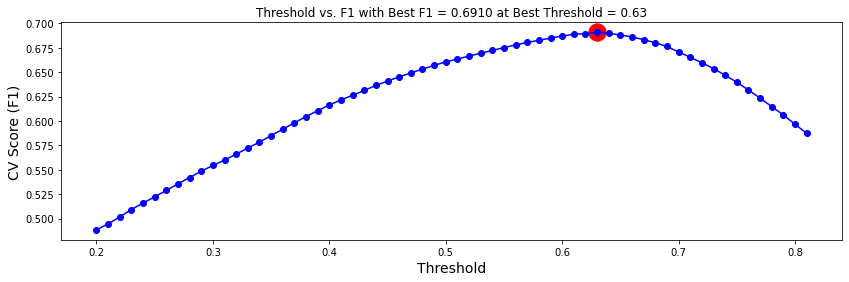

In [20]:
best_f1, best_thres, (f1s, thresholds) = derive_cv_score(y_all, oof_pred, return_traces=True)
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(thresholds, f1s, "-o", color="blue")
ax.scatter([best_thres], [best_f1], color="red", s=300, alpha=1)
ax.set_title(f"Threshold vs. F1 with Best F1 = {best_f1:.4f} at Best Threshold = {best_thres:.3}")
ax.set_xlabel("Threshold", size=14)
ax.set_ylabel("CV Score (F1)", size=14)
plt.show()

# Results

Our model has demonstrated a moderate degree of success, as evidenced by the various metrics obtained after the model training and evaluation stages.

The F1 score, which represents the harmonic mean of precision and recall, is calculated at 0.6910. This score indicates a balanced performance between precision and recall, suggesting that our model has a reasonable performance in correctly predicting both positive and negative classes.

In terms of loss, our model has shown good signs of convergence. The training loss and validation loss stand at 0.2685 and 0.3059, respectively. The relatively close values between the training and validation loss signify that the model is learning effectively without overfitting. Overfitting is typically characterized by a large discrepancy between the training and validation losses, where the training loss is significantly lower. Thus, seeing our model's training and validation losses decrease in tandem is a positive indicator of the model's generalization ability.

The model's performance as measured by AUROC (Area Under the Receiver Operating Characteristic curve) is 0.7411. An AUROC score of 1 represents a perfect classifier, whereas a score of 0.5 represents a random classifier. Hence, our AUROC score of 0.7411 suggests that our model has a reasonably good predictive power.

When we analyze the results across different 'level_groups', we note that 'level_group' 5-12 experiences the highest losses, while 'level_group' 0-4 records the lowest. This outcome might indicate varying degrees of difficulty or differing data characteristics in these groups, which could warrant further investigation for potential model improvements.

Overall, these results provide valuable insights into our model's performance and pave the way for further fine-tuning and optimization.

# Conclusion

This project has taken an important step towards harnessing the power of predictive modelling for the enhancement of game-based learning experiences. The goal was to establish a model that could assess student performance in real-time during game-based learning, based on an extensive dataset of game logs.

The model we've developed demonstrates a reasonably good performance, as evidenced by the F1 score of 0.691. However, we've noted that adding more features to the model seems to degrade the performance, suggesting that the model could benefit from more focused feature selection or feature engineering. Moving forward, it may be beneficial to consider more sophisticated techniques for feature selection, and potentially revisit the feature engineering stage to identify the most impactful attributes.

One of the key observations made was the discrepancy in the model's performance across different 'level_groups', with 'level_group' 5-12 experiencing the highest losses and 'level_group' 0-4 recording the lowest. This discrepancy could indicate varying degrees of difficulty or differing data characteristics in these groups, opening an avenue for further investigation. Addressing these variations might lead to overall improvements in the model's predictive power.

The biggest issue is that there is a clear ceiling in a model's predictive power. Even when the model doesn't overfit the data, the model fails to correctly identify. I feel the data lacks enough context to determine a student's hesitation and expertise in answering the question. For instance, HD and game music is a needless feature, and time_elapsed is insufficient to predict a students answer. 

Achieving success in this model has significant implications. It can aid developers in creating more engaging and effective game-based learning platforms. It can also provide educators with valuable insights into student learning patterns, thereby enabling them to deliver tailored instruction and support. Furthermore, the success of such a model could encourage broader support and adoption of game-based learning platforms.

Overall, this project has underscored the potential of data science in enhancing game-based learning. It has set a path forward for refining and improving the application of knowledge-tracing methodologies in this domain. While the current results are promising, there is still room for improvement and plenty of opportunities for further exploration. As the field of game-based learning continues to grow, so too will the opportunities to leverage data to improve student outcomes.




